# **When some parts of the code were attempted to be run, the output was stopped because the GPU usage exceeded, but the results are included in the report.**

In [2]:
pip install --upgrade python-docx


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 4.6 MB/s eta 0:00:00


In [3]:
pip install --upgrade git+https://github.com/MedMNIST/MedMNIST.git

  Cloning https://github.com/MedMNIST/MedMNIST.git to /tmp/pip-req-build-xqho9c6r
  Running command git clone --filter=blob:none --quiet https://github.com/MedMNIST/MedMNIST.git /tmp/pip-req-build-xqho9c6r
  Resolved https://github.com/MedMNIST/MedMNIST.git to commit 805b74237fb5bd2db376fd94e50646b6a8905d9d
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 94.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/5

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import numpy as np
from medmnist import PathMNIST
import os
from docx import Document
from docx.shared import Inches
import seaborn as sns


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # RGB görüntüler için normalize
])

# Download and load the PathMNIST dataset
full_train_dataset = PathMNIST(split="train", download=True, transform=transform)
test_dataset = PathMNIST( split="test", download=True, transform=transform)

# Split the training dataset: 70% for training, 30% for validation.
train_size = int(0.7 * len(full_train_dataset))  # %70
val_size = len(full_train_dataset) - train_size  # %30
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

100%|██████████| 206M/206M [00:03<00:00, 63.5MB/s]


Using downloaded and verified file: /root/.medmnist/pathmnist.npz


In [5]:
class PathMNIST_CNN(nn.Module):
    def __init__(self,
                 input_channels=3,
                 num_classes=9,
                 conv_kernel_size=3,
                 conv_dropout=0.2,
                 activation_fn='relu',
                 num_conv_layers=2,
                 fc_hidden_units=128,
                 pool_kernel_size=2,
                 pool_stride=2,
                 fc_dropout=0.3):

        super(PathMNIST_CNN, self).__init__()
        activations = {'relu': nn.ReLU(), 'tanh': nn.Tanh(), 'sigmoid': nn.Sigmoid()}
        self.activation = activations[activation_fn]

        layers = []
        in_channels = input_channels
        for _ in range(num_conv_layers):
            layers.append(nn.Conv2d(in_channels, 32, kernel_size=conv_kernel_size, padding=conv_kernel_size//2))
            layers.append(nn.MaxPool2d(kernel_size=pool_kernel_size, stride=pool_stride))
            layers.append(nn.Dropout(conv_dropout))
            layers.append(self.activation)
            in_channels = 32

        self.conv = nn.Sequential(*layers)

        # Dummy forward pass to get the correct output size for the fully connected layer
        self._get_conv_output()

        self.fc1 = nn.Linear(self._to_linear, fc_hidden_units)  # Correct input size from conv layers
        self.dropout = nn.Dropout(fc_dropout)
        self.fc2 = nn.Linear(fc_hidden_units, num_classes)

    def _get_conv_output(self):
        with torch.no_grad():  # Disables gradient tracking, we only need the output shape.
            # Create a dummy input (batch size 1, 3 channels, 28x28)
            x = torch.randn(1, 3, 28, 28)  # Adjusting to 3 channels as mentioned
            # Process the dummy input through conv layers, activations, and pooling
            x = self.conv(x)
            # Flatten the output to calculate the input size for the fully connected layer
            self._to_linear = x.view(1, -1).shape[1]  # Automatically determines the correct size

    def forward(self, x):
        x = self.conv(x)  # Apply conv layers
        x = x.view(-1, self._to_linear)  # Flatten to feed into the fully connected layer
        x = self.fc1(x)  # First fully connected layer
        x = self.activation(x)  # Activation
        x = self.dropout(x)  # Dropout layer
        x = self.fc2(x)  # Output layer
        return x



In [6]:
def calculate_accuracy(y_true, y_pred):
    y_pred = torch.argmax(y_pred, dim=1)
    correct = (y_pred == y_true).sum().item()
    return correct / len(y_true)

# Eğitim ve doğrulama işlemleri
def train_and_validate(model, train_loader, val_loader, optimizer, criterion, epochs=10):
    train_losses, val_losses, val_accuracies, train_accuracies = [], [], [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            labels = labels.squeeze(dim=1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_losses.append(running_loss / len(train_loader))
        train_accuracy = correct_train / total_train * 100
        train_accuracies.append(train_accuracy)

        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        all_preds, all_labels = [], []

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                labels = labels.squeeze(dim=1)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

                all_preds.append(outputs.cpu())
                all_labels.append(labels.cpu())

        val_losses.append(val_loss / len(val_loader))  # Her epoch sonunda doğrulama kaybını kaydediyoruz
        val_accuracy = correct_val / total_val * 100  # Doğrulama doğruluğunu hesapla
        val_accuracies.append(val_accuracy)  # Doğrulama doğruluğunu kaydediyoruz


    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    return train_losses, val_losses, val_accuracies, train_accuracies, all_preds, all_labels

# **Hyperparameter Testing**

I defined fixed parameters as a start to the code.

There is a test cell for each parameter.

I update the best result of each cell in the next cell and start testing the new parameter.




In [ ]:
fixed_params = {
    'conv_kernel_size': 3,
    'conv_dropout': 0.2,
    'activation_fn': 'relu',
    'batch_size': 64,
    'optimizer_type': 'adam',
    'num_conv_layers': 2,
    'fc_hidden_units': 128,
    'pool_kernel_size': 2,
    'pool_stride': 2,
    'fc_dropout': 0.3,
    'num_epochs': 10
}

conv_kernel_size = [3, 5, 7, 9, 11, 13]
criterion = nn.CrossEntropyLoss()

for val in conv_kernel_size:
    print(f"\n--- Testing conv_kernel_size = {val} ---")

    current_params = fixed_params.copy()
    current_params['conv_kernel_size'] = val
    batch_size = current_params['batch_size']

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    try:
        model = PathMNIST_CNN(
            conv_kernel_size=current_params['conv_kernel_size'],
            conv_dropout=current_params['conv_dropout'],
            activation_fn=current_params['activation_fn'],
            num_conv_layers=current_params['num_conv_layers'],
            fc_hidden_units=current_params['fc_hidden_units'],
            pool_kernel_size=current_params['pool_kernel_size'],
            pool_stride=current_params['pool_stride'],
            fc_dropout=current_params['fc_dropout']
        ).to(device)
    except Exception as e:
        print(f"[SKIPPED] Hata oluştu: {e} → conv_kernel_size = {val}")
        continue

    if current_params['optimizer_type'] == 'adam':
        optimizer = optim.Adam(model.parameters())
    elif current_params['optimizer_type'] == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    else:
        optimizer = optim.RMSprop(model.parameters())

    train_losses, val_losses, val_accuracies, train_accuracies, preds, labels = train_and_validate(
        model, train_loader, val_loader, optimizer, criterion, epochs=current_params['num_epochs'])

    print(f"Train Accuracy: {train_accuracies[-1]:.2f}%")
    print(f"Validation Accuracy: {val_accuracies[-1]:.2f}%")

    # Plot Loss
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Loss Curve: conv_kernel_size = {val}')
    plt.legend()
    plt.show()

    # Plot Accuracy
    plt.figure(figsize=(8, 5))
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy Curve: conv_kernel_size = {val}')
    plt.legend()
    plt.show()

    # Confusion Matrix
    cm = confusion_matrix(labels, preds.argmax(dim=1))
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix: conv_kernel_size = {val}")
    plt.colorbar()
    tick_marks = np.arange(10)
    plt.xticks(tick_marks, tick_marks)
    plt.yticks(tick_marks, tick_marks)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    # Classification Report
    print("Classification Report:")
    print(classification_report(labels, preds.argmax(dim=1), digits=4))


--- Testing conv_kernel_size = 3 ---


KeyboardInterrupt: 


--- Testing conv_dropout = 0 ---
Train Accuracy: 88.47%
Validation Accuracy: 86.73%


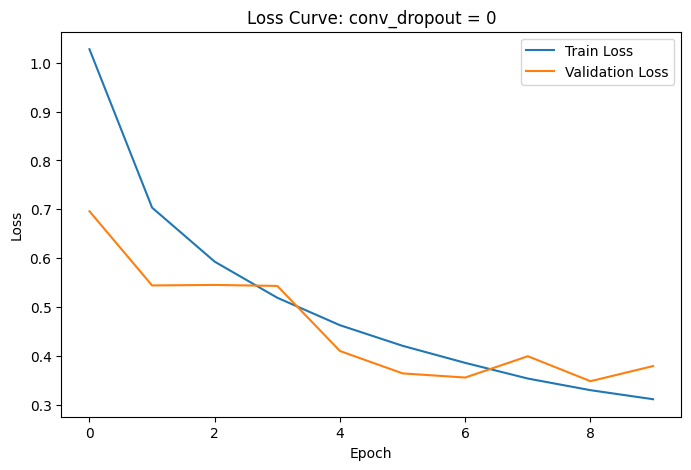

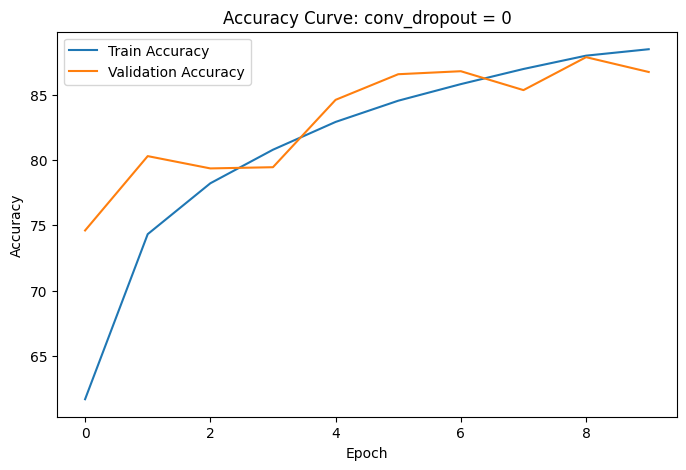

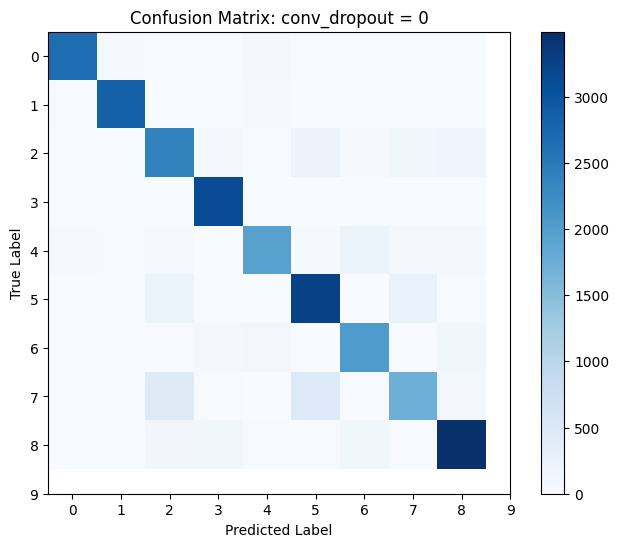

Classification Report:
              precision    recall  f1-score   support

           0     0.9755    0.9553    0.9653      2796
           1     0.9664    0.9785    0.9724      2885
           2     0.7406    0.7919    0.7654      2999
           3     0.9131    0.9952    0.9524      3124
           4     0.8947    0.8131    0.8519      2392
           5     0.8129    0.8740    0.8423      3713
           6     0.8449    0.8596    0.8522      2371
           7     0.7915    0.6134    0.6912      2804
           8     0.8775    0.8914    0.8844      3915

    accuracy                         0.8673     26999
   macro avg     0.8686    0.8636    0.8642     26999
weighted avg     0.8669    0.8673    0.8653     26999


--- Testing conv_dropout = 0.1 ---
Train Accuracy: 88.51%
Validation Accuracy: 87.98%


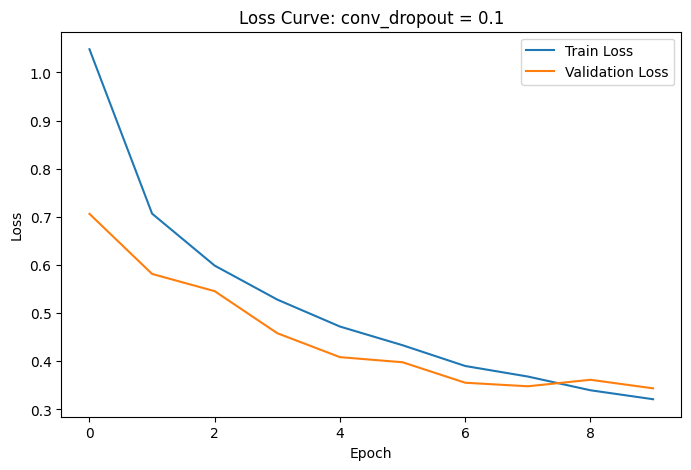

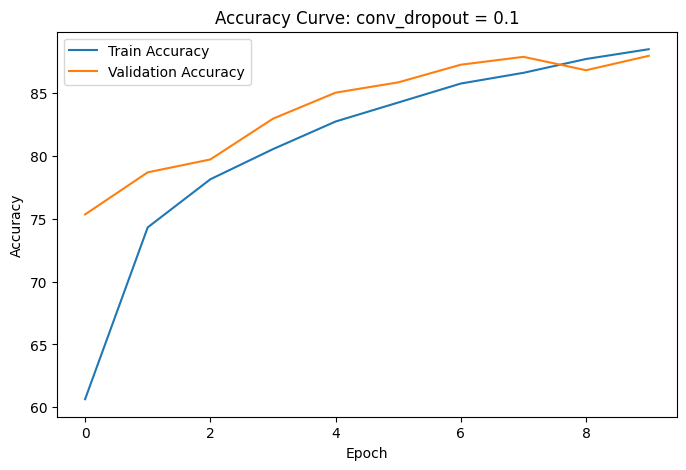

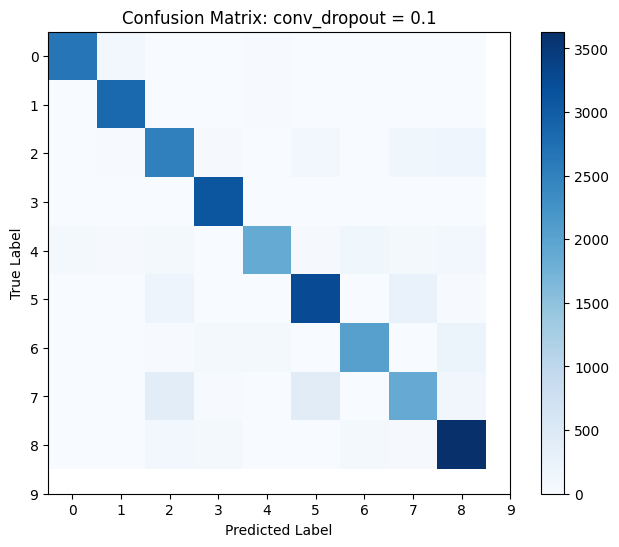

Classification Report:
              precision    recall  f1-score   support

           0     0.9615    0.9474    0.9544      2796
           1     0.9431    0.9875    0.9648      2885
           2     0.7743    0.8353    0.8037      2999
           3     0.9386    0.9930    0.9650      3124
           4     0.9331    0.7872    0.8540      2392
           5     0.8500    0.8729    0.8613      3713
           6     0.8974    0.8558    0.8761      2371
           7     0.7916    0.6651    0.7229      2804
           8     0.8574    0.9275    0.8910      3915

    accuracy                         0.8798     26999
   macro avg     0.8830    0.8746    0.8770     26999
weighted avg     0.8799    0.8798    0.8782     26999


--- Testing conv_dropout = 0.2 ---
Train Accuracy: 87.83%
Validation Accuracy: 89.46%


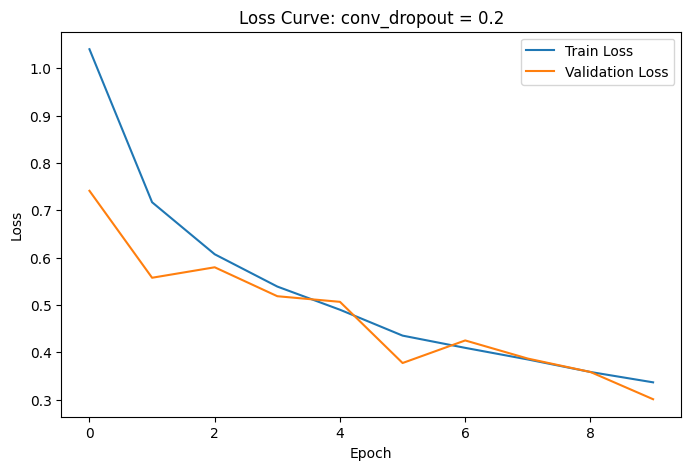

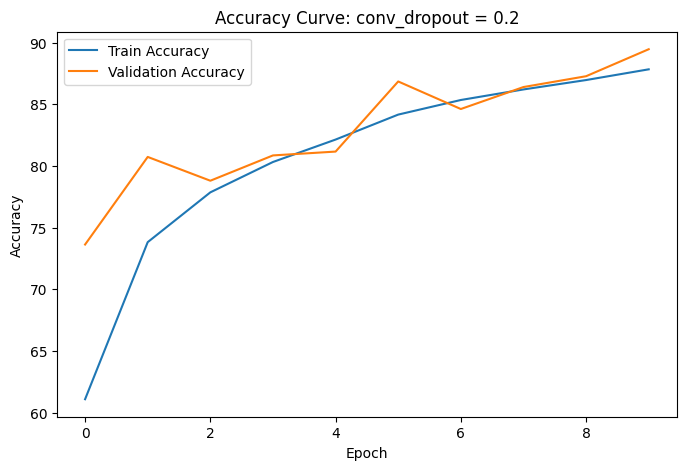

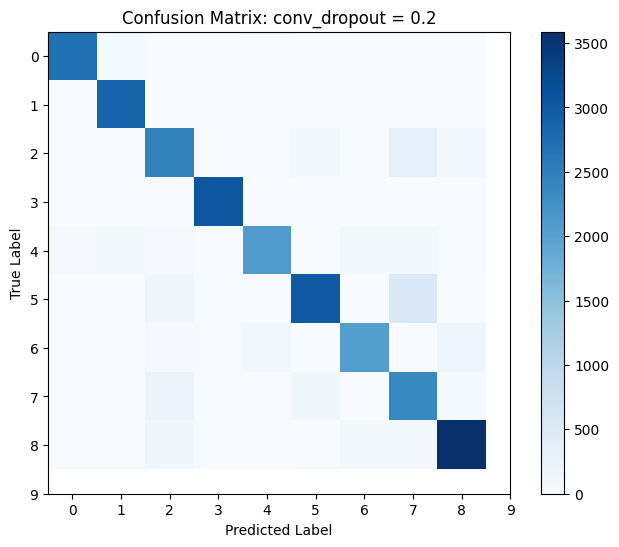

Classification Report:
              precision    recall  f1-score   support

           0     0.9765    0.9675    0.9720      2796
           1     0.9409    0.9934    0.9664      2885
           2     0.8126    0.8153    0.8139      2999
           3     0.9770    0.9808    0.9789      3124
           4     0.9073    0.8717    0.8891      2392
           5     0.9231    0.8088    0.8622      3713
           6     0.9155    0.8596    0.8867      2371
           7     0.7134    0.8417    0.7723      2804
           8     0.9077    0.9165    0.9120      3915

    accuracy                         0.8946     26999
   macro avg     0.8971    0.8950    0.8948     26999
weighted avg     0.8984    0.8946    0.8953     26999


--- Testing conv_dropout = 0.3 ---
Train Accuracy: 86.52%
Validation Accuracy: 88.33%


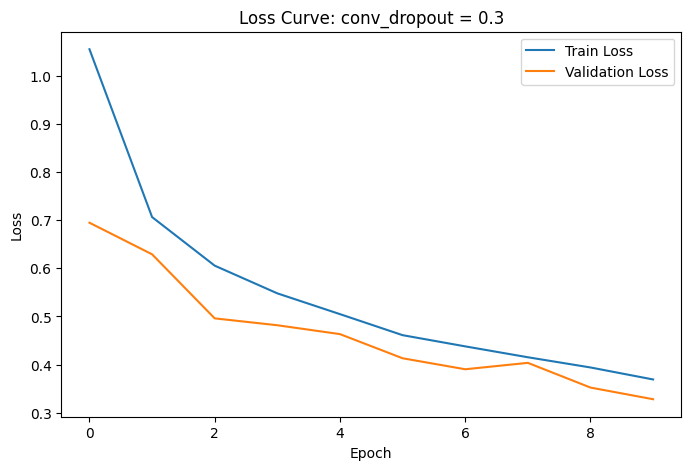

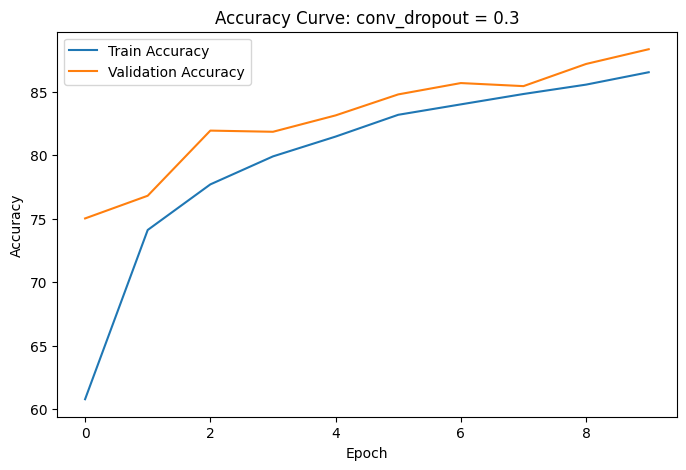

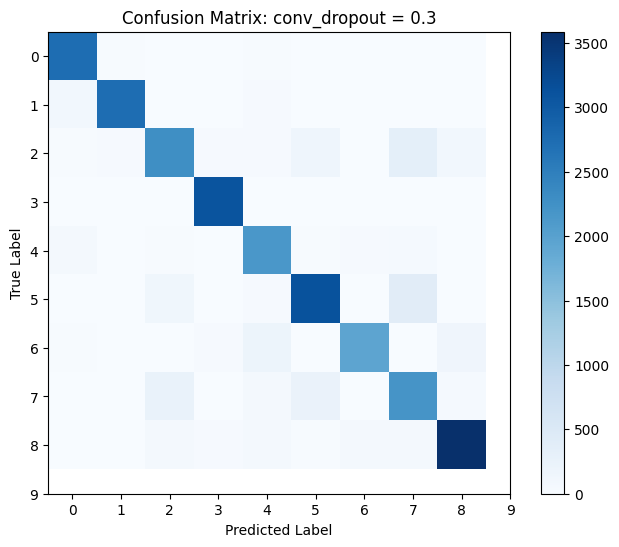

Classification Report:
              precision    recall  f1-score   support

           0     0.9222    0.9793    0.9499      2796
           1     0.9734    0.9504    0.9618      2885
           2     0.8226    0.7589    0.7895      2999
           3     0.9624    0.9901    0.9760      3124
           4     0.8301    0.9009    0.8641      2392
           5     0.8742    0.8387    0.8561      3713
           6     0.9352    0.8212    0.8745      2371
           7     0.7167    0.7832    0.7485      2804
           8     0.9132    0.9162    0.9147      3915

    accuracy                         0.8833     26999
   macro avg     0.8833    0.8821    0.8817     26999
weighted avg     0.8850    0.8833    0.8832     26999


--- Testing conv_dropout = 0.4 ---
Train Accuracy: 84.82%
Validation Accuracy: 86.49%


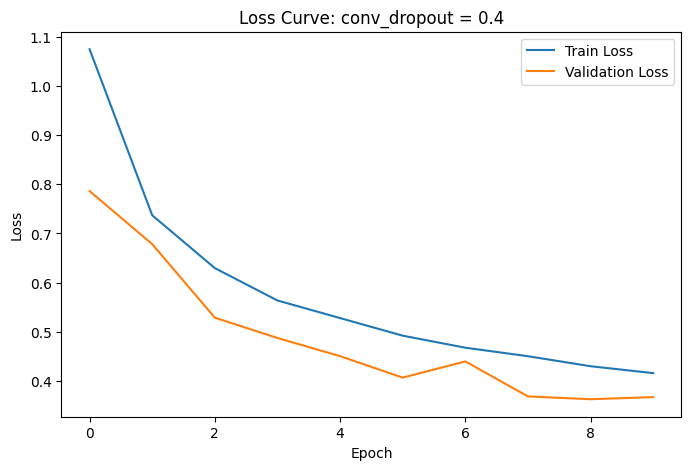

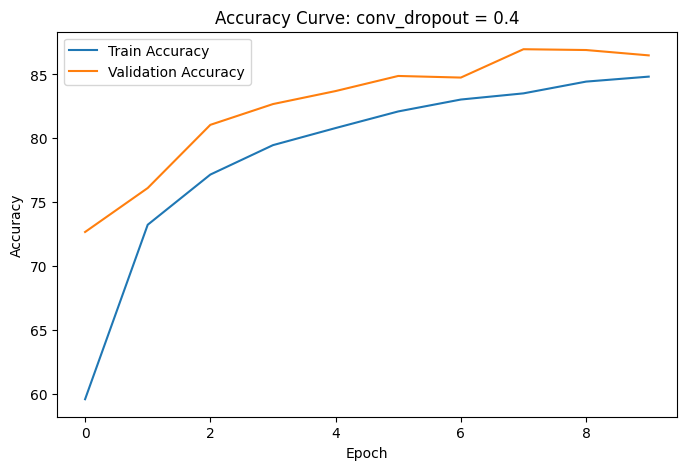

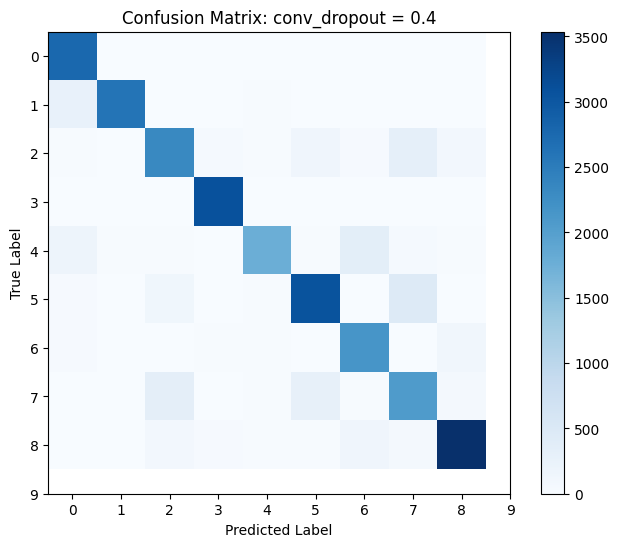

Classification Report:
              precision    recall  f1-score   support

           0     0.8438    0.9914    0.9117      2796
           1     0.9875    0.9002    0.9418      2885
           2     0.7920    0.7769    0.7844      2999
           3     0.9634    0.9872    0.9752      3124
           4     0.9296    0.7337    0.8201      2392
           5     0.8694    0.8247    0.8464      3713
           6     0.7881    0.9051    0.8426      2371
           7     0.6978    0.7379    0.7173      2804
           8     0.9201    0.9032    0.9116      3915

    accuracy                         0.8649     26999
   macro avg     0.8657    0.8622    0.8612     26999
weighted avg     0.8694    0.8649    0.8647     26999


--- Testing conv_dropout = 0.5 ---
Train Accuracy: 84.07%
Validation Accuracy: 87.38%


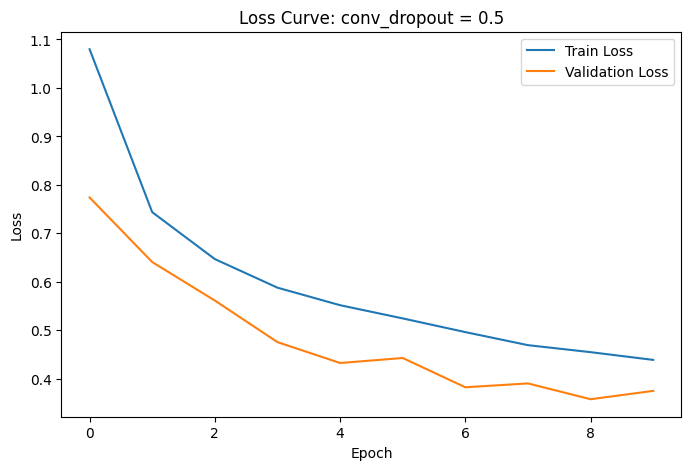

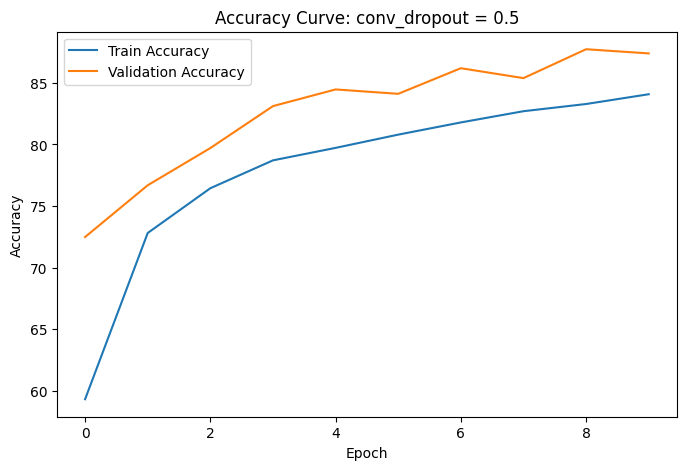

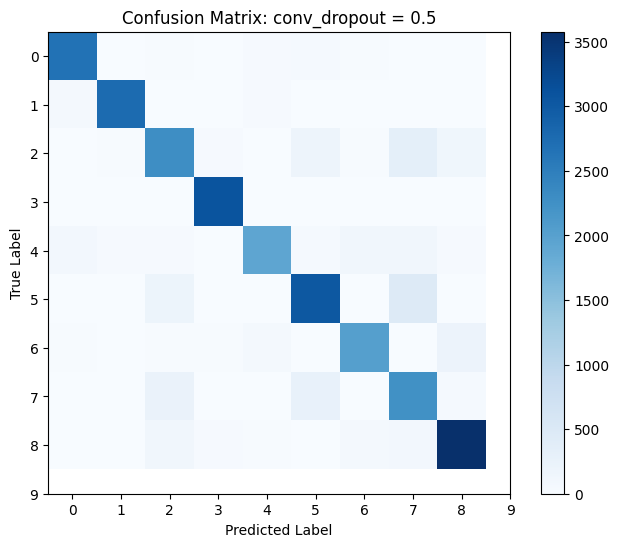

Classification Report:
              precision    recall  f1-score   support

           0     0.9418    0.9542    0.9479      2796
           1     0.9735    0.9567    0.9650      2885
           2     0.7866    0.7619    0.7741      2999
           3     0.9689    0.9872    0.9780      3124
           4     0.9158    0.8043    0.8564      2392
           5     0.8443    0.8166    0.8302      3713
           6     0.8914    0.8520    0.8713      2371
           7     0.6867    0.7996    0.7388      2804
           8     0.8900    0.9139    0.9018      3915

    accuracy                         0.8738     26999
   macro avg     0.8777    0.8718    0.8737     26999
weighted avg     0.8769    0.8738    0.8745     26999



In [ ]:
from itertools import product

fixed_params = {
    'conv_kernel_size': 5,   #bir önceki deneyin en iyi sonucu
    'conv_dropout': 0.2,
    'activation_fn': 'relu',
    'batch_size': 64,
    'optimizer_type': 'adam',
    'num_conv_layers': 2,
    'fc_hidden_units': 128,
    'pool_kernel_size': 2,
    'pool_stride': 2,
    'fc_dropout': 0.3,
    'num_epochs': 10
}

conv_dropout = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
criterion = nn.CrossEntropyLoss()

for val in conv_dropout:
    print(f"\n--- Testing conv_dropout = {val} ---")

    current_params = fixed_params.copy()
    current_params['conv_dropout'] = val
    batch_size = current_params['batch_size']

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    try:
        model = PathMNIST_CNN(
            conv_kernel_size=current_params['conv_kernel_size'],
            conv_dropout=current_params['conv_dropout'],
            activation_fn=current_params['activation_fn'],
            num_conv_layers=current_params['num_conv_layers'],
            fc_hidden_units=current_params['fc_hidden_units'],
            pool_kernel_size=current_params['pool_kernel_size'],
            pool_stride=current_params['pool_stride'],
            fc_dropout=current_params['fc_dropout']
        ).to(device)
    except Exception as e:
        print(f"[SKIPPED] Hata oluştu: {e} → conv_dropout = {val}")
        continue

    if current_params['optimizer_type'] == 'adam':
        optimizer = optim.Adam(model.parameters())
    elif current_params['optimizer_type'] == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    else:
        optimizer = optim.RMSprop(model.parameters())

    train_losses, val_losses, val_accuracies, train_accuracies, preds, labels = train_and_validate(
        model, train_loader, val_loader, optimizer, criterion, epochs=current_params['num_epochs'])

    print(f"Train Accuracy: {train_accuracies[-1]:.2f}%")
    print(f"Validation Accuracy: {val_accuracies[-1]:.2f}%")

    # Plot Loss
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Loss Curve: conv_dropout = {val}')
    plt.legend()
    plt.show()

    # Plot Accuracy
    plt.figure(figsize=(8, 5))
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy Curve: conv_dropout = {val}')
    plt.legend()
    plt.show()

    # Confusion Matrix
    cm = confusion_matrix(labels, preds.argmax(dim=1))
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix: conv_dropout = {val}")
    plt.colorbar()
    tick_marks = np.arange(10)
    plt.xticks(tick_marks, tick_marks)
    plt.yticks(tick_marks, tick_marks)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    # Classification Report
    print("Classification Report:")
    print(classification_report(labels, preds.argmax(dim=1), digits=4))



--- Testing activation_fn = relu ---
Train Accuracy: 86.75%
Validation Accuracy: 87.66%


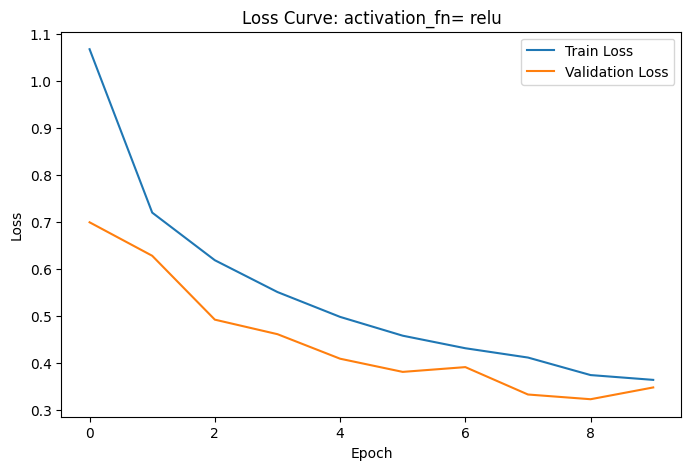

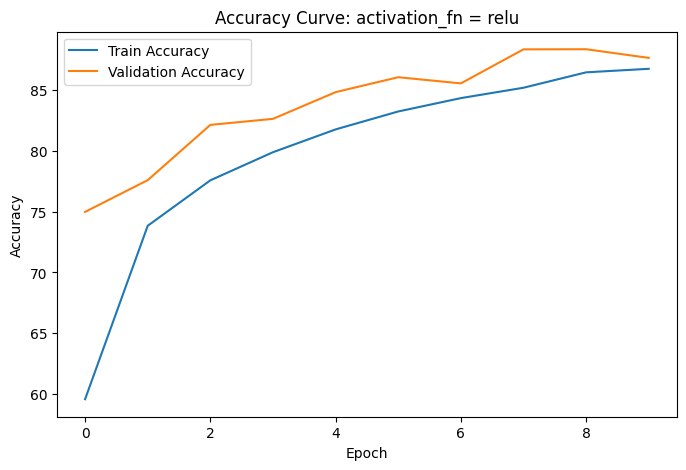

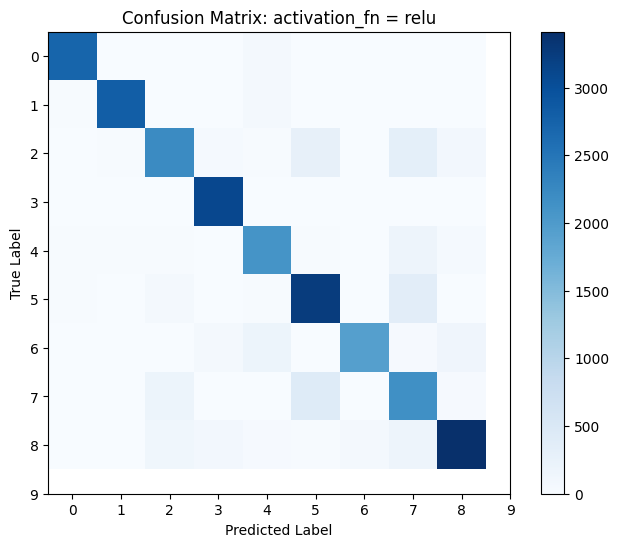

Classification Report:
              precision    recall  f1-score   support

           0     0.9721    0.9714    0.9717      2796
           1     0.9838    0.9705    0.9771      2885
           2     0.8457    0.7382    0.7883      2999
           3     0.9318    0.9930    0.9614      3124
           4     0.8505    0.8750    0.8626      2392
           5     0.8152    0.8731    0.8432      3713
           6     0.9512    0.8136    0.8770      2371
           7     0.6710    0.7696    0.7169      2804
           8     0.9147    0.8715    0.8926      3915

    accuracy                         0.8766     26999
   macro avg     0.8818    0.8751    0.8768     26999
weighted avg     0.8809    0.8766    0.8771     26999


--- Testing activation_fn = tanh ---
Train Accuracy: 83.28%
Validation Accuracy: 84.19%


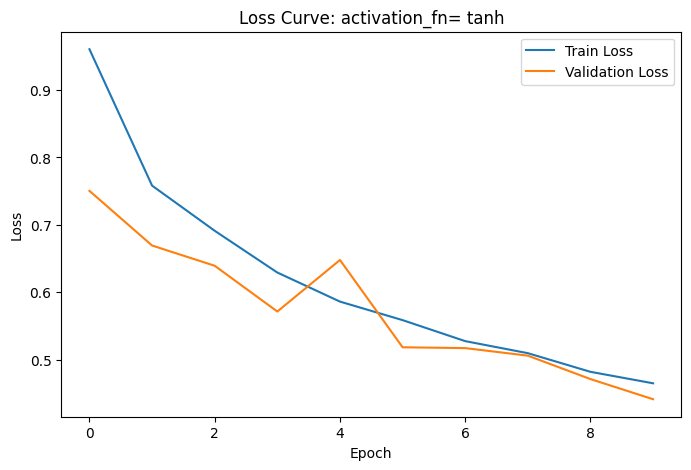

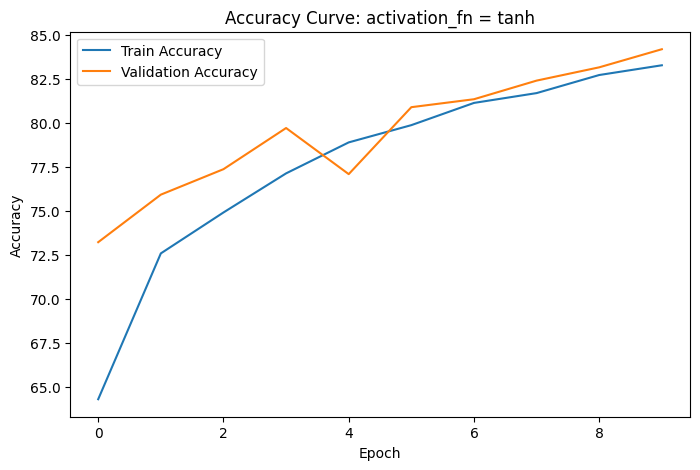

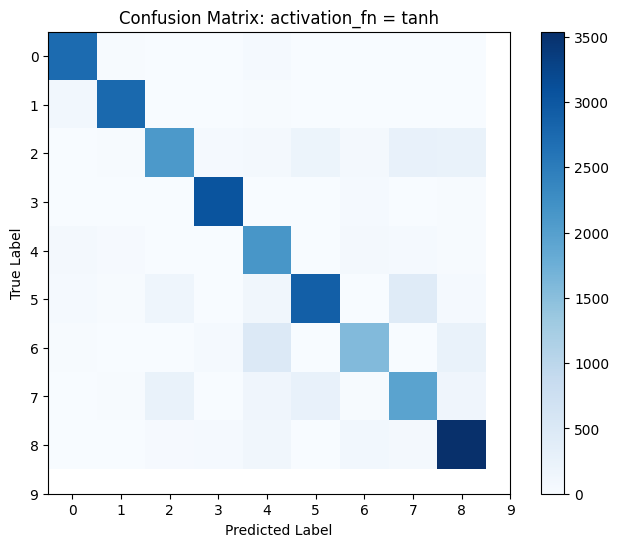

Classification Report:
              precision    recall  f1-score   support

           0     0.9139    0.9789    0.9453      2796
           1     0.9667    0.9553    0.9609      2885
           2     0.8195    0.6966    0.7531      2999
           3     0.9552    0.9754    0.9652      3124
           4     0.6812    0.8934    0.7730      2392
           5     0.8546    0.7818    0.8166      3713
           6     0.8418    0.6643    0.7426      2371
           7     0.7114    0.6944    0.7028      2804
           8     0.8284    0.9040    0.8645      3915

    accuracy                         0.8419     26999
   macro avg     0.8414    0.8382    0.8360     26999
weighted avg     0.8453    0.8419    0.8402     26999


--- Testing activation_fn = sigmoid ---
Train Accuracy: 69.19%
Validation Accuracy: 65.12%


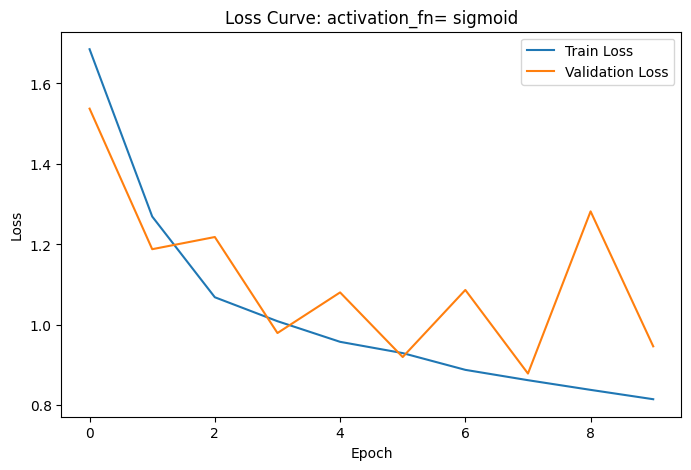

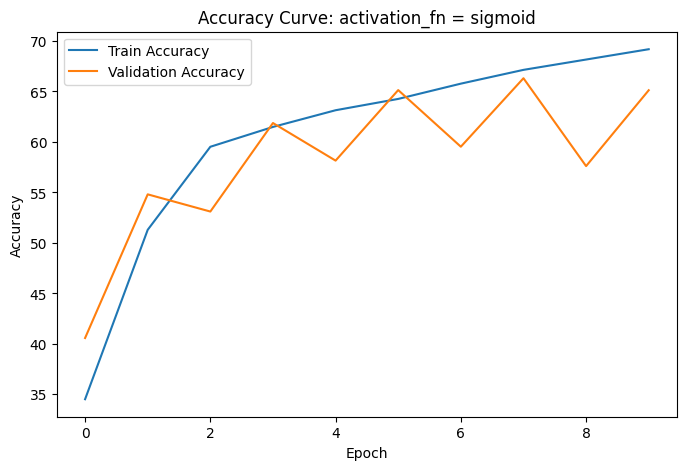

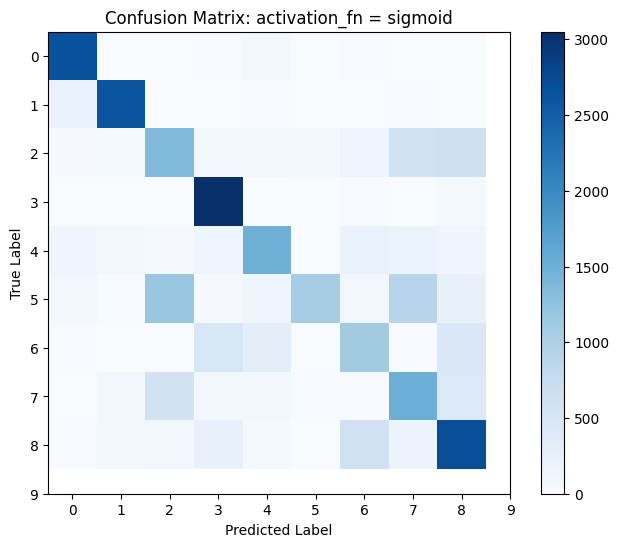

Classification Report:
              precision    recall  f1-score   support

           0     0.8480    0.9535    0.8976      2796
           1     0.9012    0.9106    0.9059      2885
           2     0.4170    0.4522    0.4339      2999
           3     0.7425    0.9763    0.8435      3124
           4     0.6724    0.6254    0.6480      2392
           5     0.9288    0.2879    0.4396      3713
           6     0.4975    0.4652    0.4808      2371
           7     0.4507    0.5428    0.4925      2804
           8     0.5844    0.6881    0.6320      3915

    accuracy                         0.6512     26999
   macro avg     0.6714    0.6558    0.6415     26999
weighted avg     0.6789    0.6512    0.6384     26999



In [ ]:
from itertools import product

fixed_params = {
    'conv_kernel_size': 5,
    'conv_dropout': 0.2,   #bir önceki teste göre dropout değeri güncellendi
    'activation_fn': 'relu',
    'batch_size': 64,
    'optimizer_type': 'adam',
    'num_conv_layers': 2,
    'fc_hidden_units': 128,
    'pool_kernel_size': 2,
    'pool_stride': 2,
    'fc_dropout': 0.3,
    'num_epochs': 10
}

activation_fn = ['relu', 'tanh', 'sigmoid']
criterion = nn.CrossEntropyLoss()

for val in activation_fn:
    print(f"\n--- Testing activation_fn = {val} ---")

    current_params = fixed_params.copy()
    current_params['activation_fn'] = val
    batch_size = current_params['batch_size']

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    try:
        model = PathMNIST_CNN(
            conv_kernel_size=current_params['conv_kernel_size'],
            conv_dropout=current_params['conv_dropout'],
            activation_fn=current_params['activation_fn'],
            num_conv_layers=current_params['num_conv_layers'],
            fc_hidden_units=current_params['fc_hidden_units'],
            pool_kernel_size=current_params['pool_kernel_size'],
            pool_stride=current_params['pool_stride'],
            fc_dropout=current_params['fc_dropout']
        ).to(device)
    except Exception as e:
        print(f"[SKIPPED] Hata oluştu: {e} → activation_fn = {val}")
        continue

    if current_params['optimizer_type'] == 'adam':
        optimizer = optim.Adam(model.parameters())
    elif current_params['optimizer_type'] == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    else:
        optimizer = optim.RMSprop(model.parameters())

    train_losses, val_losses, val_accuracies, train_accuracies, preds, labels = train_and_validate(
        model, train_loader, val_loader, optimizer, criterion, epochs=current_params['num_epochs'])

    print(f"Train Accuracy: {train_accuracies[-1]:.2f}%")
    print(f"Validation Accuracy: {val_accuracies[-1]:.2f}%")

    # Plot Loss
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Loss Curve: activation_fn= {val}')
    plt.legend()
    plt.show()

    # Plot Accuracy
    plt.figure(figsize=(8, 5))
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy Curve: activation_fn = {val}')
    plt.legend()
    plt.show()

    # Confusion Matrix
    cm = confusion_matrix(labels, preds.argmax(dim=1))
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix: activation_fn = {val}")
    plt.colorbar()
    tick_marks = np.arange(10)
    plt.xticks(tick_marks, tick_marks)
    plt.yticks(tick_marks, tick_marks)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    # Classification Report
    print("Classification Report:")
    print(classification_report(labels, preds.argmax(dim=1), digits=4))



--- Testing batch_size = 16 ---
Train Accuracy: 87.53%
Validation Accuracy: 88.22%


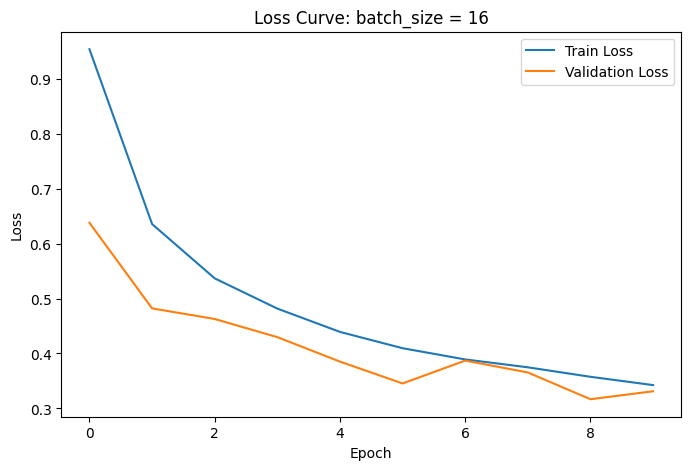

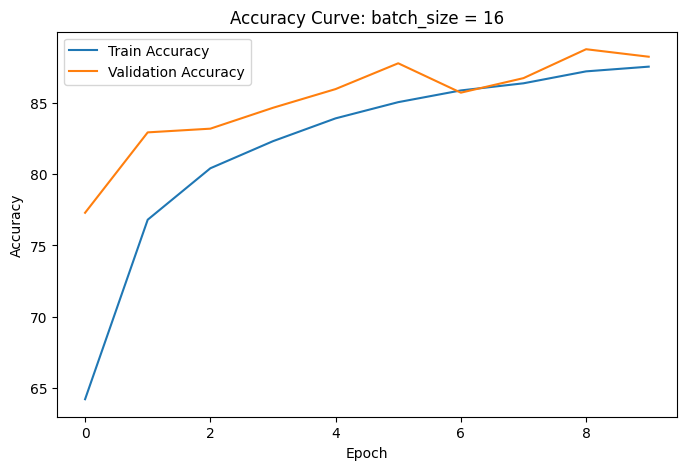

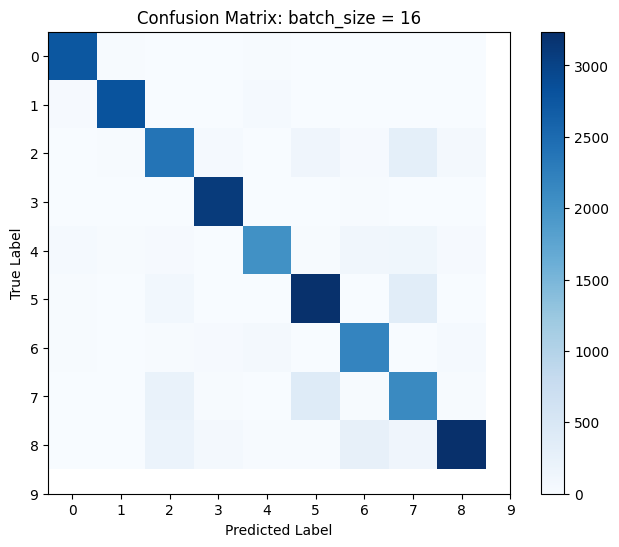

Classification Report:
              precision    recall  f1-score   support

           0     0.9581    0.9818    0.9698      2796
           1     0.9777    0.9719    0.9748      2885
           2     0.8093    0.7966    0.8029      2999
           3     0.9456    0.9910    0.9678      3124
           4     0.9222    0.8470    0.8830      2392
           5     0.8517    0.8680    0.8598      3713
           6     0.8351    0.9186    0.8749      2371
           7     0.7026    0.7568    0.7287      2804
           8     0.9432    0.8266    0.8810      3915

    accuracy                         0.8822     26999
   macro avg     0.8828    0.8843    0.8825     26999
weighted avg     0.8849    0.8822    0.8825     26999


--- Testing batch_size = 32 ---
Train Accuracy: 87.75%
Validation Accuracy: 87.29%


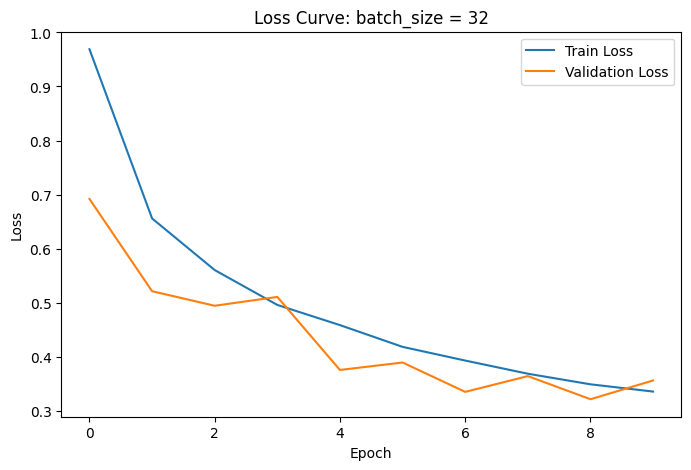

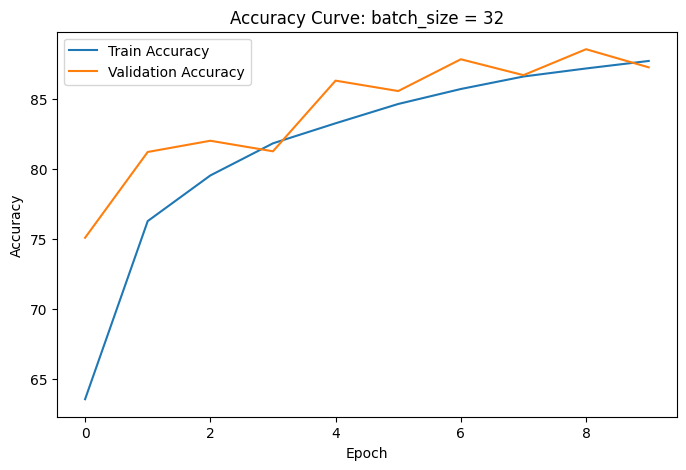

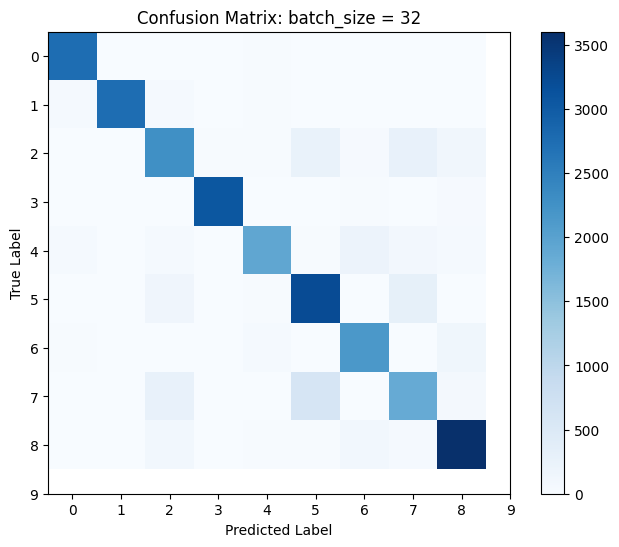

Classification Report:
              precision    recall  f1-score   support

           0     0.9555    0.9821    0.9686      2796
           1     0.9892    0.9522    0.9703      2885
           2     0.7895    0.7589    0.7739      2999
           3     0.9833    0.9802    0.9817      3124
           4     0.9224    0.8006    0.8572      2392
           5     0.7856    0.8664    0.8240      3713
           6     0.8427    0.9064    0.8734      2371
           7     0.7122    0.6619    0.6861      2804
           8     0.8946    0.9195    0.9069      3915

    accuracy                         0.8729     26999
   macro avg     0.8750    0.8698    0.8714     26999
weighted avg     0.8736    0.8729    0.8723     26999


--- Testing batch_size = 64 ---
Train Accuracy: 86.50%
Validation Accuracy: 86.20%


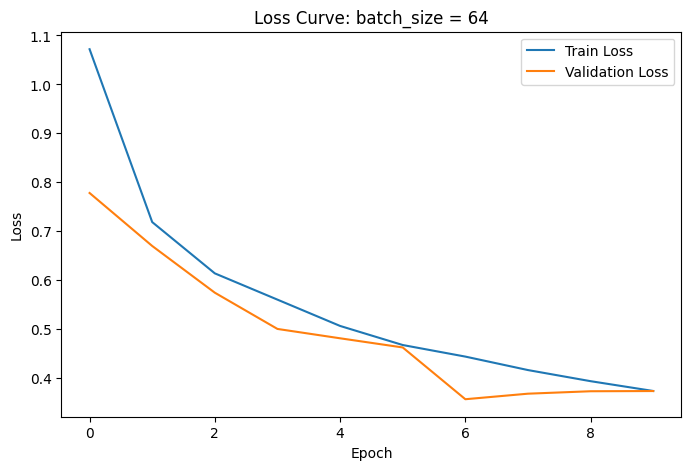

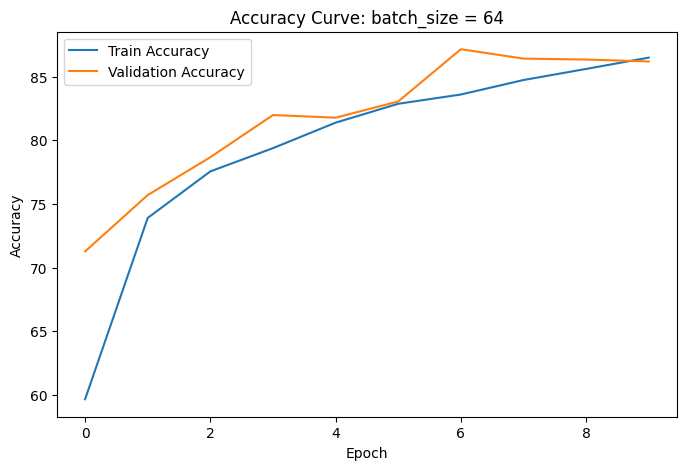

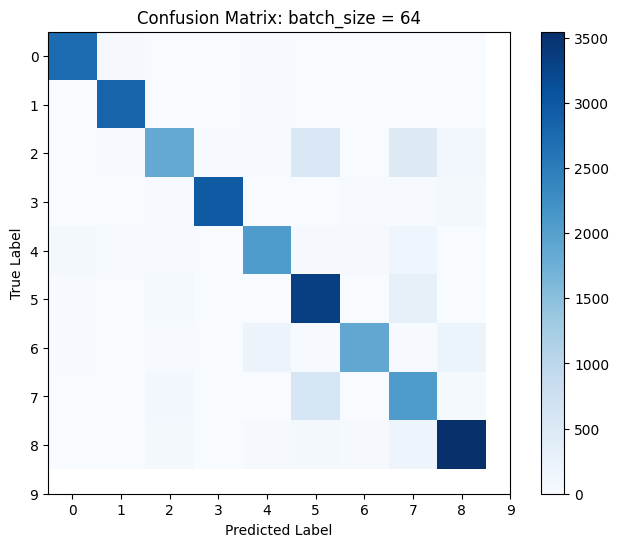

Classification Report:
              precision    recall  f1-score   support

           0     0.9625    0.9732    0.9678      2796
           1     0.9659    0.9830    0.9744      2885
           2     0.8793    0.6172    0.7253      2999
           3     0.9907    0.9517    0.9708      3124
           4     0.8659    0.8637    0.8648      2392
           5     0.7323    0.8960    0.8060      3713
           6     0.9466    0.7929    0.8630      2371
           7     0.6491    0.7389    0.6911      2804
           8     0.8817    0.9060    0.8937      3915

    accuracy                         0.8620     26999
   macro avg     0.8749    0.8581    0.8619     26999
weighted avg     0.8710    0.8620    0.8618     26999


--- Testing batch_size = 128 ---
Train Accuracy: 85.58%
Validation Accuracy: 87.16%


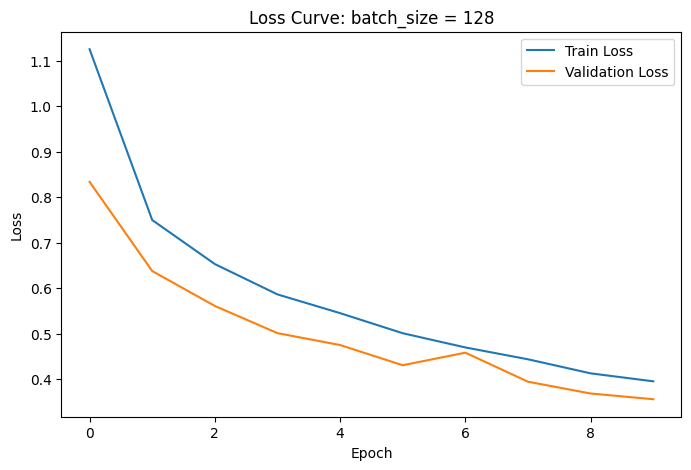

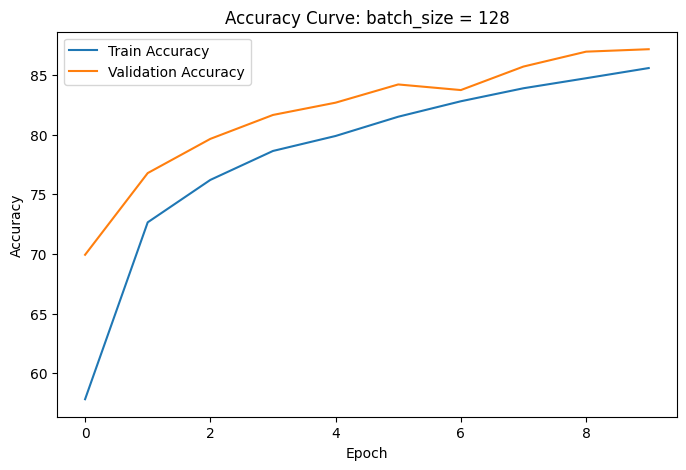

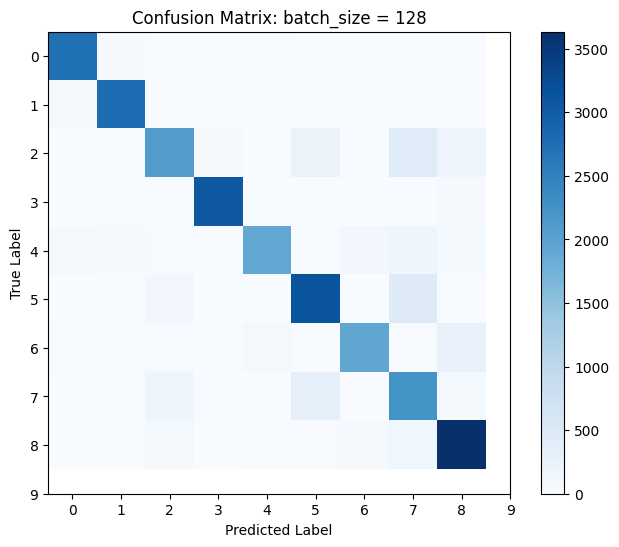

Classification Report:
              precision    recall  f1-score   support

           0     0.9420    0.9764    0.9589      2796
           1     0.9680    0.9636    0.9658      2885
           2     0.8481    0.6979    0.7657      2999
           3     0.9814    0.9786    0.9800      3124
           4     0.9332    0.7997    0.8613      2392
           5     0.8305    0.8443    0.8373      3713
           6     0.9220    0.8178    0.8668      2371
           7     0.6475    0.8024    0.7167      2804
           8     0.8565    0.9282    0.8909      3915

    accuracy                         0.8716     26999
   macro avg     0.8810    0.8677    0.8715     26999
weighted avg     0.8780    0.8716    0.8721     26999


--- Testing batch_size = 256 ---
Train Accuracy: 82.63%
Validation Accuracy: 83.84%


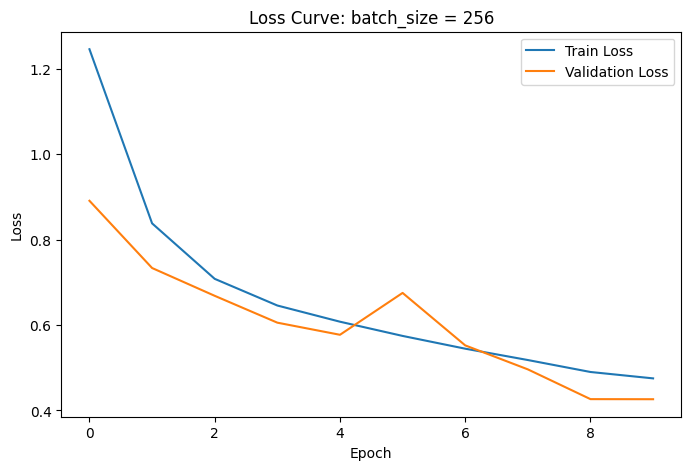

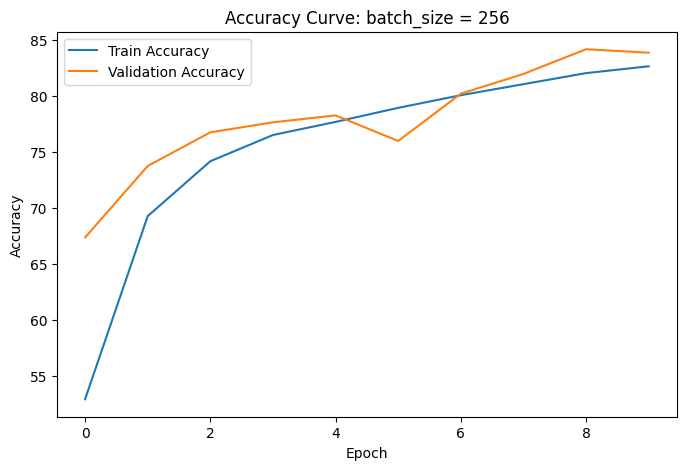

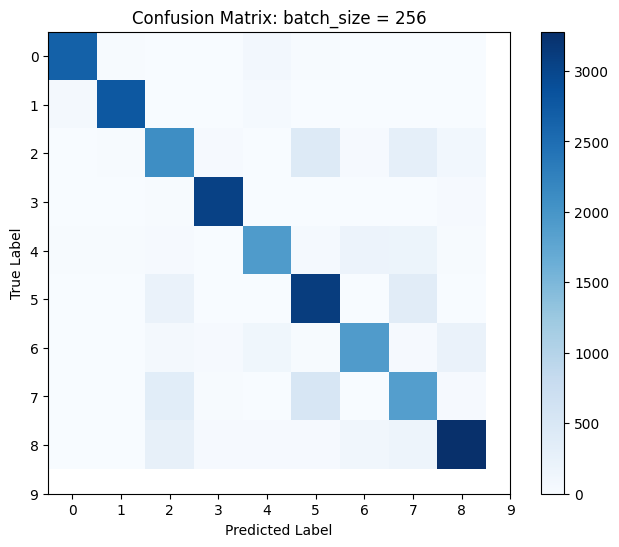

Classification Report:
              precision    recall  f1-score   support

           0     0.9665    0.9492    0.9578      2796
           1     0.9760    0.9591    0.9675      2885
           2     0.6893    0.6992    0.6943      2999
           3     0.9638    0.9795    0.9716      3124
           4     0.8634    0.7981    0.8295      2392
           5     0.7408    0.8365    0.7857      3713
           6     0.8421    0.8005    0.8208      2371
           7     0.6471    0.6651    0.6560      2804
           8     0.8957    0.8375    0.8656      3915

    accuracy                         0.8384     26999
   macro avg     0.8427    0.8361    0.8387     26999
weighted avg     0.8419    0.8384    0.8394     26999


--- Testing batch_size = 512 ---
Train Accuracy: 78.85%
Validation Accuracy: 79.31%


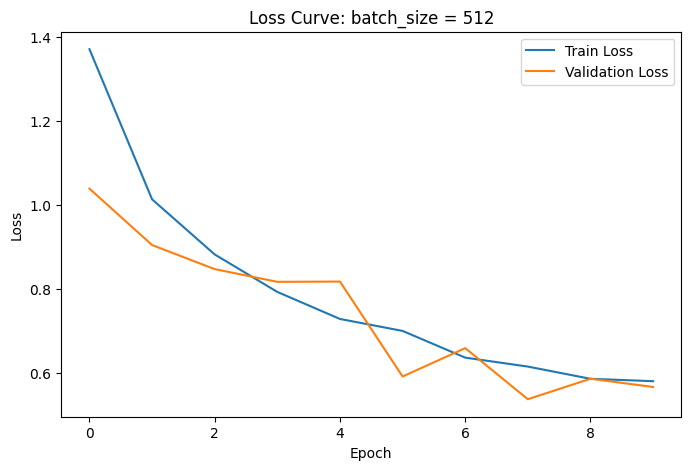

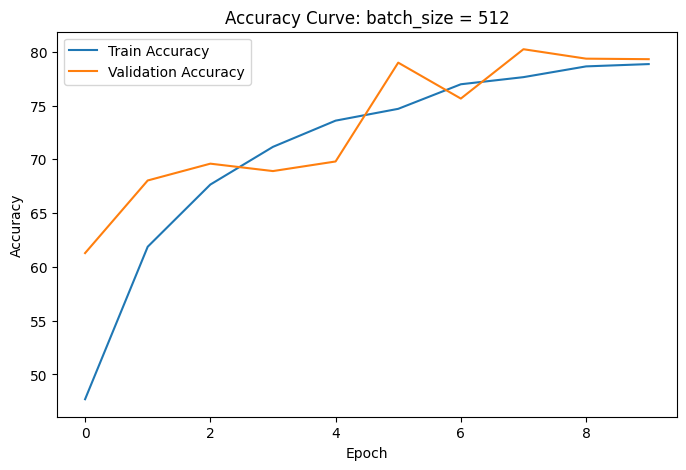

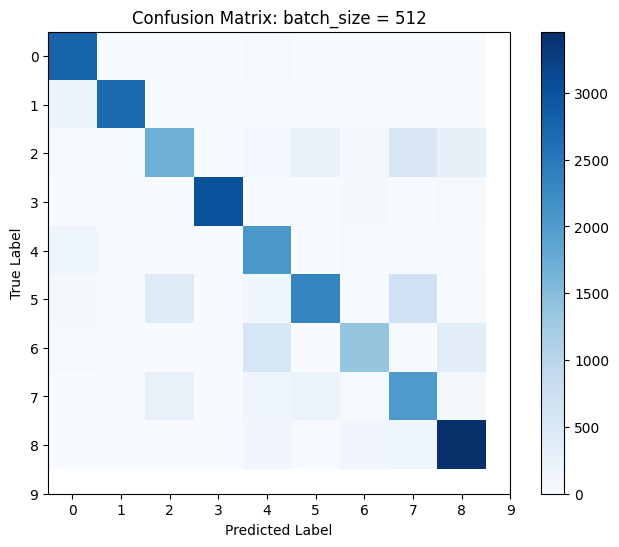

Classification Report:
              precision    recall  f1-score   support

           0     0.8508    0.9868    0.9137      2796
           1     0.9476    0.9286    0.9380      2885
           2     0.7081    0.5695    0.6313      2999
           3     0.9820    0.9622    0.9720      3124
           4     0.6536    0.8671    0.7454      2392
           5     0.8226    0.6267    0.7114      3713
           6     0.8006    0.5791    0.6721      2371
           7     0.5840    0.7240    0.6465      2804
           8     0.8109    0.8830    0.8454      3915

    accuracy                         0.7931     26999
   macro avg     0.7956    0.7919    0.7862     26999
weighted avg     0.8012    0.7931    0.7901     26999



In [ ]:
from itertools import product

fixed_params = {
    'conv_kernel_size': 5,
    'conv_dropout': 0.2,
    'activation_fn': 'relu',  #the best solution of the activation_fn test
    'batch_size': 64,
    'optimizer_type': 'adam',
    'num_conv_layers': 2,
    'fc_hidden_units': 128,
    'pool_kernel_size': 2,
    'pool_stride': 2,
    'fc_dropout': 0.3,
    'num_epochs': 10
}

batch_size = [16, 32, 64, 128, 256, 512]
criterion = nn.CrossEntropyLoss()

for val in batch_size:
    print(f"\n--- Testing batch_size = {val} ---")

    current_params = fixed_params.copy()
    current_params['batch_size'] = val
    batch_size = current_params['batch_size']

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    try:
        model = PathMNIST_CNN(
            conv_kernel_size=current_params['conv_kernel_size'],
            conv_dropout=current_params['conv_dropout'],
            activation_fn=current_params['activation_fn'],
            num_conv_layers=current_params['num_conv_layers'],
            fc_hidden_units=current_params['fc_hidden_units'],
            pool_kernel_size=current_params['pool_kernel_size'],
            pool_stride=current_params['pool_stride'],
            fc_dropout=current_params['fc_dropout']
        ).to(device)
    except Exception as e:
        print(f"[SKIPPED] Hata oluştu: {e} → num_conv_layers = {val}")
        continue

    if current_params['optimizer_type'] == 'adam':
        optimizer = optim.Adam(model.parameters())
    elif current_params['optimizer_type'] == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    else:
        optimizer = optim.RMSprop(model.parameters())

    train_losses, val_losses, val_accuracies, train_accuracies, preds, labels = train_and_validate(
        model, train_loader, val_loader, optimizer, criterion, epochs=current_params['num_epochs'])

    print(f"Train Accuracy: {train_accuracies[-1]:.2f}%")
    print(f"Validation Accuracy: {val_accuracies[-1]:.2f}%")

    # Plot Loss
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Loss Curve: batch_size = {val}')
    plt.legend()
    plt.show()

    # Plot Accuracy
    plt.figure(figsize=(8, 5))
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy Curve: batch_size = {val}')
    plt.legend()
    plt.show()

    # Confusion Matrix
    cm = confusion_matrix(labels, preds.argmax(dim=1))
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix: batch_size = {val}")
    plt.colorbar()
    tick_marks = np.arange(10)
    plt.xticks(tick_marks, tick_marks)
    plt.yticks(tick_marks, tick_marks)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    # Classification Report
    print("Classification Report:")
    print(classification_report(labels, preds.argmax(dim=1), digits=4))



--- Testing optimizer_type = adam ---
Train Accuracy: 88.45%
Validation Accuracy: 88.88%


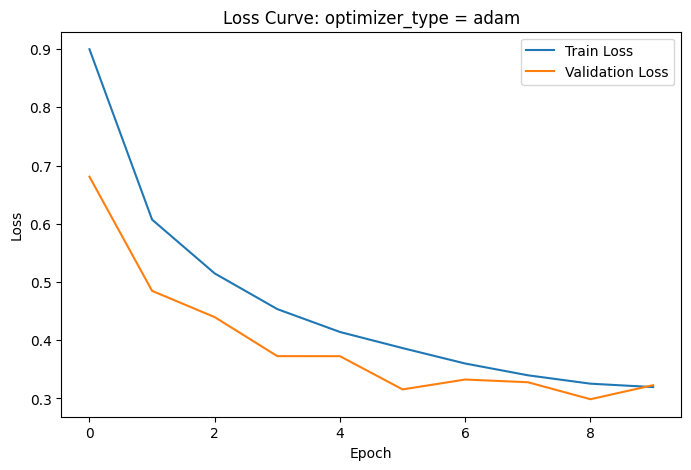

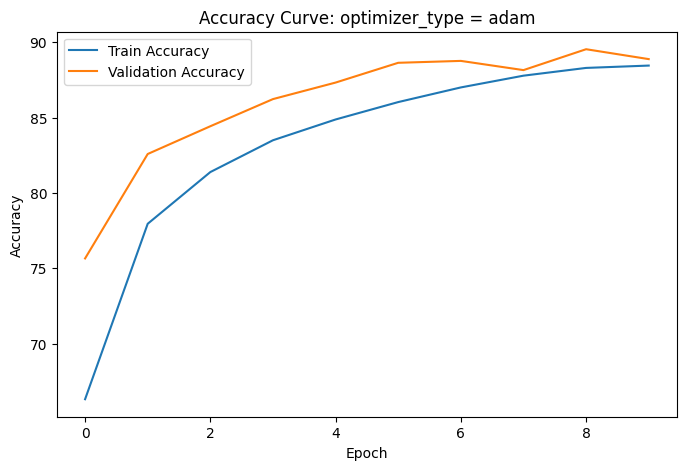

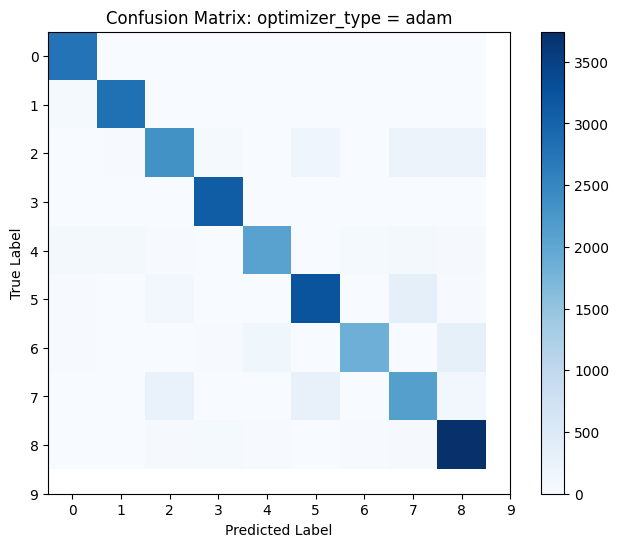

Classification Report:
              precision    recall  f1-score   support

           0     0.9363    0.9889    0.9619      2796
           1     0.9569    0.9768    0.9667      2885
           2     0.8442    0.7786    0.8101      2999
           3     0.9599    0.9885    0.9740      3124
           4     0.9068    0.8620    0.8838      2392
           5     0.8749    0.8667    0.8708      3713
           6     0.9483    0.7807    0.8563      2371
           7     0.7620    0.7546    0.7583      2804
           8     0.8436    0.9561    0.8963      3915

    accuracy                         0.8888     26999
   macro avg     0.8925    0.8837    0.8865     26999
weighted avg     0.8894    0.8888    0.8876     26999


--- Testing optimizer_type = sgd ---
Train Accuracy: 84.61%
Validation Accuracy: 85.52%


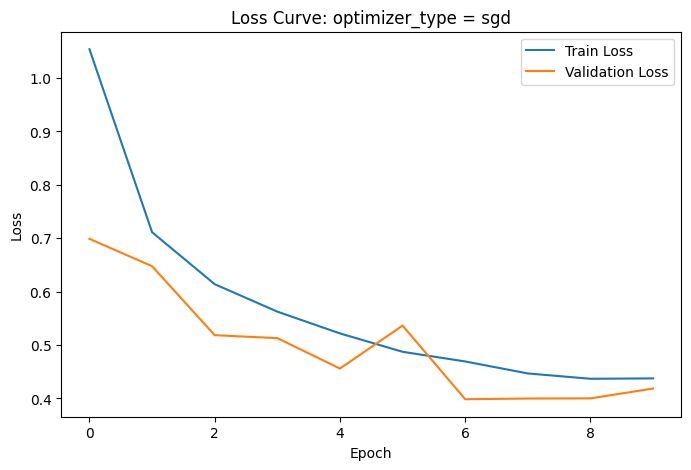

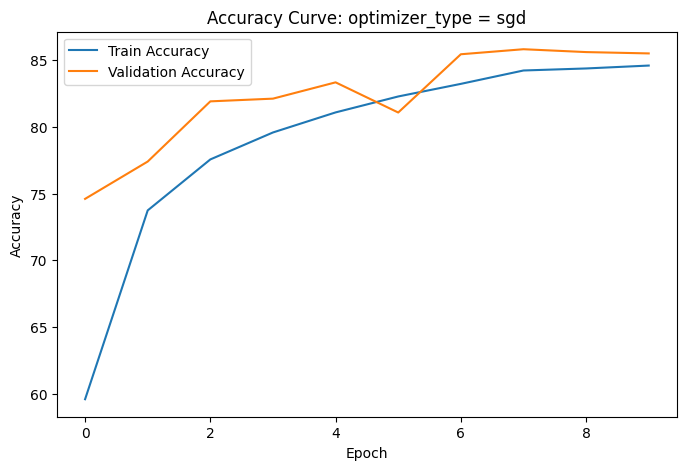

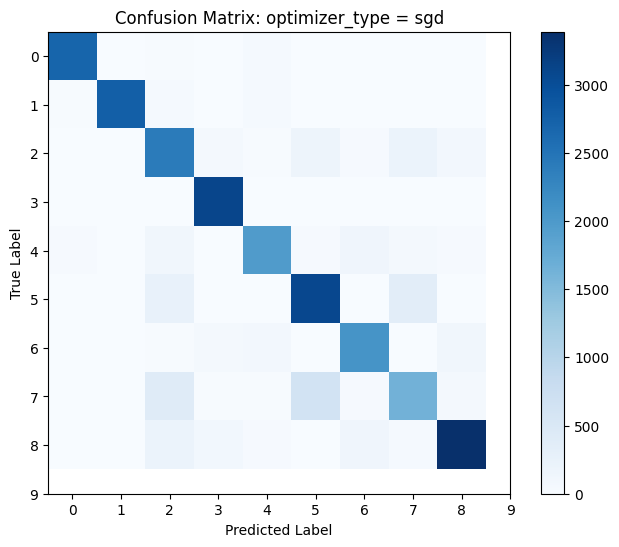

Classification Report:
              precision    recall  f1-score   support

           0     0.9726    0.9642    0.9684      2796
           1     0.9907    0.9591    0.9746      2885
           2     0.6947    0.8013    0.7442      2999
           3     0.9148    0.9933    0.9524      3124
           4     0.8853    0.8194    0.8511      2392
           5     0.7822    0.8271    0.8040      3713
           6     0.8476    0.8705    0.8589      2371
           7     0.7063    0.5842    0.6395      2804
           8     0.9181    0.8651    0.8908      3915

    accuracy                         0.8552     26999
   macro avg     0.8569    0.8538    0.8538     26999
weighted avg     0.8565    0.8552    0.8543     26999


--- Testing optimizer_type = rmsprop ---
Train Accuracy: 49.08%
Validation Accuracy: 51.66%


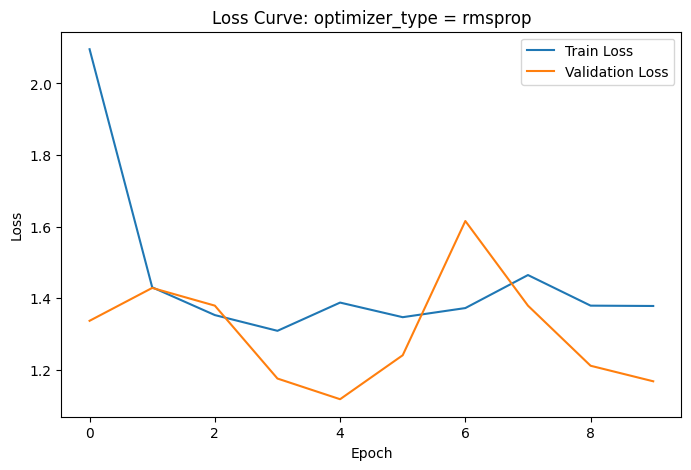

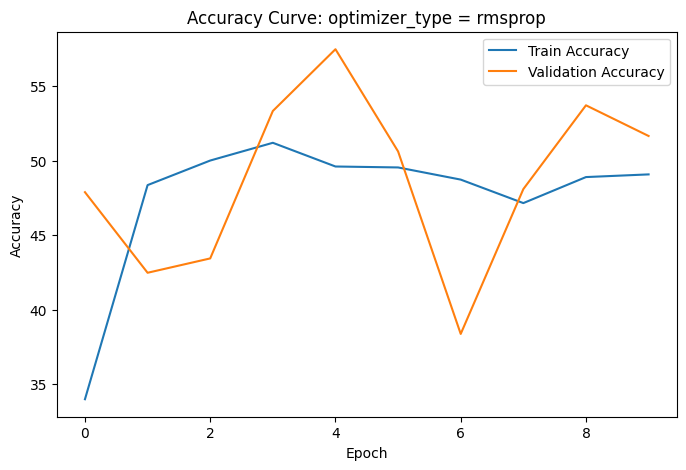

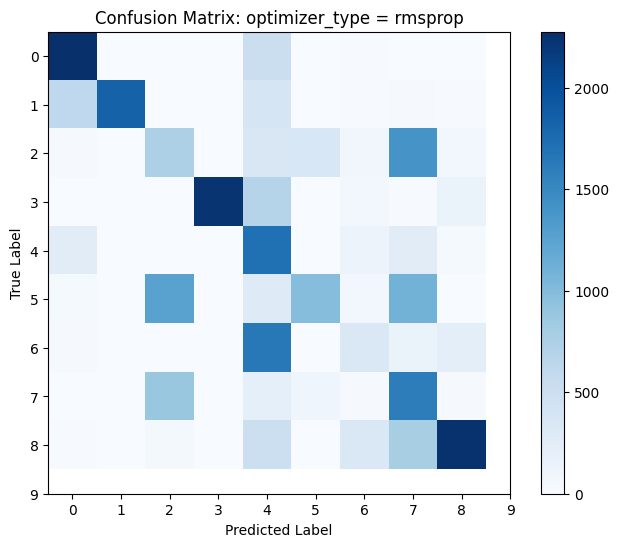

Classification Report:
              precision    recall  f1-score   support

           0     0.7057    0.8140    0.7560      2796
           1     0.9919    0.6378    0.7764      2885
           2     0.2533    0.2467    0.2500      2999
           3     0.9915    0.7116    0.8286      3124
           4     0.2749    0.7166    0.3974      2392
           5     0.6876    0.2656    0.3831      3713
           6     0.3110    0.1354    0.1887      2371
           7     0.3016    0.5681    0.3940      2804
           8     0.8125    0.5757    0.6739      3915

    accuracy                         0.5166     26999
   macro avg     0.5922    0.5191    0.5165     26999
weighted avg     0.6173    0.5166    0.5280     26999



In [ ]:
from itertools import product

fixed_params = {
    'conv_kernel_size': 3,
    'conv_dropout': 0.2,
    'activation_fn': 'relu',
    'batch_size': 16,
    'optimizer_type': 'adam',
    'num_conv_layers': 2,
    'fc_hidden_units': 128,
    'pool_kernel_size': 2,
    'pool_stride': 2,
    'fc_dropout': 0.3,
    'num_epochs': 10
}
optimizer_type = ['adam', 'sgd', 'rmsprop']
criterion = nn.CrossEntropyLoss()

for val in optimizer_type:
    print(f"\n--- Testing optimizer_type = {val} ---")

    current_params = fixed_params.copy()
    current_params['optimizer_type'] = val
    batch_size = current_params['batch_size']

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    try:
        model = PathMNIST_CNN(
            conv_kernel_size=current_params['conv_kernel_size'],
            conv_dropout=current_params['conv_dropout'],
            activation_fn=current_params['activation_fn'],
            num_conv_layers=current_params['num_conv_layers'],
            fc_hidden_units=current_params['fc_hidden_units'],
            pool_kernel_size=current_params['pool_kernel_size'],
            pool_stride=current_params['pool_stride'],
            fc_dropout=current_params['fc_dropout']
        ).to(device)
    except Exception as e:
        print(f"[SKIPPED] Hata oluştu: {e} → num_conv_layers = {val}")
        continue

    if current_params['optimizer_type'] == 'adam':
        optimizer = optim.Adam(model.parameters())
    elif current_params['optimizer_type'] == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    else:
        optimizer = optim.RMSprop(model.parameters())

    train_losses, val_losses, val_accuracies, train_accuracies, preds, labels = train_and_validate(
        model, train_loader, val_loader, optimizer, criterion, epochs=current_params['num_epochs'])

    print(f"Train Accuracy: {train_accuracies[-1]:.2f}%")
    print(f"Validation Accuracy: {val_accuracies[-1]:.2f}%")

    # Plot Loss
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Loss Curve: optimizer_type = {val}')
    plt.legend()
    plt.show()

    # Plot Accuracy
    plt.figure(figsize=(8, 5))
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy Curve: optimizer_type = {val}')
    plt.legend()
    plt.show()

    # Confusion Matrix
    cm = confusion_matrix(labels, preds.argmax(dim=1))
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix: optimizer_type = {val}")
    plt.colorbar()
    tick_marks = np.arange(10)
    plt.xticks(tick_marks, tick_marks)
    plt.yticks(tick_marks, tick_marks)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    # Classification Report
    print("Classification Report:")
    print(classification_report(labels, preds.argmax(dim=1), digits=4))



--- Testing num_conv_layers = 1 ---
Train Accuracy: 82.16%
Validation Accuracy: 80.52%


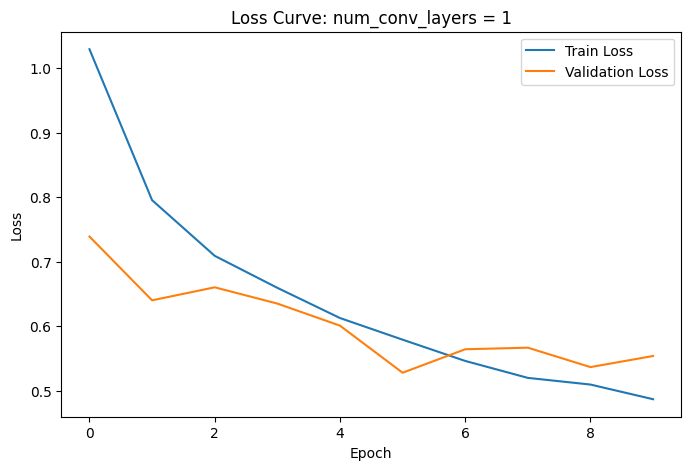

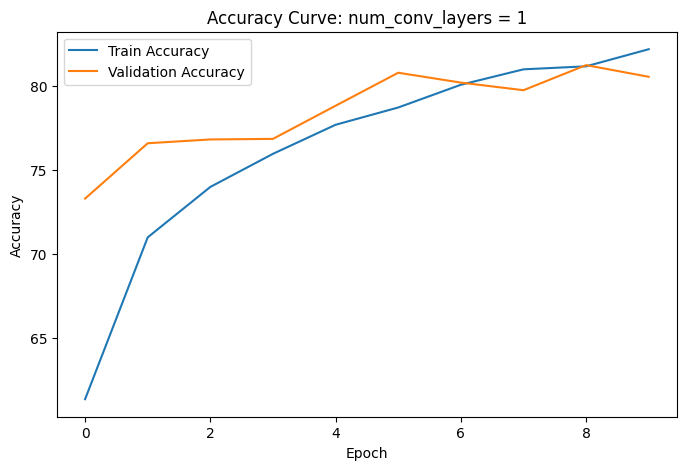

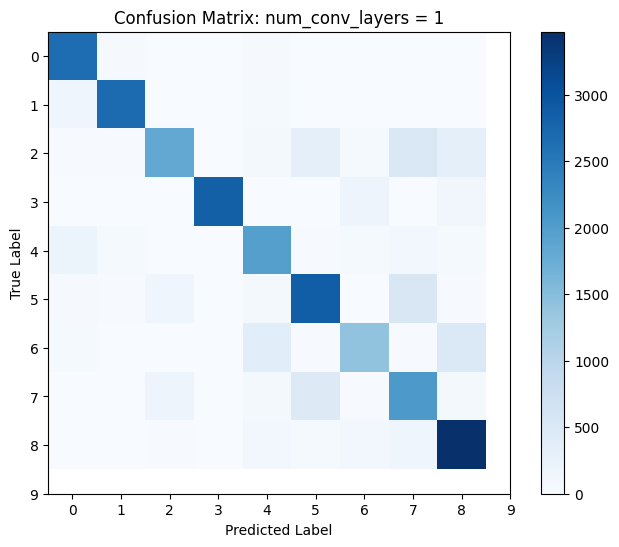

Classification Report:
              precision    recall  f1-score   support

           0     0.8617    0.9750    0.9149      2722
           1     0.9534    0.9331    0.9431      2870
           2     0.8370    0.5845    0.6883      3119
           3     0.9940    0.9056    0.9477      3124
           4     0.7293    0.8066    0.7660      2435
           5     0.7693    0.7836    0.7764      3642
           6     0.7815    0.5986    0.6779      2349
           7     0.6124    0.7250    0.6640      2840
           8     0.7680    0.8910    0.8249      3898

    accuracy                         0.8052     26999
   macro avg     0.8119    0.8003    0.8004     26999
weighted avg     0.8128    0.8052    0.8034     26999


--- Testing num_conv_layers = 2 ---
Train Accuracy: 87.48%
Validation Accuracy: 85.61%


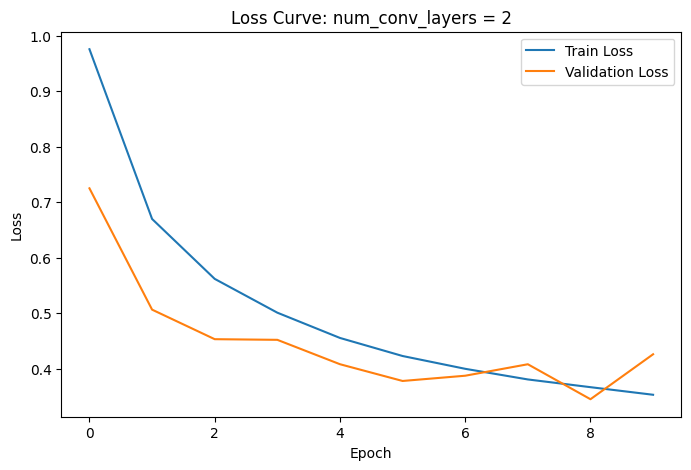

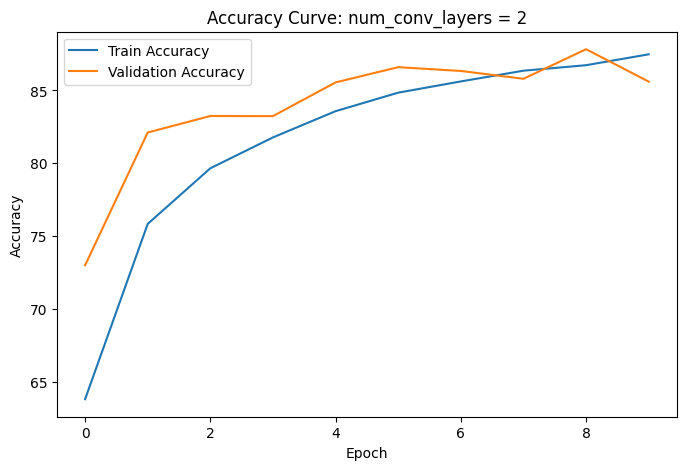

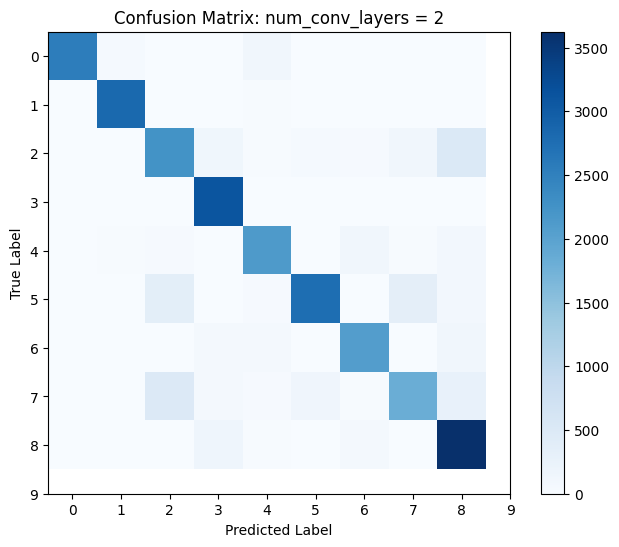

Classification Report:
              precision    recall  f1-score   support

           0     0.9887    0.9339    0.9605      2722
           1     0.9678    0.9843    0.9760      2870
           2     0.7114    0.7175    0.7144      3119
           3     0.8662    0.9968    0.9269      3124
           4     0.8690    0.8743    0.8716      2435
           5     0.9312    0.7576    0.8354      3642
           6     0.8830    0.8804    0.8817      2349
           7     0.7821    0.6384    0.7030      2840
           8     0.7721    0.9300    0.8437      3898

    accuracy                         0.8561     26999
   macro avg     0.8635    0.8570    0.8570     26999
weighted avg     0.8595    0.8561    0.8541     26999


--- Testing num_conv_layers = 3 ---
Train Accuracy: 86.52%
Validation Accuracy: 87.49%


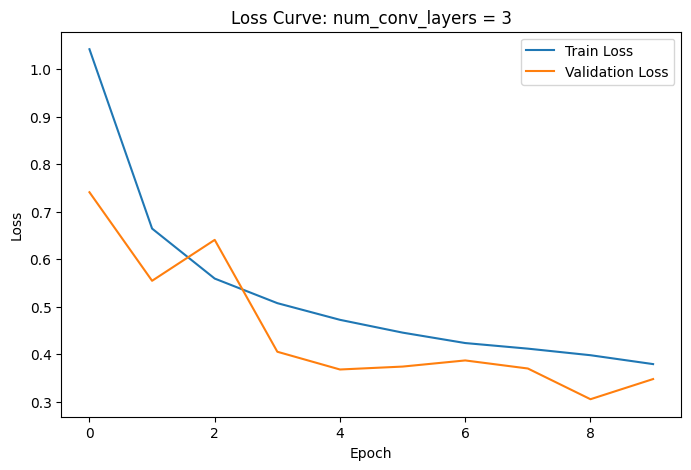

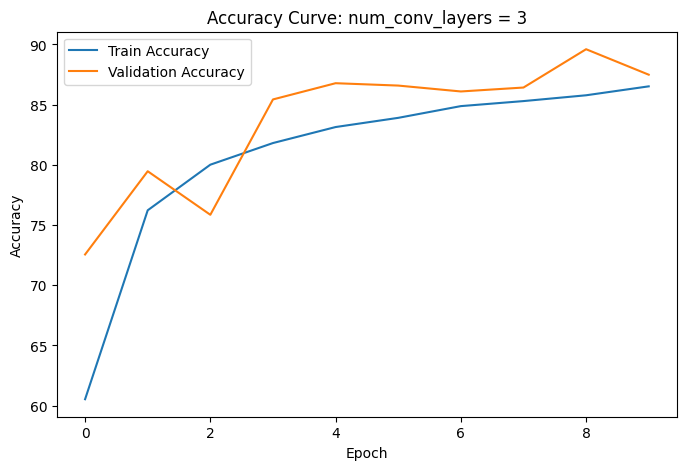

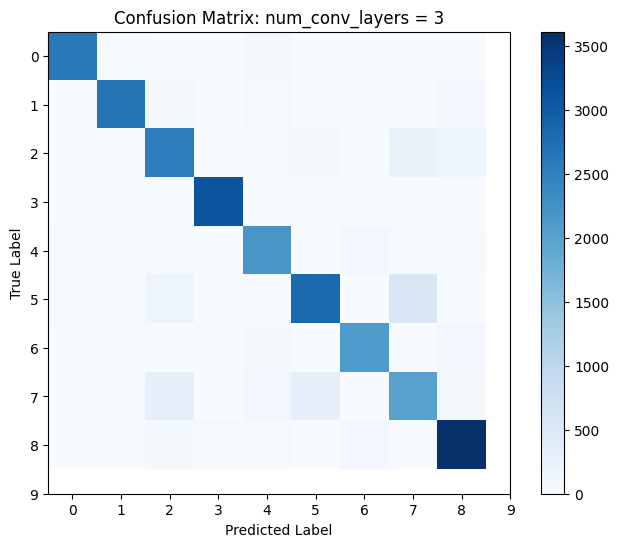

Classification Report:
              precision    recall  f1-score   support

           0     0.9756    0.9530    0.9641      2722
           1     0.9693    0.9251    0.9467      2870
           2     0.7849    0.8140    0.7992      3119
           3     0.9657    0.9923    0.9788      3124
           4     0.8463    0.8957    0.8703      2435
           5     0.8706    0.7740    0.8195      3642
           6     0.9011    0.9038    0.9024      2349
           7     0.7009    0.7032    0.7021      2840
           8     0.8735    0.9269    0.8994      3898

    accuracy                         0.8749     26999
   macro avg     0.8764    0.8764    0.8758     26999
weighted avg     0.8758    0.8749    0.8747     26999


--- Testing num_conv_layers = 4 ---
Train Accuracy: 83.75%
Validation Accuracy: 85.91%


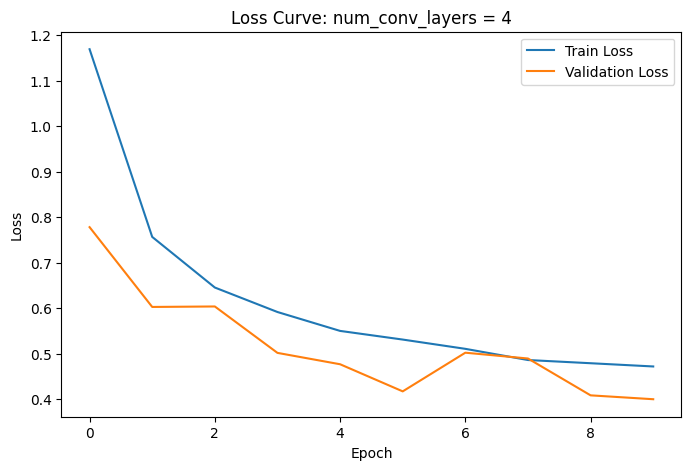

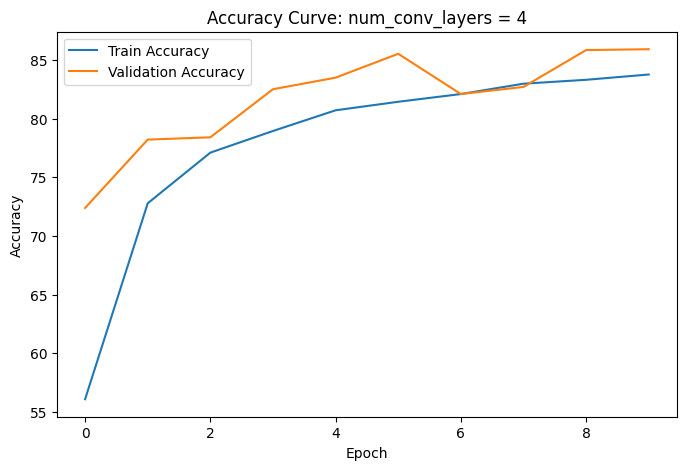

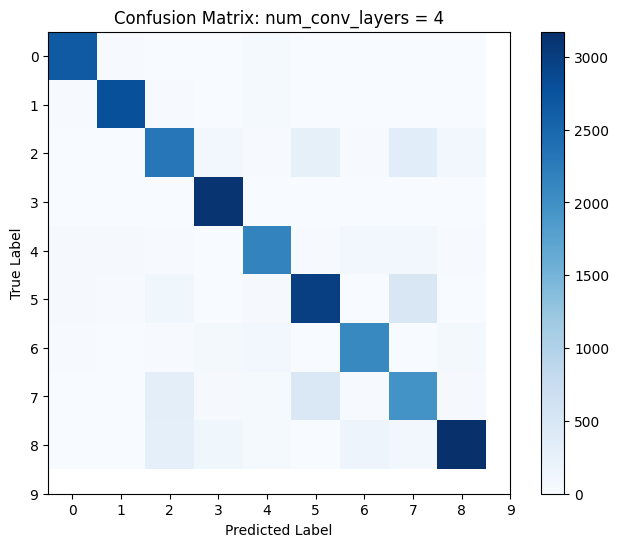

Classification Report:
              precision    recall  f1-score   support

           0     0.9589    0.9776    0.9682      2722
           1     0.9747    0.9679    0.9713      2870
           2     0.7466    0.7358    0.7412      3119
           3     0.9132    0.9936    0.9517      3124
           4     0.8720    0.8842    0.8781      2435
           5     0.8018    0.8174    0.8095      3642
           6     0.8852    0.8893    0.8872      2349
           7     0.6585    0.6919    0.6748      2840
           8     0.9399    0.8138    0.8723      3898

    accuracy                         0.8591     26999
   macro avg     0.8612    0.8635    0.8616     26999
weighted avg     0.8610    0.8591    0.8591     26999


--- Testing num_conv_layers = 5 ---
[SKIPPED] Hata oluştu: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small → num_conv_layers = 5

--- Testing num_conv_layers = 6 ---
[SKIPPED] Hata oluştu: Given input size: (32x1x1). Calculated outp

In [ ]:
from itertools import product

fixed_params = {
    'conv_kernel_size': 5,
    'conv_dropout': 0.2,
    'activation_fn': 'relu',
    'batch_size': 16,
    'optimizer_type': 'adam',
    'num_conv_layers': 2,
    'fc_hidden_units': 128,
    'pool_kernel_size': 2,
    'pool_stride': 2,
    'fc_dropout': 0.3,
    'num_epochs': 10
}

conv_layer_values = [1, 2, 3, 4, 5, 6]
criterion = nn.CrossEntropyLoss()

for val in conv_layer_values:
    print(f"\n--- Testing num_conv_layers = {val} ---")

    current_params = fixed_params.copy()
    current_params['num_conv_layers'] = val
    batch_size = current_params['batch_size']

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    try:
        model = PathMNIST_CNN(
            conv_kernel_size=current_params['conv_kernel_size'],
            conv_dropout=current_params['conv_dropout'],
            activation_fn=current_params['activation_fn'],
            num_conv_layers=current_params['num_conv_layers'],
            fc_hidden_units=current_params['fc_hidden_units'],
            pool_kernel_size=current_params['pool_kernel_size'],
            pool_stride=current_params['pool_stride'],
            fc_dropout=current_params['fc_dropout']
        ).to(device)
    except Exception as e:
        print(f"[SKIPPED] Hata oluştu: {e} → num_conv_layers = {val}")
        continue

    if current_params['optimizer_type'] == 'adam':
        optimizer = optim.Adam(model.parameters())
    elif current_params['optimizer_type'] == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    else:
        optimizer = optim.RMSprop(model.parameters())

    train_losses, val_losses, val_accuracies, train_accuracies, preds, labels = train_and_validate(
        model, train_loader, val_loader, optimizer, criterion, epochs=current_params['num_epochs'])

    print(f"Train Accuracy: {train_accuracies[-1]:.2f}%")
    print(f"Validation Accuracy: {val_accuracies[-1]:.2f}%")

    # Plot Loss
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Loss Curve: num_conv_layers = {val}')
    plt.legend()
    plt.show()

    # Plot Accuracy
    plt.figure(figsize=(8, 5))
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy Curve: num_conv_layers = {val}')
    plt.legend()
    plt.show()

    # Confusion Matrix
    cm = confusion_matrix(labels, preds.argmax(dim=1))
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix: num_conv_layers = {val}")
    plt.colorbar()
    tick_marks = np.arange(10)
    plt.xticks(tick_marks, tick_marks)
    plt.yticks(tick_marks, tick_marks)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    # Classification Report
    print("Classification Report:")
    print(classification_report(labels, preds.argmax(dim=1), digits=4))



--- Testing fc_hidden_units = 64 ---
Train Accuracy: 86.32%
Validation Accuracy: 89.40%


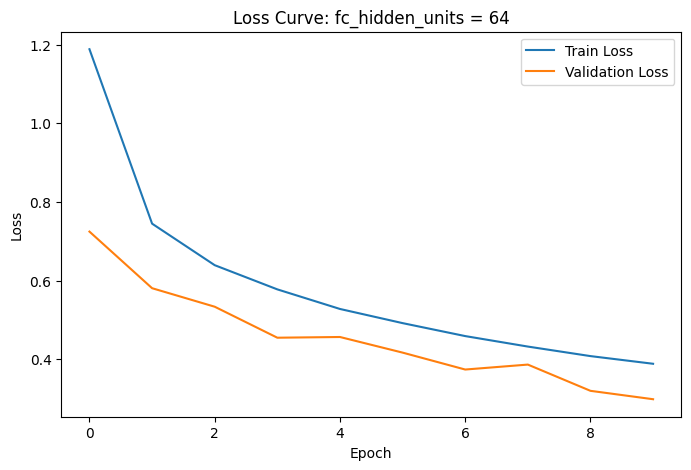

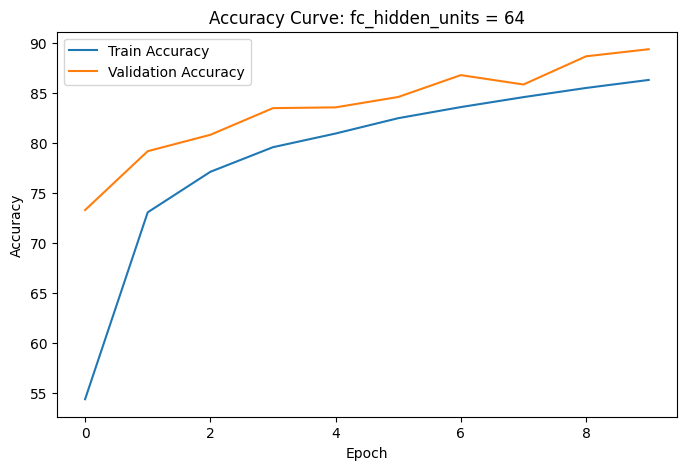

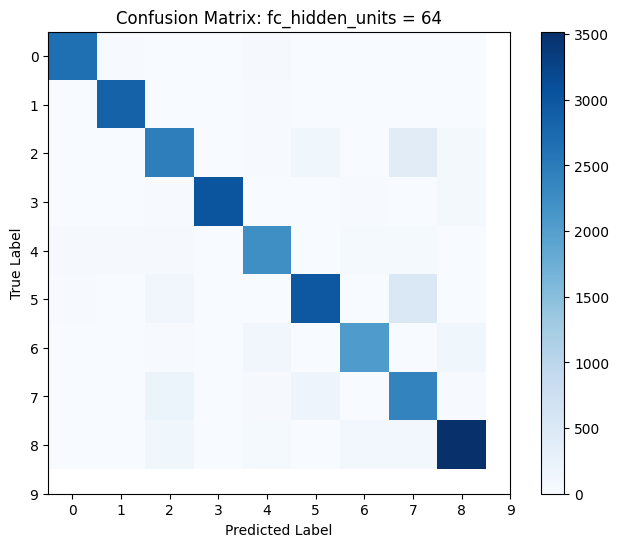

Classification Report:
              precision    recall  f1-score   support

           0     0.9740    0.9776    0.9758      2722
           1     0.9739    0.9868    0.9803      2870
           2     0.8194    0.7884    0.8036      3119
           3     0.9921    0.9657    0.9788      3124
           4     0.8885    0.9166    0.9024      2435
           5     0.9043    0.8169    0.8583      3642
           6     0.9136    0.8736    0.8931      2349
           7     0.6952    0.8415    0.7614      2840
           8     0.9183    0.9025    0.9103      3898

    accuracy                         0.8940     26999
   macro avg     0.8977    0.8966    0.8960     26999
weighted avg     0.8985    0.8940    0.8951     26999


--- Testing fc_hidden_units = 128 ---
Train Accuracy: 86.50%
Validation Accuracy: 90.13%


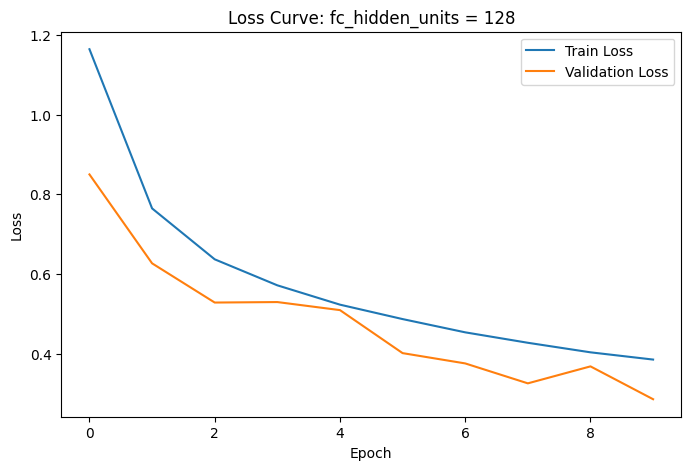

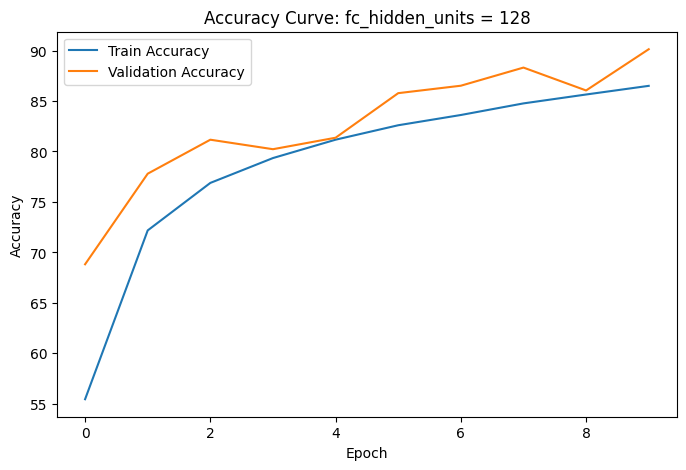

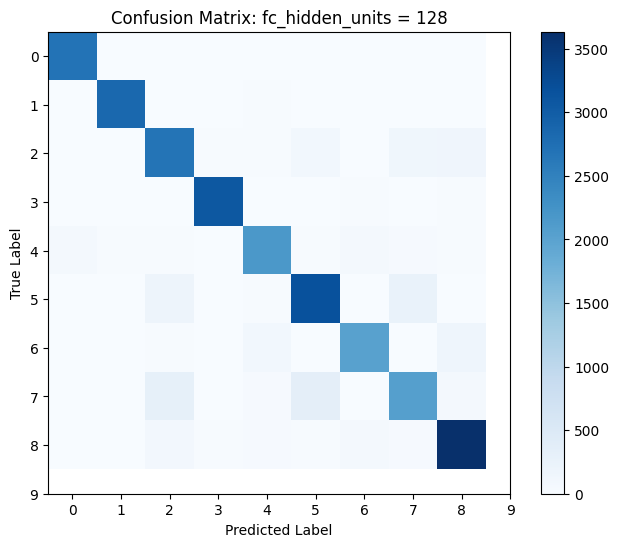

Classification Report:
              precision    recall  f1-score   support

           0     0.9632    0.9901    0.9764      2722
           1     0.9820    0.9909    0.9865      2870
           2     0.8078    0.8557    0.8311      3119
           3     0.9812    0.9843    0.9827      3124
           4     0.8957    0.8891    0.8924      2435
           5     0.8603    0.8723    0.8663      3642
           6     0.9213    0.8616    0.8905      2349
           7     0.8178    0.7222    0.7670      2840
           8     0.8968    0.9323    0.9142      3898

    accuracy                         0.9013     26999
   macro avg     0.9029    0.8998    0.9008     26999
weighted avg     0.9008    0.9013    0.9005     26999


--- Testing fc_hidden_units = 256 ---
Train Accuracy: 88.00%
Validation Accuracy: 90.38%


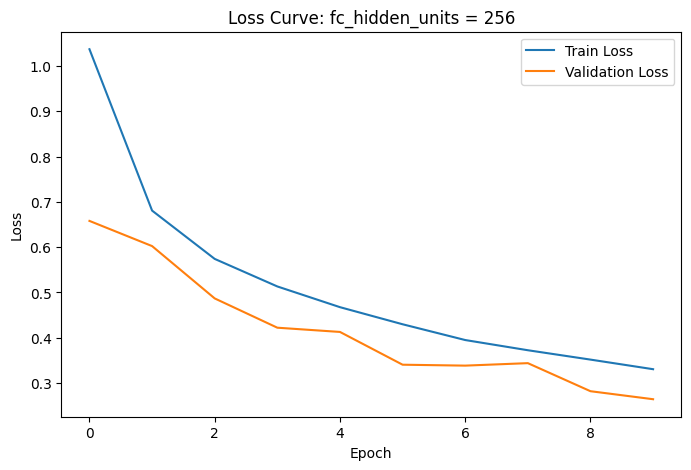

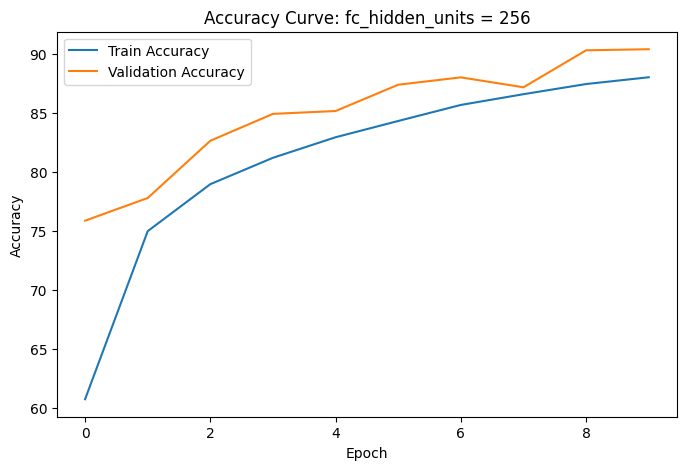

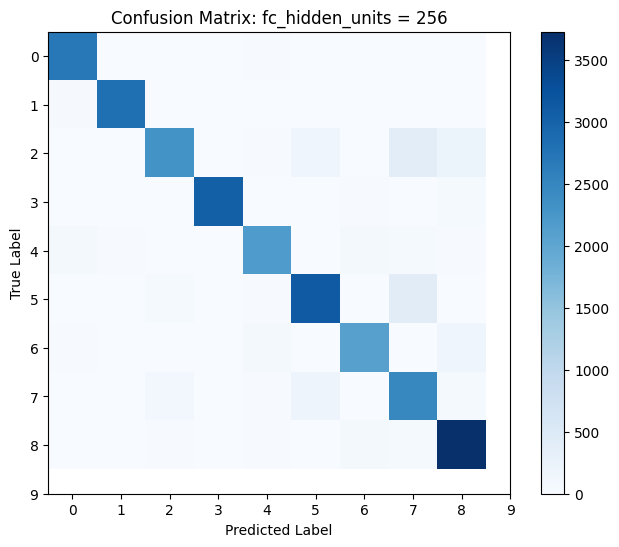

Classification Report:
              precision    recall  f1-score   support

           0     0.9541    0.9846    0.9691      2722
           1     0.9819    0.9815    0.9817      2870
           2     0.9173    0.7393    0.8187      3119
           3     0.9954    0.9718    0.9835      3124
           4     0.9158    0.8936    0.9046      2435
           5     0.8945    0.8567    0.8752      3642
           6     0.9196    0.8863    0.9027      2349
           7     0.7282    0.8662    0.7913      2840
           8     0.8763    0.9556    0.9142      3898

    accuracy                         0.9038     26999
   macro avg     0.9092    0.9040    0.9045     26999
weighted avg     0.9081    0.9038    0.9038     26999


--- Testing fc_hidden_units = 512 ---
Train Accuracy: 89.28%
Validation Accuracy: 91.63%


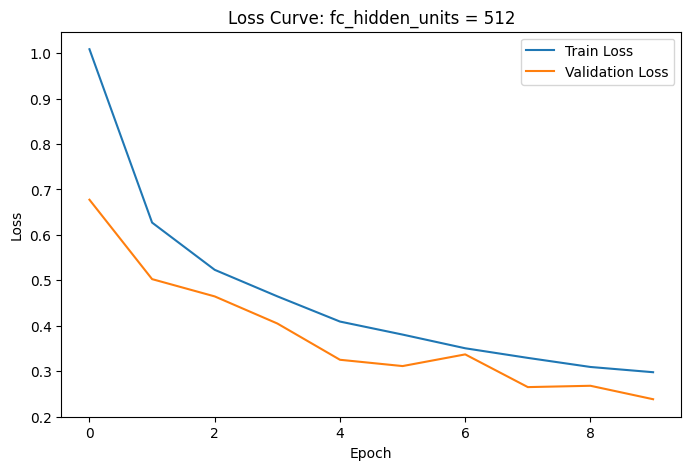

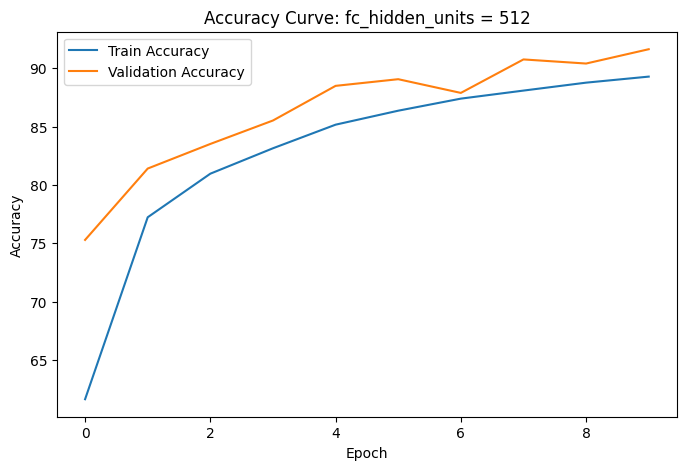

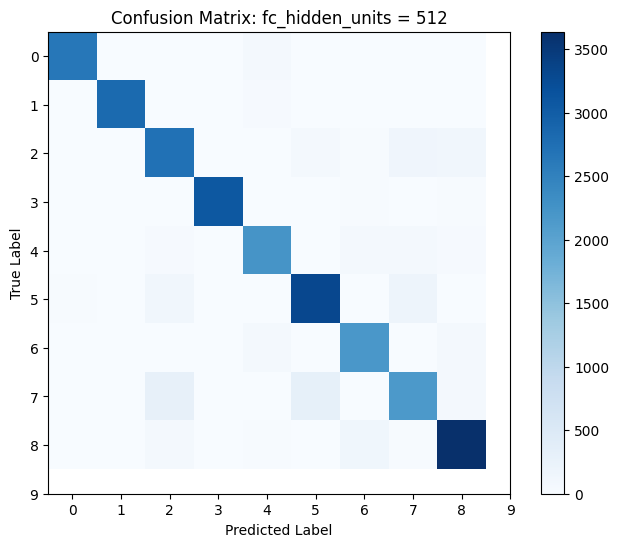

Classification Report:
              precision    recall  f1-score   support

           0     0.9873    0.9680    0.9776      2722
           1     0.9919    0.9843    0.9881      2870
           2     0.8351    0.8721    0.8532      3119
           3     0.9865    0.9821    0.9843      3124
           4     0.9100    0.9138    0.9119      2435
           5     0.8884    0.9069    0.8976      3642
           6     0.9012    0.9285    0.9147      2349
           7     0.8405    0.7553    0.7956      2840
           8     0.9136    0.9328    0.9231      3898

    accuracy                         0.9163     26999
   macro avg     0.9172    0.9160    0.9162     26999
weighted avg     0.9162    0.9163    0.9159     26999


--- Testing fc_hidden_units = 1024 ---
Train Accuracy: 89.16%
Validation Accuracy: 90.41%


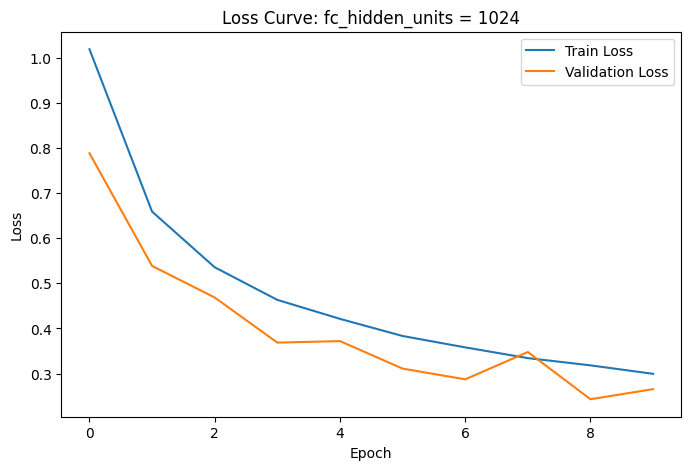

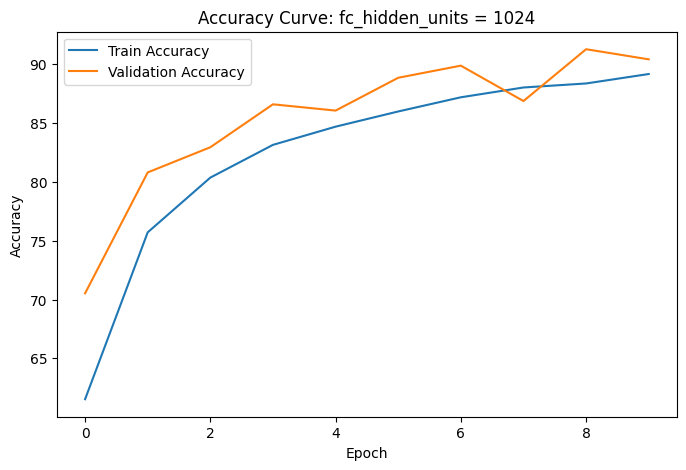

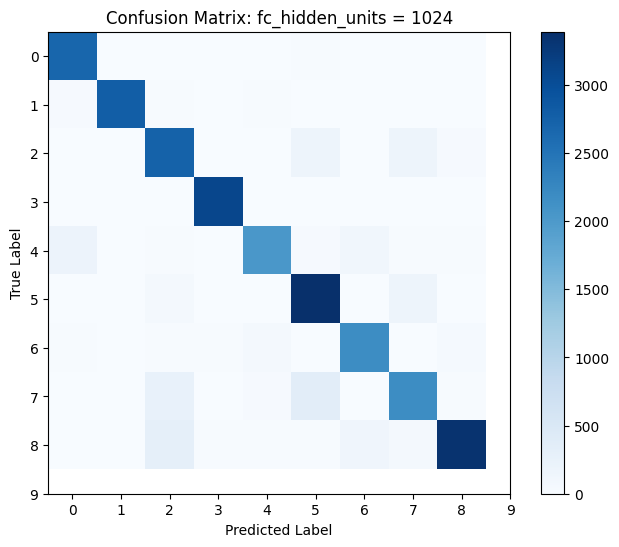

Classification Report:
              precision    recall  f1-score   support

           0     0.9120    0.9827    0.9461      2722
           1     0.9908    0.9735    0.9821      2870
           2     0.7968    0.8750    0.8340      3119
           3     0.9822    0.9882    0.9852      3124
           4     0.9307    0.8329    0.8791      2435
           5     0.8533    0.9308    0.8903      3642
           6     0.8862    0.9285    0.9069      2349
           7     0.8385    0.7680    0.8017      2840
           8     0.9656    0.8581    0.9087      3898

    accuracy                         0.9041     26999
   macro avg     0.9062    0.9042    0.9038     26999
weighted avg     0.9067    0.9041    0.9039     26999


--- Testing fc_hidden_units = 2048 ---
Train Accuracy: 88.91%
Validation Accuracy: 90.54%


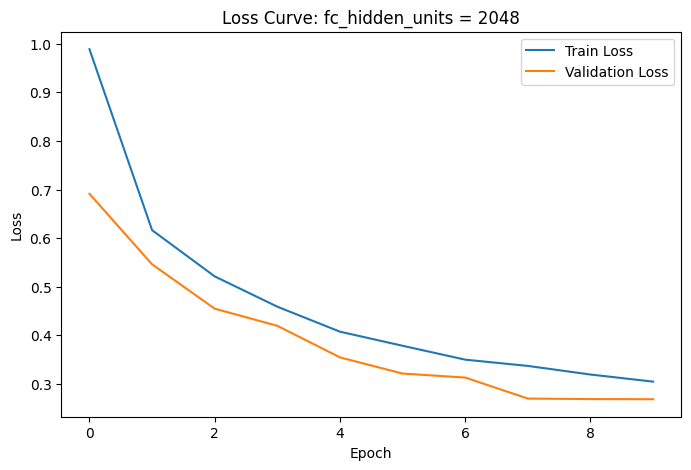

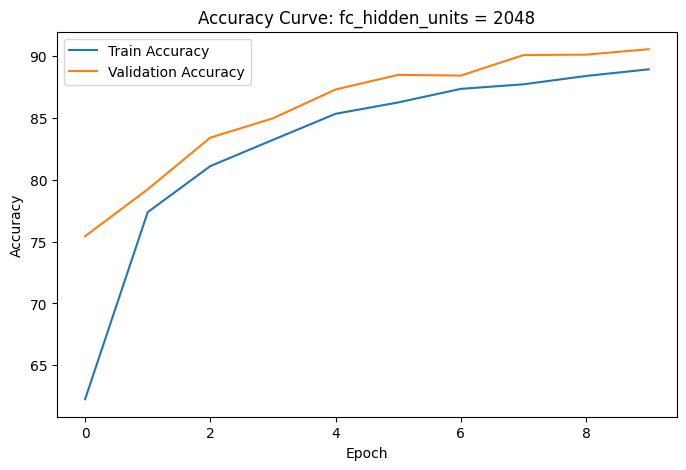

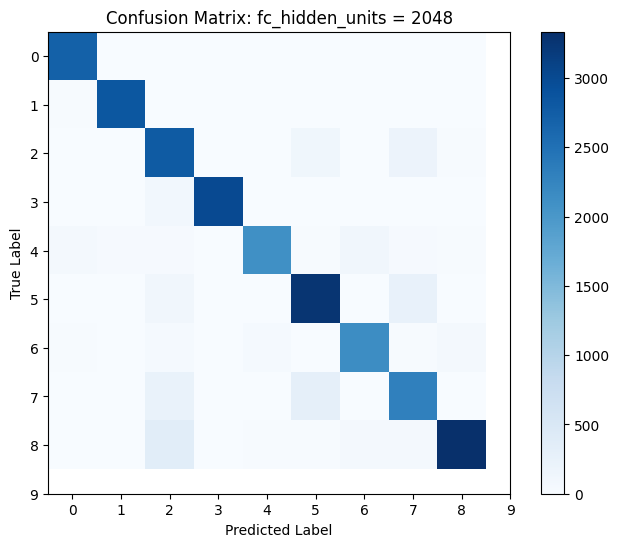

Classification Report:
              precision    recall  f1-score   support

           0     0.9547    0.9912    0.9726      2722
           1     0.9861    0.9854    0.9857      2870
           2     0.7592    0.8897    0.8193      3119
           3     0.9931    0.9616    0.9771      3124
           4     0.9482    0.8653    0.9049      2435
           5     0.8742    0.8946    0.8842      3642
           6     0.9131    0.9127    0.9129      2349
           7     0.7945    0.8085    0.8014      2840
           8     0.9697    0.8553    0.9089      3898

    accuracy                         0.9054     26999
   macro avg     0.9103    0.9071    0.9075     26999
weighted avg     0.9101    0.9054    0.9064     26999



In [ ]:
fixed_params = {
    'conv_kernel_size': 3,
    'conv_dropout': 0.2,
    'activation_fn': 'relu',
    'batch_size': 64,
    'optimizer_type': 'adam',
    'num_conv_layers': 3,
    'fc_hidden_units': 128,
    'pool_kernel_size': 2,
    'pool_stride': 2,
    'fc_dropout': 0.3,
    'num_epochs': 10
}

fc_hidden_units = [64, 128, 256, 512, 1024, 2048]
criterion = nn.CrossEntropyLoss()

for val in fc_hidden_units:
    print(f"\n--- Testing fc_hidden_units = {val} ---")

    current_params = fixed_params.copy()
    current_params['fc_hidden_units'] = val
    batch_size = current_params['batch_size']

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    try:
        model = PathMNIST_CNN(
            conv_kernel_size=current_params['conv_kernel_size'],
            conv_dropout=current_params['conv_dropout'],
            activation_fn=current_params['activation_fn'],
            num_conv_layers=current_params['num_conv_layers'],
            fc_hidden_units=current_params['fc_hidden_units'],
            pool_kernel_size=current_params['pool_kernel_size'],
            pool_stride=current_params['pool_stride'],
            fc_dropout=current_params['fc_dropout']
        ).to(device)
    except Exception as e:
        print(f"[SKIPPED] Hata oluştu: {e} → fc_hidden_units = {val}")
        continue

    if current_params['optimizer_type'] == 'adam':
        optimizer = optim.Adam(model.parameters())
    elif current_params['optimizer_type'] == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    else:
        optimizer = optim.RMSprop(model.parameters())

    train_losses, val_losses, val_accuracies, train_accuracies, preds, labels = train_and_validate(
        model, train_loader, val_loader, optimizer, criterion, epochs=current_params['num_epochs'])

    print(f"Train Accuracy: {train_accuracies[-1]:.2f}%")
    print(f"Validation Accuracy: {val_accuracies[-1]:.2f}%")

    # Plot Loss
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Loss Curve: fc_hidden_units = {val}')
    plt.legend()
    plt.show()

    # Plot Accuracy
    plt.figure(figsize=(8, 5))
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy Curve: fc_hidden_units = {val}')
    plt.legend()
    plt.show()

    # Confusion Matrix
    cm = confusion_matrix(labels, preds.argmax(dim=1))
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix: fc_hidden_units = {val}")
    plt.colorbar()
    tick_marks = np.arange(10)
    plt.xticks(tick_marks, tick_marks)
    plt.yticks(tick_marks, tick_marks)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    # Classification Report
    print("Classification Report:")
    print(classification_report(labels, preds.argmax(dim=1), digits=4))


--- Testing pool_kernel_size = 2 ---
Train Accuracy: 91.35%
Validation Accuracy: 92.13%


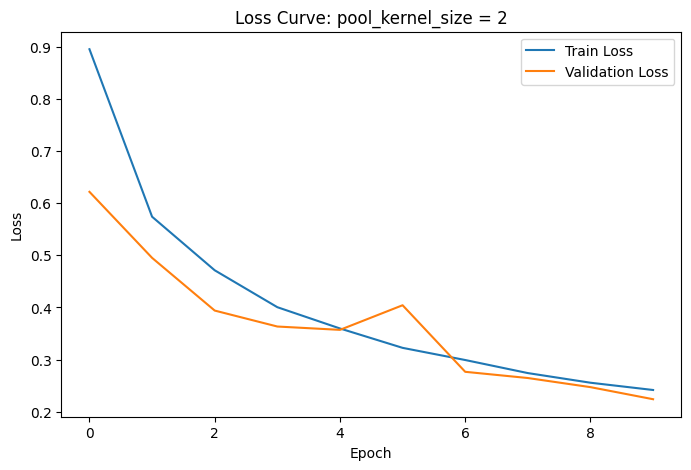

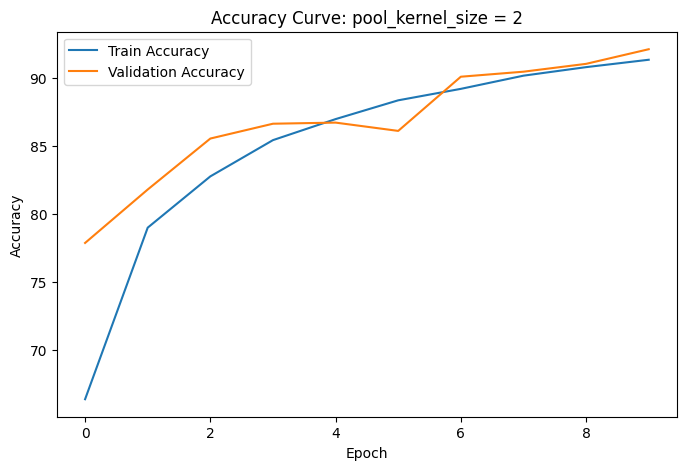

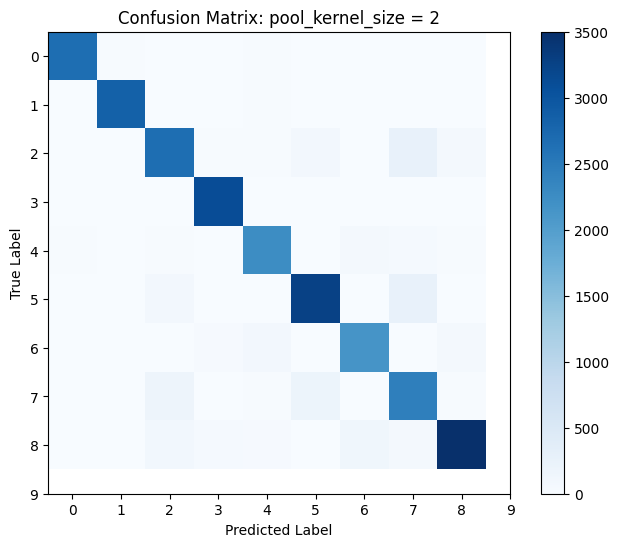

Classification Report:
              precision    recall  f1-score   support

           0     0.9856    0.9805    0.9831      2722
           1     0.9851    0.9889    0.9870      2870
           2     0.8694    0.8519    0.8606      3119
           3     0.9673    0.9949    0.9809      3124
           4     0.9176    0.9232    0.9204      2435
           5     0.9177    0.8968    0.9071      3642
           6     0.8980    0.9144    0.9061      2349
           7     0.7987    0.8577    0.8272      2840
           8     0.9496    0.8989    0.9236      3898

    accuracy                         0.9213     26999
   macro avg     0.9210    0.9230    0.9218     26999
weighted avg     0.9222    0.9213    0.9215     26999


--- Testing pool_kernel_size = 3 ---
Train Accuracy: 90.38%
Validation Accuracy: 91.26%


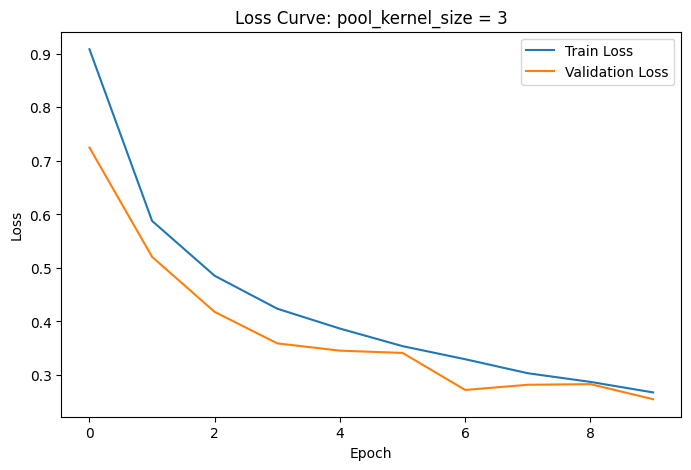

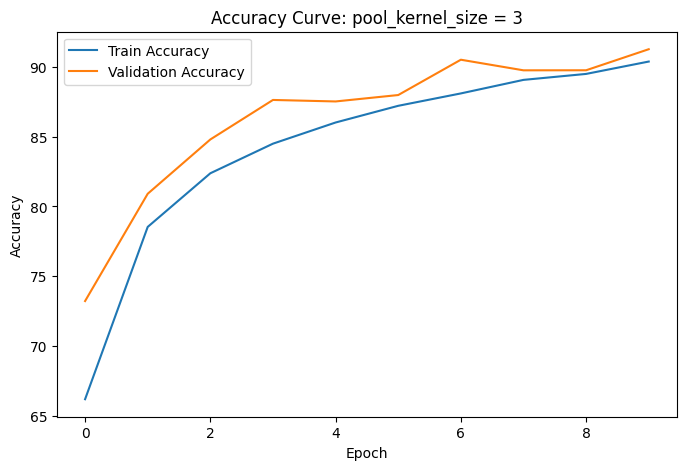

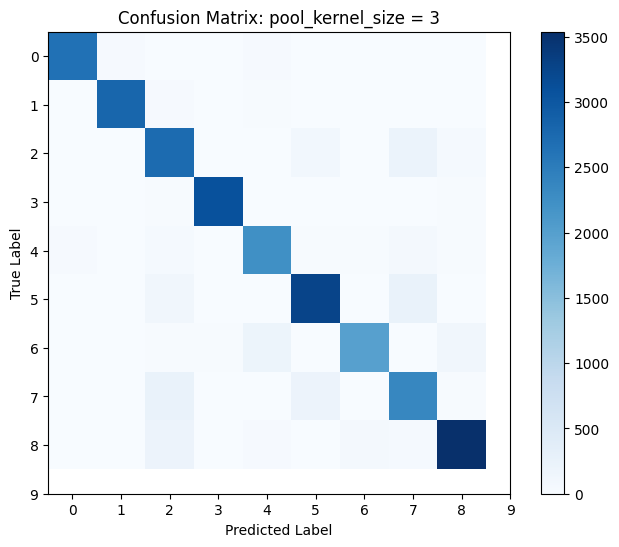

Classification Report:
              precision    recall  f1-score   support

           0     0.9804    0.9732    0.9768      2722
           1     0.9807    0.9760    0.9783      2870
           2     0.7983    0.8756    0.8352      3119
           3     0.9875    0.9866    0.9870      3124
           4     0.8873    0.9183    0.9025      2435
           5     0.9054    0.8935    0.8994      3642
           6     0.9581    0.8467    0.8990      2349
           7     0.8005    0.8306    0.8153      2840
           8     0.9405    0.9076    0.9238      3898

    accuracy                         0.9126     26999
   macro avg     0.9154    0.9120    0.9130     26999
weighted avg     0.9151    0.9126    0.9132     26999


--- Testing pool_kernel_size = 4 ---
Train Accuracy: 88.76%
Validation Accuracy: 89.83%


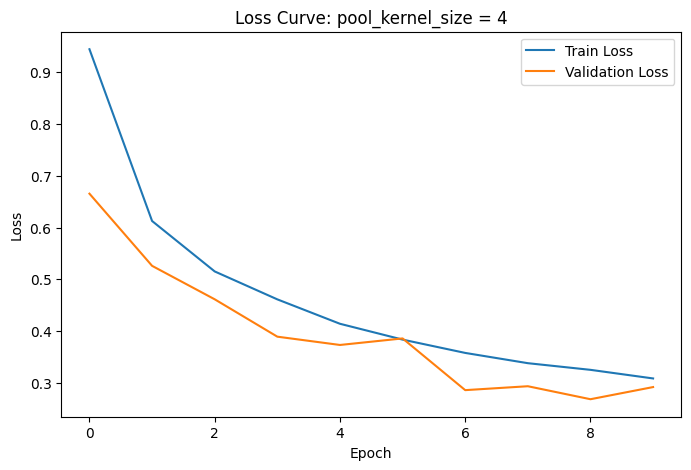

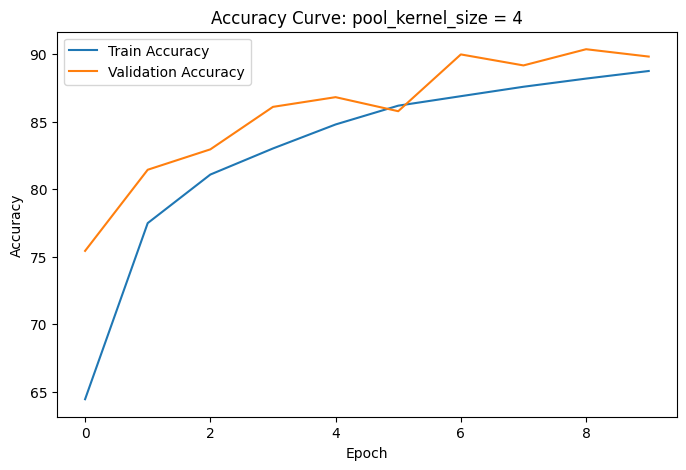

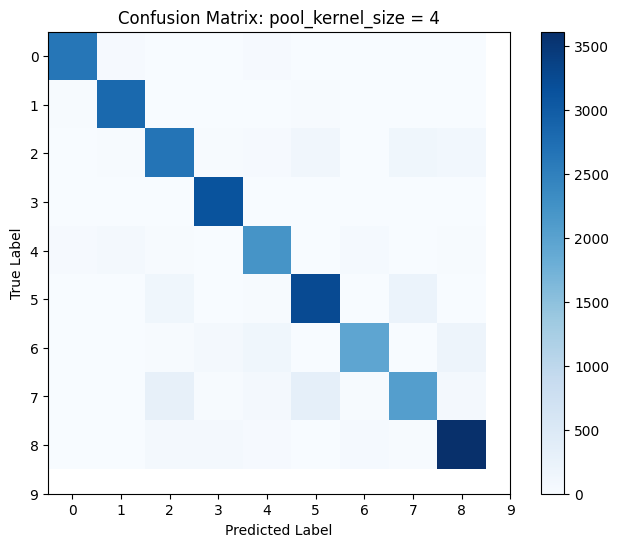

Classification Report:
              precision    recall  f1-score   support

           0     0.9640    0.9651    0.9646      2722
           1     0.9509    0.9787    0.9646      2870
           2     0.8215    0.8512    0.8361      3119
           3     0.9434    0.9981    0.9700      3124
           4     0.8631    0.9064    0.8842      2435
           5     0.8685    0.8888    0.8785      3642
           6     0.9355    0.8267    0.8777      2349
           7     0.8407    0.7208    0.7761      2840
           8     0.9055    0.9264    0.9158      3898

    accuracy                         0.8983     26999
   macro avg     0.8992    0.8958    0.8964     26999
weighted avg     0.8979    0.8983    0.8971     26999


--- Testing pool_kernel_size = 5 ---
Train Accuracy: 88.26%
Validation Accuracy: 88.96%


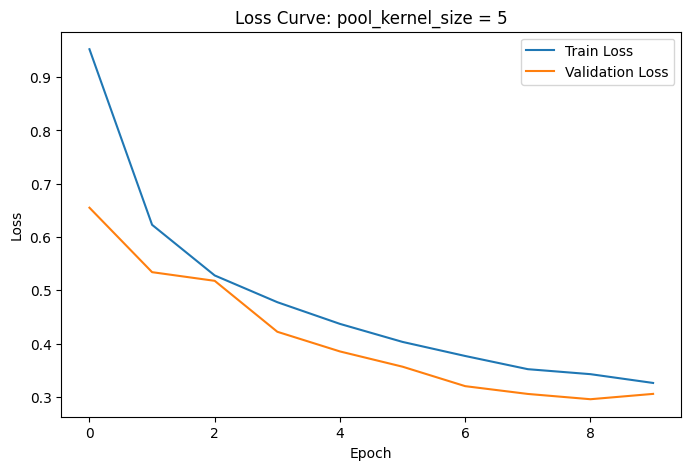

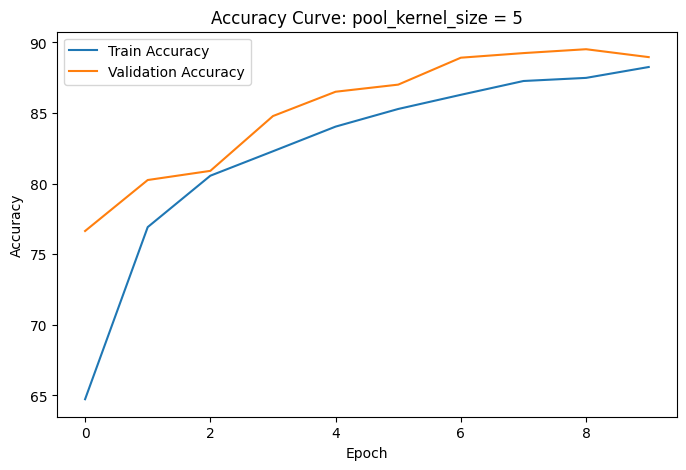

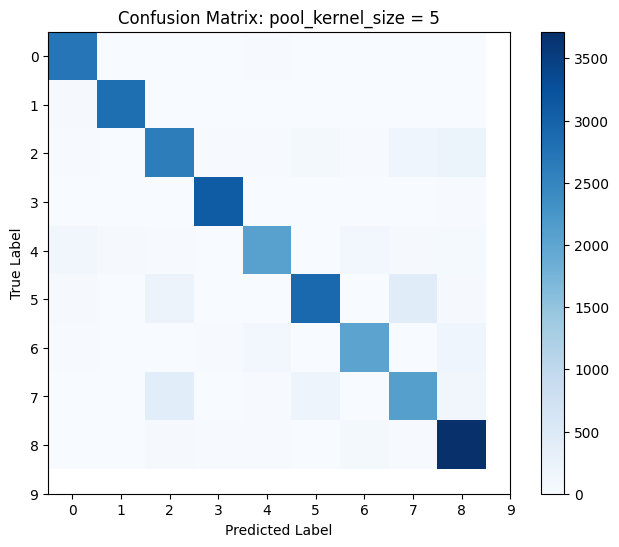

Classification Report:
              precision    recall  f1-score   support

           0     0.9190    0.9919    0.9541      2722
           1     0.9785    0.9822    0.9804      2870
           2     0.7931    0.8342    0.8131      3119
           3     0.9754    0.9888    0.9820      3124
           4     0.9129    0.8485    0.8795      2435
           5     0.9177    0.7996    0.8546      3642
           6     0.9056    0.8621    0.8833      2349
           7     0.7609    0.7363    0.7484      2840
           8     0.8613    0.9528    0.9048      3898

    accuracy                         0.8896     26999
   macro avg     0.8916    0.8885    0.8889     26999
weighted avg     0.8905    0.8896    0.8888     26999


--- Testing pool_kernel_size = 6 ---
Train Accuracy: 88.73%
Validation Accuracy: 90.57%


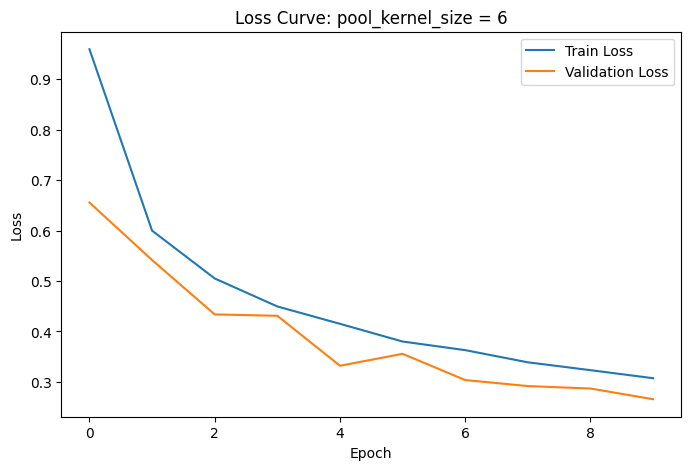

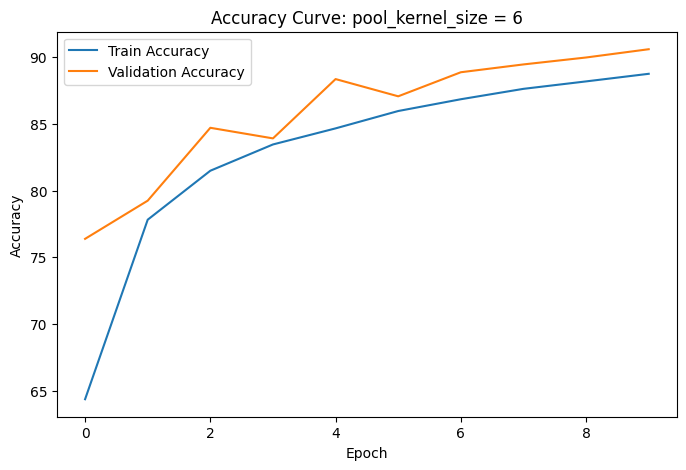

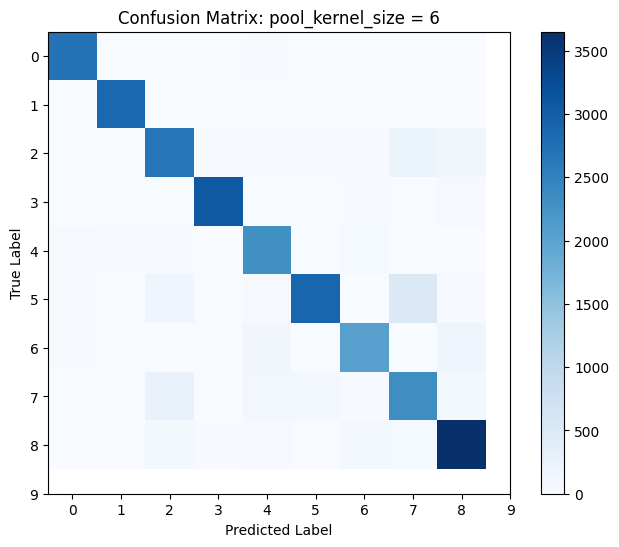

Classification Report:
              precision    recall  f1-score   support

           0     0.9656    0.9904    0.9779      2722
           1     0.9851    0.9923    0.9887      2870
           2     0.8399    0.8512    0.8455      3119
           3     0.9852    0.9824    0.9838      3124
           4     0.8729    0.9368    0.9037      2435
           5     0.9503    0.7930    0.8645      3642
           6     0.9153    0.8697    0.8919      2349
           7     0.7451    0.8183    0.7800      2840
           8     0.9039    0.9361    0.9197      3898

    accuracy                         0.9057     26999
   macro avg     0.9071    0.9078    0.9062     26999
weighted avg     0.9085    0.9057    0.9058     26999


--- Testing pool_kernel_size = 7 ---
Train Accuracy: 88.49%
Validation Accuracy: 90.81%


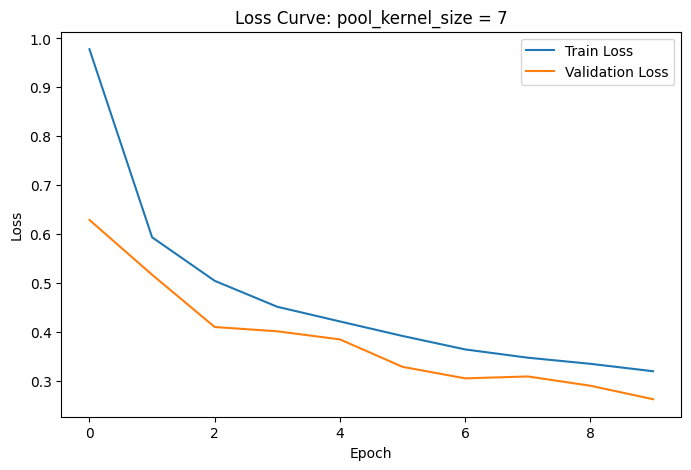

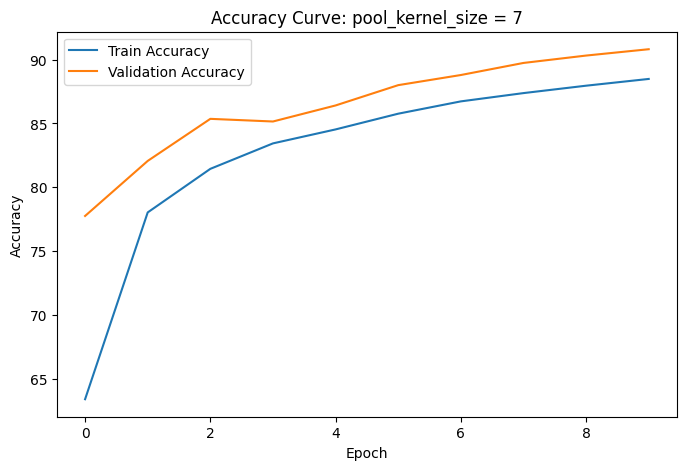

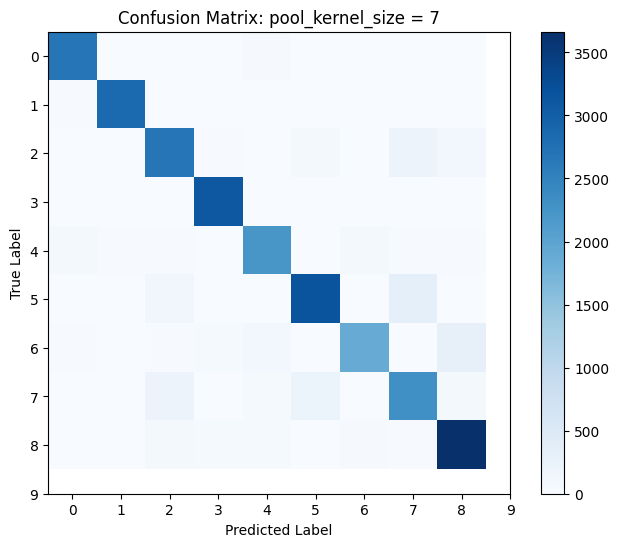

Classification Report:
              precision    recall  f1-score   support

           0     0.9534    0.9846    0.9687      2722
           1     0.9892    0.9885    0.9888      2870
           2     0.8599    0.8618    0.8608      3119
           3     0.9595    0.9930    0.9759      3124
           4     0.8940    0.9076    0.9008      2435
           5     0.9145    0.8663    0.8897      3642
           6     0.9406    0.7948    0.8616      2349
           7     0.7983    0.8151    0.8066      2840
           8     0.8820    0.9400    0.9101      3898

    accuracy                         0.9081     26999
   macro avg     0.9101    0.9057    0.9070     26999
weighted avg     0.9088    0.9081    0.9076     26999



In [ ]:
from itertools import product

fixed_params = {
    'conv_kernel_size': 3,
    'conv_dropout': 0.2,
    'activation_fn': 'relu',
    'batch_size': 64,
    'optimizer_type': 'adam',
    'num_conv_layers': 2,
    'fc_hidden_units': 512,
    'pool_kernel_size': 2,
    'pool_stride': 2,
    'fc_dropout': 0.3,
    'num_epochs': 10
}

pool_kernel_size = [2, 3, 4, 5, 6, 7]
criterion = nn.CrossEntropyLoss()

for val in pool_kernel_size:
    print(f"\n--- Testing pool_kernel_size = {val} ---")

    current_params = fixed_params.copy()
    current_params['pool_kernel_size'] = val
    batch_size = current_params['batch_size']

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    try:
        model = PathMNIST_CNN(
            conv_kernel_size=current_params['conv_kernel_size'],
            conv_dropout=current_params['conv_dropout'],
            activation_fn=current_params['activation_fn'],
            num_conv_layers=current_params['num_conv_layers'],
            fc_hidden_units=current_params['fc_hidden_units'],
            pool_kernel_size=current_params['pool_kernel_size'],
            pool_stride=current_params['pool_stride'],
            fc_dropout=current_params['fc_dropout']
        ).to(device)
    except Exception as e:
        print(f"[SKIPPED] Hata oluştu: {e} → pool_kernel_size = {val}")
        continue

    if current_params['optimizer_type'] == 'adam':
        optimizer = optim.Adam(model.parameters())
    elif current_params['optimizer_type'] == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    else:
        optimizer = optim.RMSprop(model.parameters())

    train_losses, val_losses, val_accuracies, train_accuracies, preds, labels = train_and_validate(
        model, train_loader, val_loader, optimizer, criterion, epochs=current_params['num_epochs'])

    print(f"Train Accuracy: {train_accuracies[-1]:.2f}%")
    print(f"Validation Accuracy: {val_accuracies[-1]:.2f}%")

    # Plot Loss
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Loss Curve: pool_kernel_size = {val}')
    plt.legend()
    plt.show()

    # Plot Accuracy
    plt.figure(figsize=(8, 5))
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy Curve: pool_kernel_size = {val}')
    plt.legend()
    plt.show()

    # Confusion Matrix
    cm = confusion_matrix(labels, preds.argmax(dim=1))
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix: pool_kernel_size = {val}")
    plt.colorbar()
    tick_marks = np.arange(10)
    plt.xticks(tick_marks, tick_marks)
    plt.yticks(tick_marks, tick_marks)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    # Classification Report
    print("Classification Report:")
    print(classification_report(labels, preds.argmax(dim=1), digits=4))



--- Testing pool_stride = 1 ---
Train Accuracy: 94.07%
Validation Accuracy: 87.81%


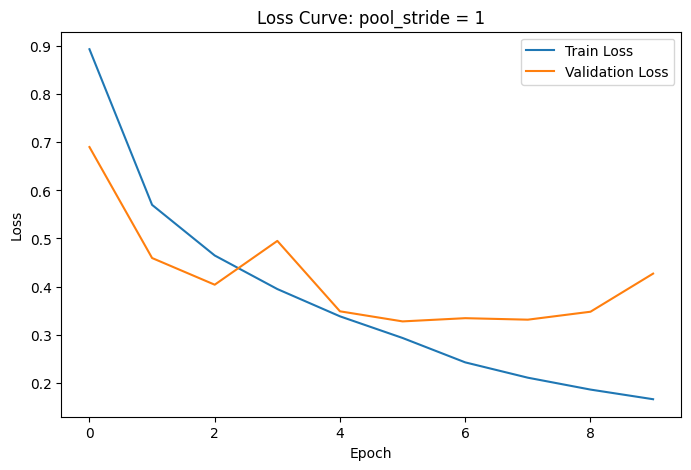

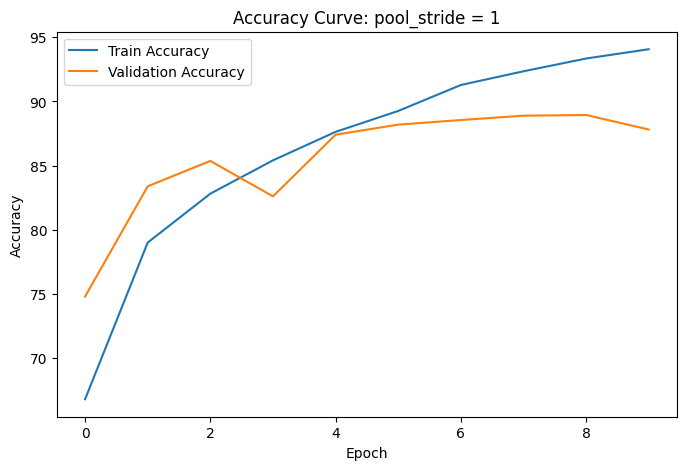

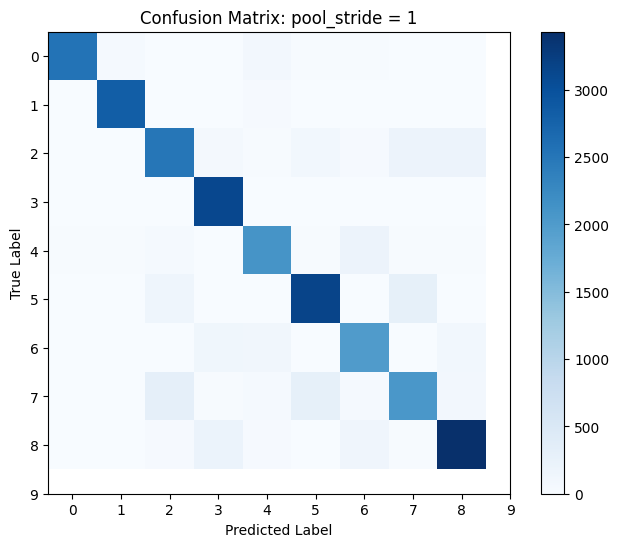

Classification Report:
              precision    recall  f1-score   support

           0     0.9872    0.9335    0.9596      2722
           1     0.9680    0.9812    0.9746      2870
           2     0.8186    0.8003    0.8093      3119
           3     0.8748    0.9978    0.9323      3124
           4     0.8602    0.8591    0.8597      2435
           5     0.8791    0.8682    0.8736      3642
           6     0.8160    0.8493    0.8323      2349
           7     0.7974    0.7250    0.7595      2840
           8     0.8916    0.8802    0.8859      3898

    accuracy                         0.8781     26999
   macro avg     0.8770    0.8772    0.8763     26999
weighted avg     0.8780    0.8781    0.8773     26999


--- Testing pool_stride = 2 ---
Train Accuracy: 90.88%
Validation Accuracy: 90.09%


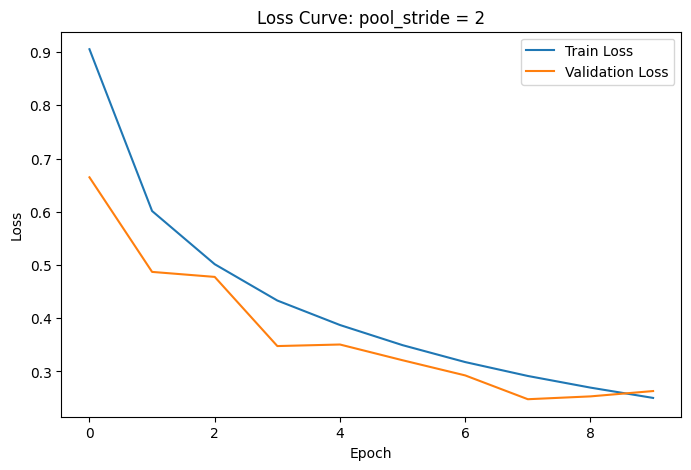

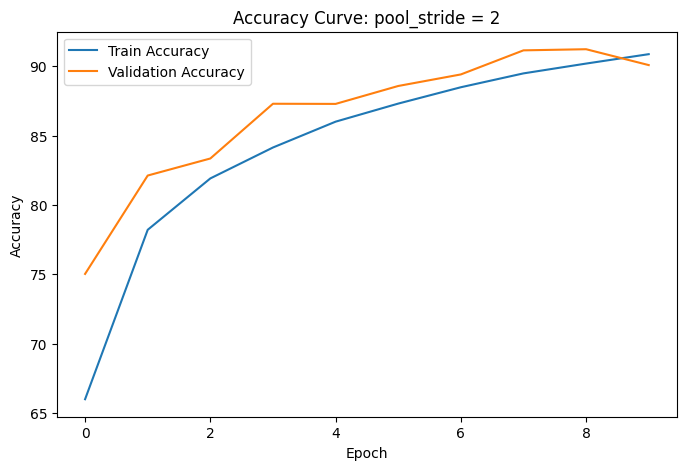

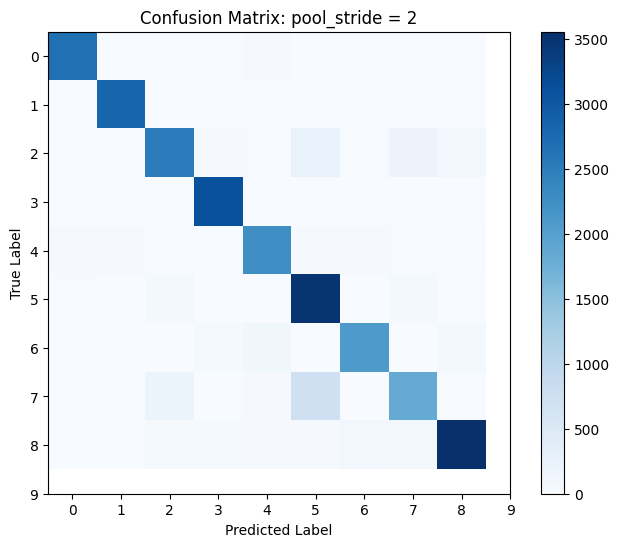

Classification Report:
              precision    recall  f1-score   support

           0     0.9682    0.9835    0.9758      2722
           1     0.9813    0.9854    0.9833      2870
           2     0.8756    0.8035    0.8380      3119
           3     0.9616    0.9952    0.9781      3124
           4     0.8897    0.9240    0.9065      2435
           5     0.7682    0.9544    0.8512      3642
           6     0.9222    0.8876    0.9046      2349
           7     0.8415    0.6468    0.7314      2840
           8     0.9457    0.9120    0.9286      3898

    accuracy                         0.9009     26999
   macro avg     0.9060    0.8992    0.8997     26999
weighted avg     0.9035    0.9009    0.8992     26999


--- Testing pool_stride = 3 ---
Train Accuracy: 85.59%
Validation Accuracy: 87.45%


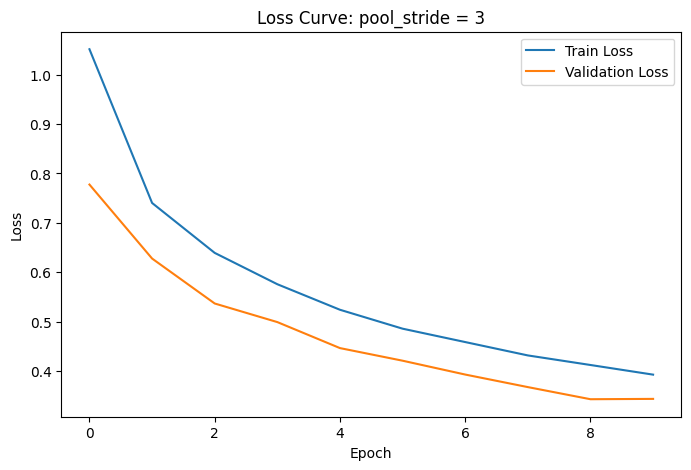

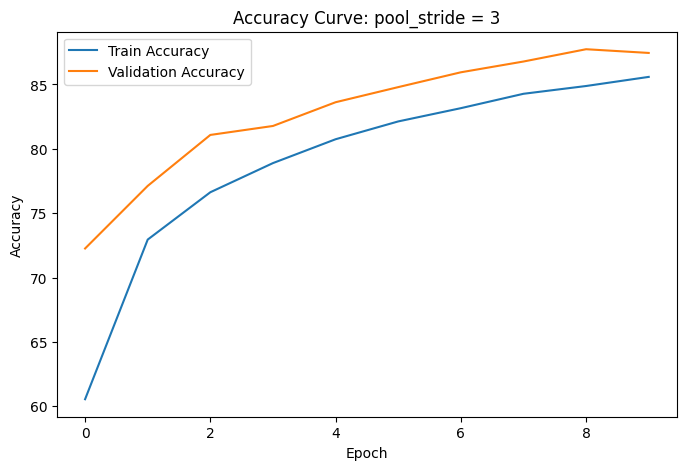

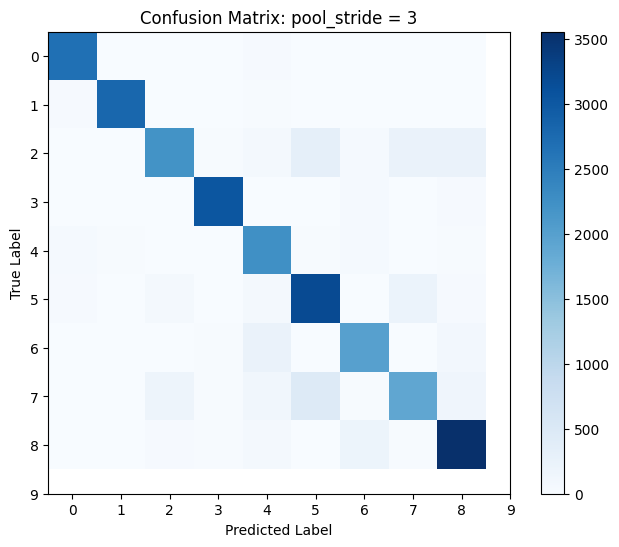

Classification Report:
              precision    recall  f1-score   support

           0     0.9439    0.9831    0.9631      2722
           1     0.9862    0.9746    0.9804      2870
           2     0.8769    0.7079    0.7834      3119
           3     0.9759    0.9702    0.9730      3124
           4     0.7909    0.9244    0.8525      2435
           5     0.8010    0.8773    0.8374      3642
           6     0.8434    0.8484    0.8459      2349
           7     0.7997    0.6694    0.7288      2840
           8     0.8617    0.9128    0.8865      3898

    accuracy                         0.8745     26999
   macro avg     0.8755    0.8742    0.8723     26999
weighted avg     0.8755    0.8745    0.8725     26999


--- Testing pool_stride = 4 ---
Train Accuracy: 82.18%
Validation Accuracy: 85.12%


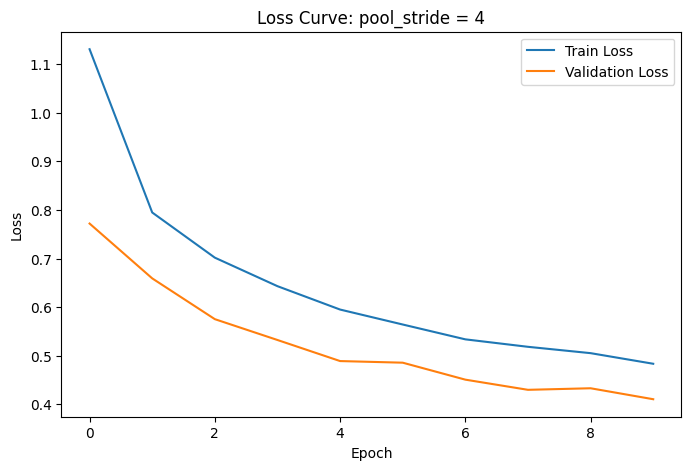

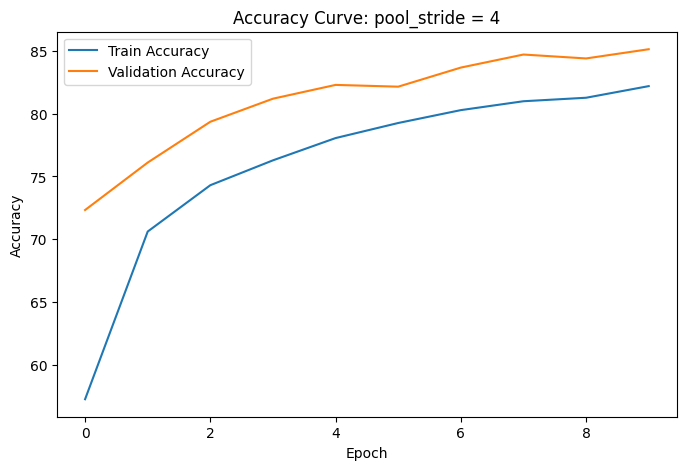

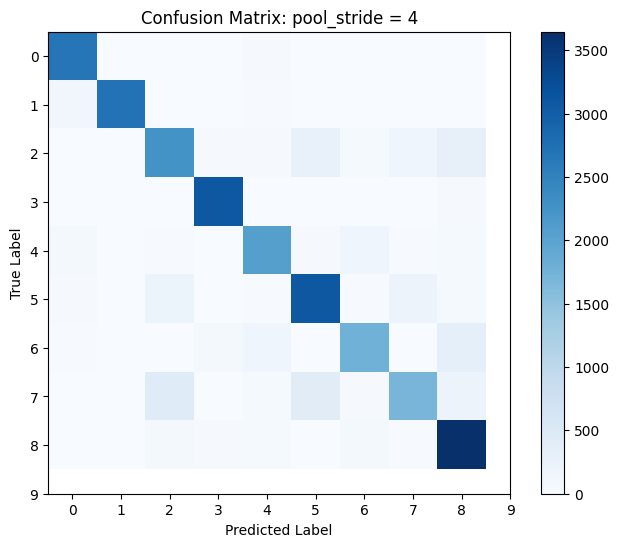

Classification Report:
              precision    recall  f1-score   support

           0     0.9025    0.9794    0.9394      2722
           1     0.9848    0.9474    0.9657      2870
           2     0.7518    0.7223    0.7368      3119
           3     0.9538    0.9853    0.9693      3124
           4     0.8525    0.8476    0.8501      2435
           5     0.8106    0.8460    0.8279      3642
           6     0.8397    0.7539    0.7945      2349
           7     0.8007    0.5996    0.6857      2840
           8     0.7923    0.9354    0.8579      3898

    accuracy                         0.8512     26999
   macro avg     0.8543    0.8463    0.8475     26999
weighted avg     0.8508    0.8512    0.8481     26999


--- Testing pool_stride = 5 ---
Train Accuracy: 69.37%
Validation Accuracy: 73.08%


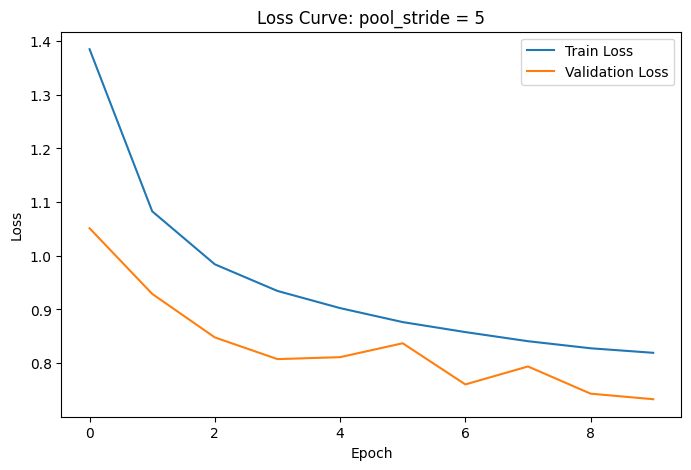

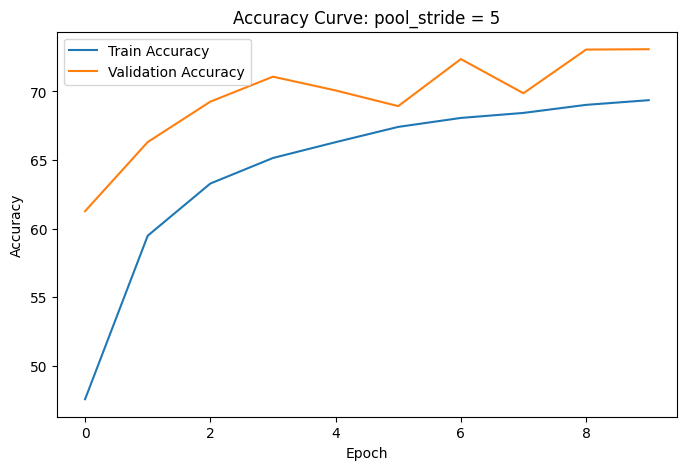

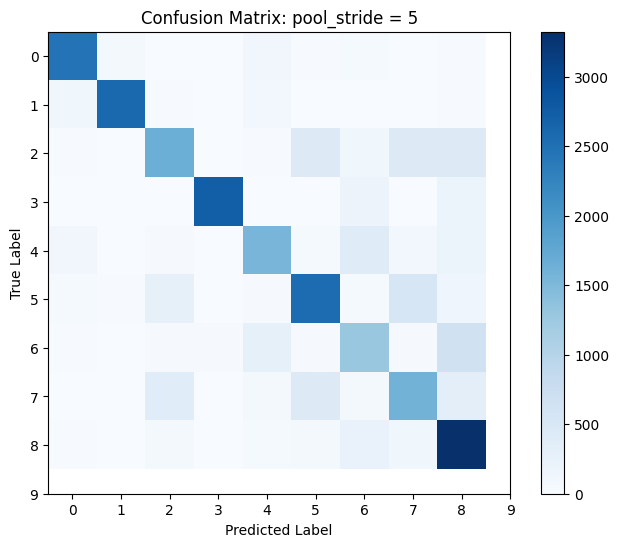

Classification Report:
              precision    recall  f1-score   support

           0     0.8780    0.9015    0.8896      2722
           1     0.9569    0.9052    0.9303      2870
           2     0.6715    0.5316    0.5934      3119
           3     0.9802    0.8710    0.9224      3124
           4     0.7113    0.6386    0.6730      2435
           5     0.7131    0.7015    0.7073      3642
           6     0.5391    0.5428    0.5409      2349
           7     0.5633    0.5609    0.5621      2840
           8     0.6291    0.8525    0.7240      3898

    accuracy                         0.7308     26999
   macro avg     0.7381    0.7229    0.7270     26999
weighted avg     0.7386    0.7308    0.7307     26999


--- Testing pool_stride = 6 ---
Train Accuracy: 69.65%
Validation Accuracy: 68.31%


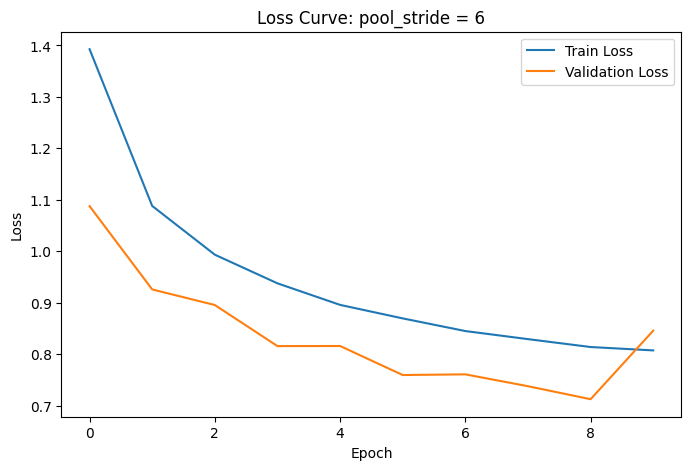

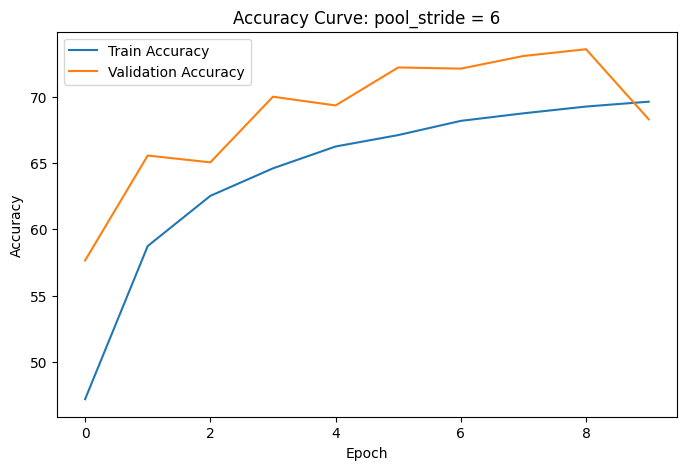

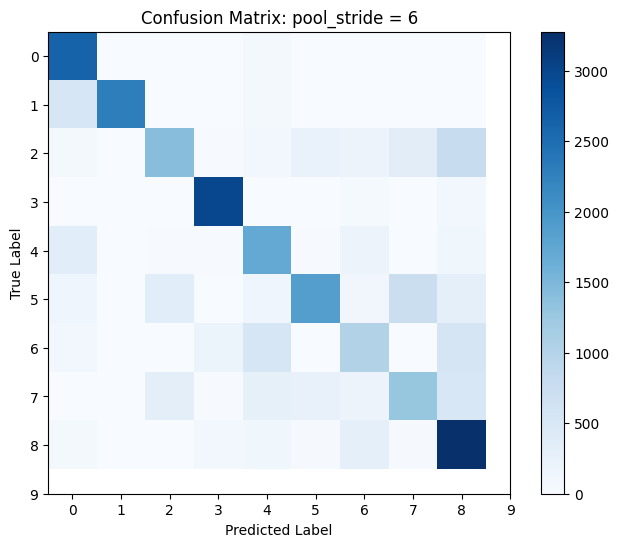

Classification Report:
              precision    recall  f1-score   support

           0     0.6804    0.9673    0.7988      2722
           1     0.9875    0.7951    0.8809      2870
           2     0.6694    0.4479    0.5367      3119
           3     0.8959    0.9533    0.9237      3124
           4     0.5774    0.7014    0.6334      2435
           5     0.7818    0.5115    0.6184      3642
           6     0.5010    0.4364    0.4664      2349
           7     0.5375    0.4514    0.4907      2840
           8     0.5814    0.8404    0.6873      3898

    accuracy                         0.6831     26999
   macro avg     0.6902    0.6783    0.6707     26999
weighted avg     0.6962    0.6831    0.6750     26999



In [ ]:
from itertools import product

fixed_params = {
    'conv_kernel_size': 3,
    'conv_dropout': 0.2,
    'activation_fn': 'relu',
    'batch_size': 64,
    'optimizer_type': 'adam',
    'num_conv_layers': 2,
    'fc_hidden_units': 512,
    'pool_kernel_size': 2,
    'pool_stride': 2,
    'fc_dropout': 0.3,
    'num_epochs': 10
}

pool_stride = [1, 2, 3, 4, 5, 6]
criterion = nn.CrossEntropyLoss()

for val in pool_stride:
    print(f"\n--- Testing pool_stride = {val} ---")

    current_params = fixed_params.copy()
    current_params['pool_stride'] = val
    batch_size = current_params['batch_size']

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    try:
        model = PathMNIST_CNN(
            conv_kernel_size=current_params['conv_kernel_size'],
            conv_dropout=current_params['conv_dropout'],
            activation_fn=current_params['activation_fn'],
            num_conv_layers=current_params['num_conv_layers'],
            fc_hidden_units=current_params['fc_hidden_units'],
            pool_kernel_size=current_params['pool_kernel_size'],
            pool_stride=current_params['pool_stride'],
            fc_dropout=current_params['fc_dropout']
        ).to(device)
    except Exception as e:
        print(f"[SKIPPED] Hata oluştu: {e} → pool_stride = {val}")
        continue

    if current_params['optimizer_type'] == 'adam':
        optimizer = optim.Adam(model.parameters())
    elif current_params['optimizer_type'] == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    else:
        optimizer = optim.RMSprop(model.parameters())

    train_losses, val_losses, val_accuracies, train_accuracies, preds, labels = train_and_validate(
        model, train_loader, val_loader, optimizer, criterion, epochs=current_params['num_epochs'])

    print(f"Train Accuracy: {train_accuracies[-1]:.2f}%")
    print(f"Validation Accuracy: {val_accuracies[-1]:.2f}%")

    # Plot Loss
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Loss Curve: pool_stride = {val}')
    plt.legend()
    plt.show()

    # Plot Accuracy
    plt.figure(figsize=(8, 5))
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy Curve: pool_stride = {val}')
    plt.legend()
    plt.show()

    # Confusion Matrix
    cm = confusion_matrix(labels, preds.argmax(dim=1))
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix: pool_stride = {val}")
    plt.colorbar()
    tick_marks = np.arange(10)
    plt.xticks(tick_marks, tick_marks)
    plt.yticks(tick_marks, tick_marks)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    # Classification Report
    print("Classification Report:")
    print(classification_report(labels, preds.argmax(dim=1), digits=4))



--- Testing fc_dropout = 0 ---
Train Accuracy: 90.10%
Validation Accuracy: 90.53%


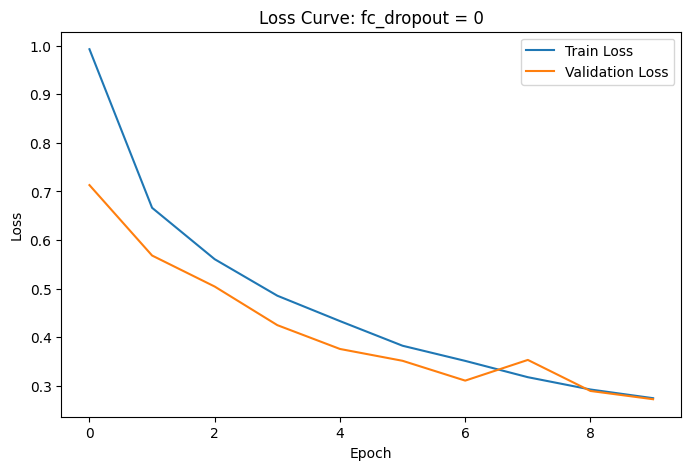

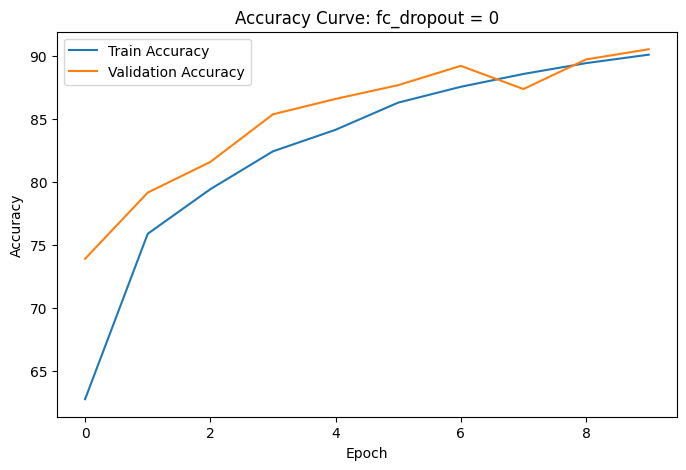

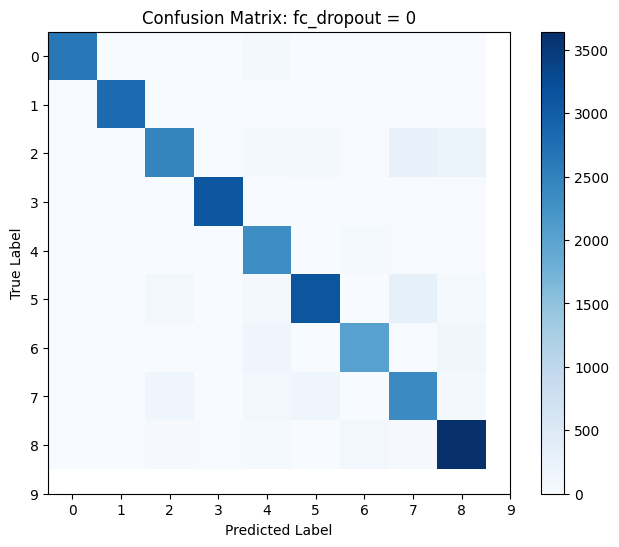

Classification Report:
              precision    recall  f1-score   support

           0     0.9787    0.9644    0.9715      2722
           1     0.9849    0.9801    0.9825      2870
           2     0.8857    0.7852    0.8324      3119
           3     0.9751    0.9898    0.9824      3124
           4     0.8112    0.9548    0.8772      2435
           5     0.9261    0.8539    0.8886      3642
           6     0.9113    0.8612    0.8855      2349
           7     0.7888    0.8324    0.8100      2840
           8     0.8915    0.9341    0.9123      3898

    accuracy                         0.9053     26999
   macro avg     0.9059    0.9062    0.9047     26999
weighted avg     0.9076    0.9053    0.9052     26999


--- Testing fc_dropout = 0.1 ---
Train Accuracy: 89.16%
Validation Accuracy: 89.11%


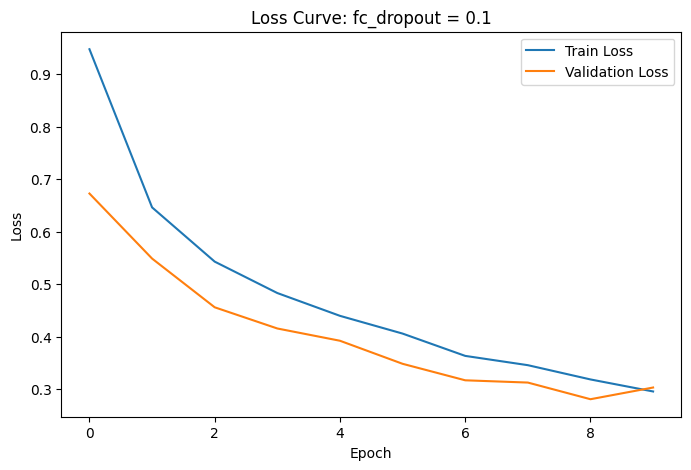

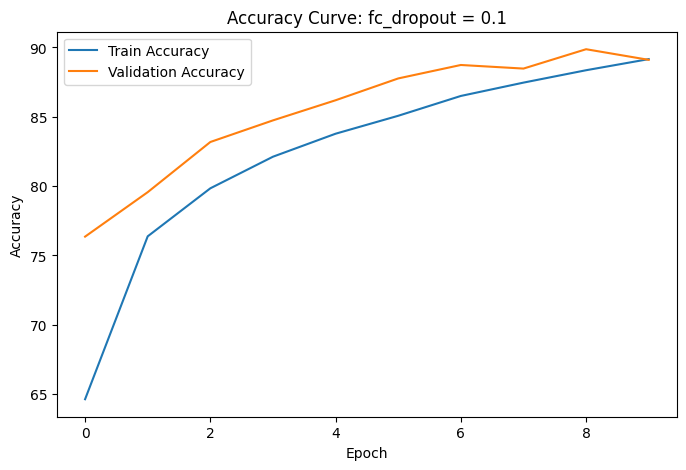

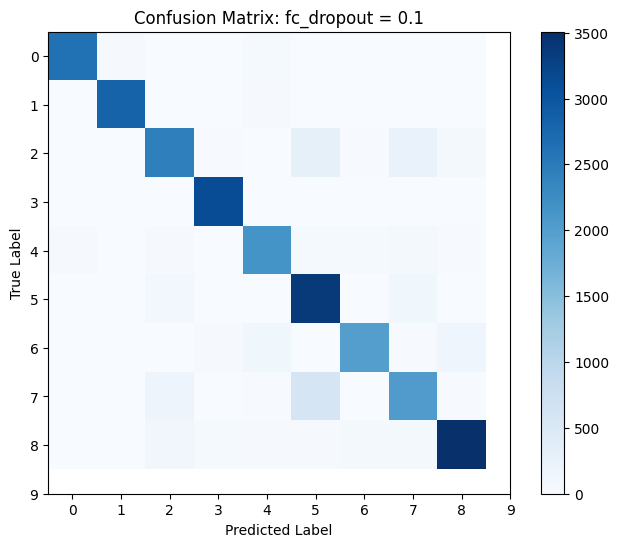

Classification Report:
              precision    recall  f1-score   support

           0     0.9748    0.9647    0.9697      2722
           1     0.9761    0.9822    0.9792      2870
           2     0.8438    0.7810    0.8112      3119
           3     0.9659    0.9965    0.9809      3124
           4     0.8875    0.8875    0.8875      2435
           5     0.7753    0.9248    0.8435      3642
           6     0.9275    0.8493    0.8867      2349
           7     0.7868    0.7158    0.7496      2840
           8     0.9246    0.8997    0.9120      3898

    accuracy                         0.8911     26999
   macro avg     0.8958    0.8891    0.8911     26999
weighted avg     0.8928    0.8911    0.8905     26999


--- Testing fc_dropout = 0.2 ---
Train Accuracy: 88.78%
Validation Accuracy: 89.34%


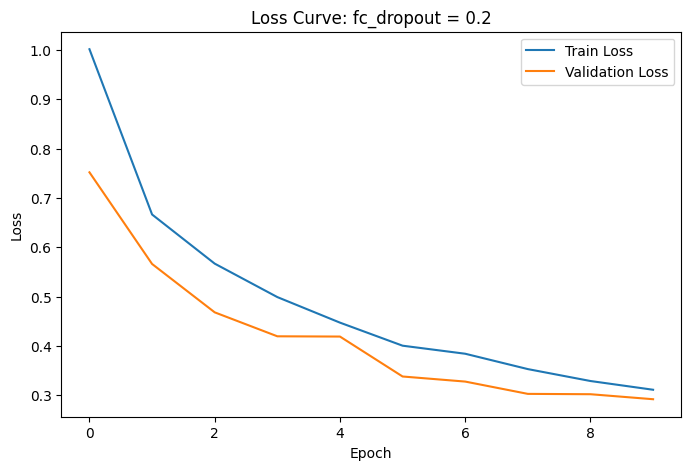

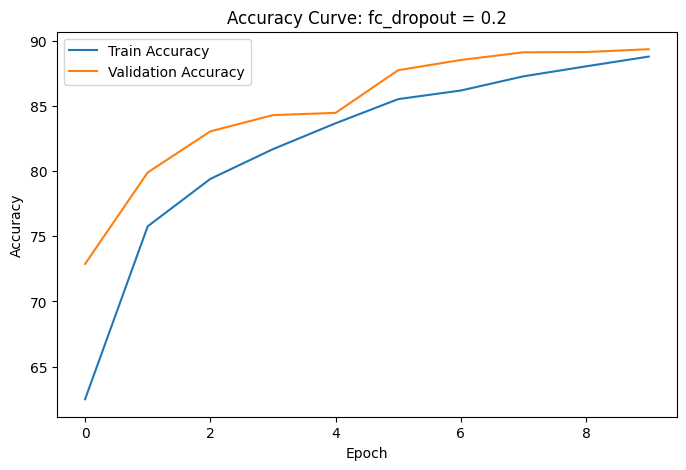

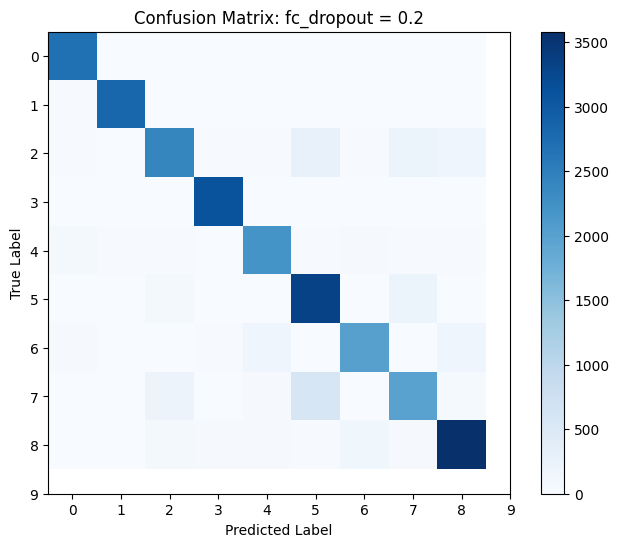

Classification Report:
              precision    recall  f1-score   support

           0     0.9456    0.9901    0.9673      2722
           1     0.9816    0.9871    0.9844      2870
           2     0.8707    0.7704    0.8175      3119
           3     0.9727    0.9933    0.9829      3124
           4     0.8943    0.9068    0.9005      2435
           5     0.7886    0.9116    0.8456      3642
           6     0.9108    0.8523    0.8806      2349
           7     0.7981    0.6961    0.7437      2840
           8     0.9043    0.9184    0.9113      3898

    accuracy                         0.8934     26999
   macro avg     0.8963    0.8918    0.8926     26999
weighted avg     0.8936    0.8934    0.8920     26999


--- Testing fc_dropout = 0.3 ---
Train Accuracy: 87.64%
Validation Accuracy: 89.41%


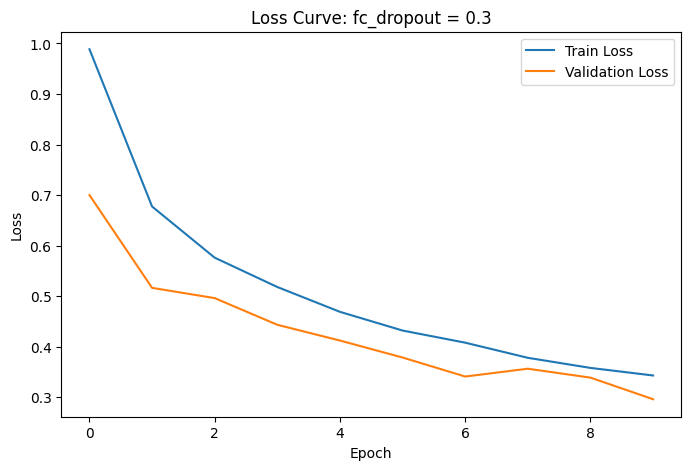

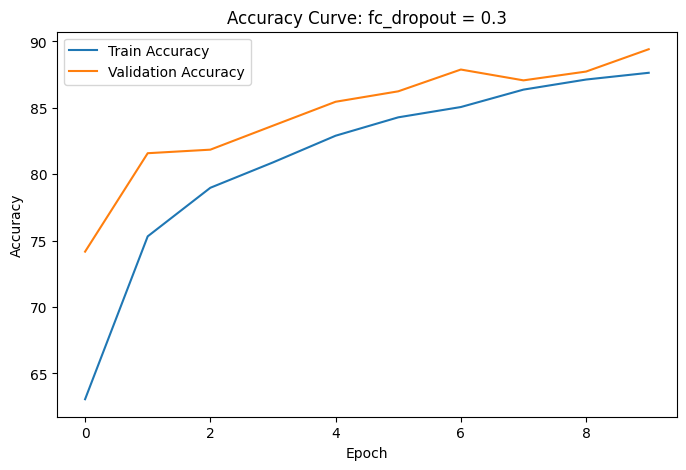

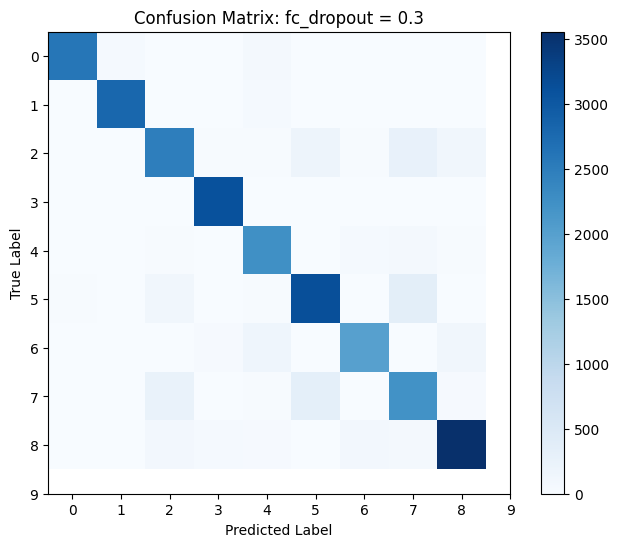

Classification Report:
              precision    recall  f1-score   support

           0     0.9818    0.9537    0.9676      2722
           1     0.9726    0.9774    0.9750      2870
           2     0.8394    0.7977    0.8180      3119
           3     0.9622    0.9936    0.9776      3124
           4     0.8575    0.9220    0.8886      2435
           5     0.8592    0.8597    0.8595      3642
           6     0.9195    0.8514    0.8842      2349
           7     0.7413    0.7789    0.7596      2840
           8     0.9220    0.9130    0.9175      3898

    accuracy                         0.8941     26999
   macro avg     0.8951    0.8941    0.8942     26999
weighted avg     0.8950    0.8941    0.8942     26999


--- Testing fc_dropout = 0.4 ---
Train Accuracy: 85.82%
Validation Accuracy: 87.18%


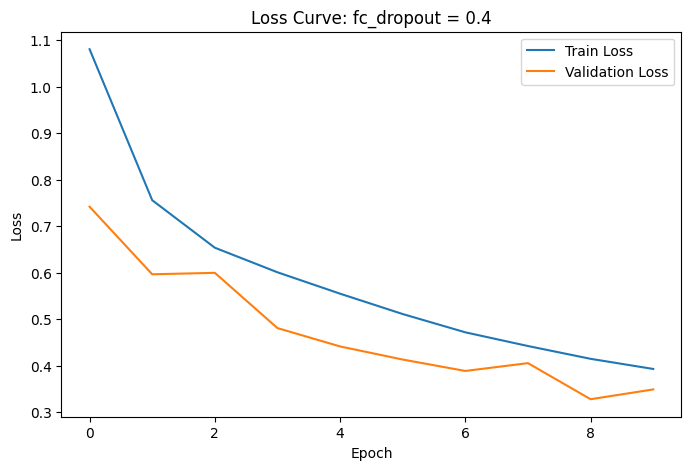

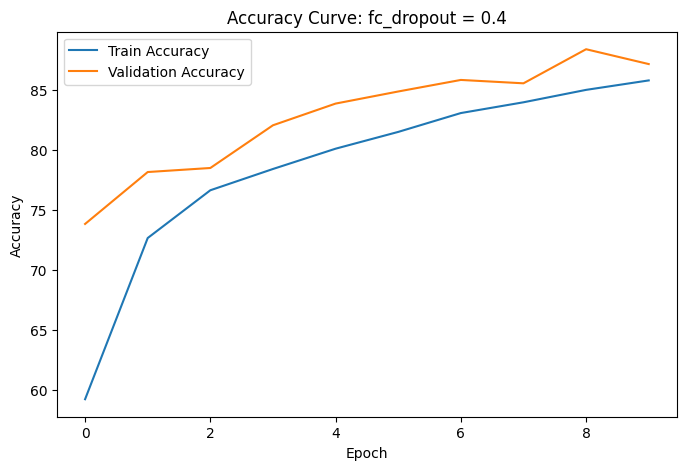

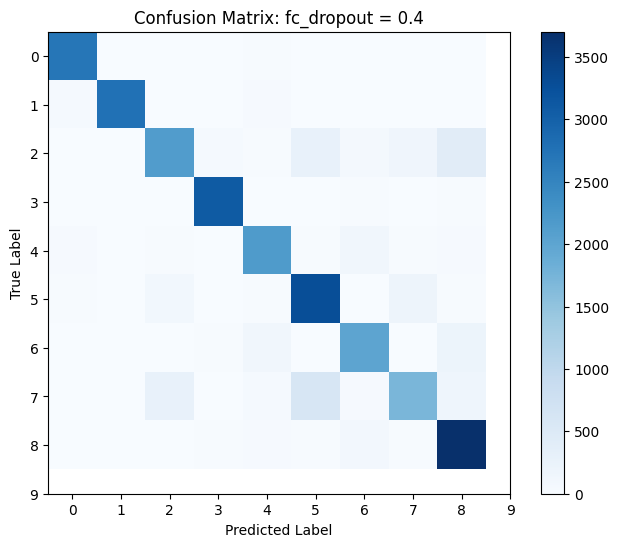

Classification Report:
              precision    recall  f1-score   support

           0     0.9580    0.9882    0.9729      2722
           1     0.9893    0.9634    0.9762      2870
           2     0.8402    0.6829    0.7534      3119
           3     0.9686    0.9862    0.9773      3124
           4     0.8813    0.8899    0.8856      2435
           5     0.7794    0.9012    0.8359      3642
           6     0.8479    0.8544    0.8511      2349
           7     0.8189    0.6035    0.6949      2840
           8     0.8136    0.9497    0.8764      3898

    accuracy                         0.8718     26999
   macro avg     0.8775    0.8688    0.8693     26999
weighted avg     0.8729    0.8718    0.8683     26999


--- Testing fc_dropout = 0.5 ---
Train Accuracy: 86.21%
Validation Accuracy: 88.10%


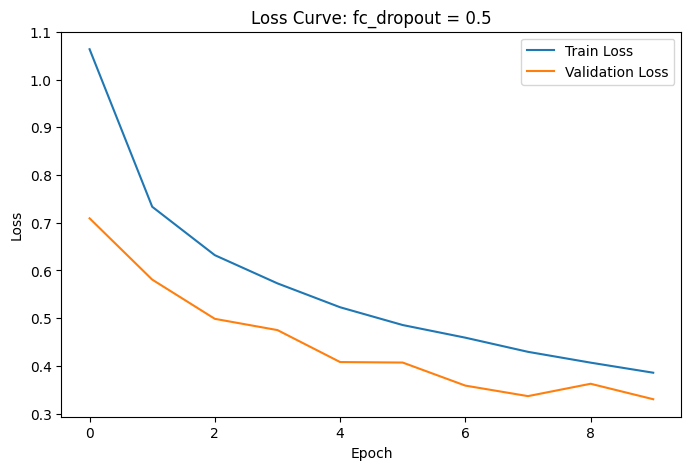

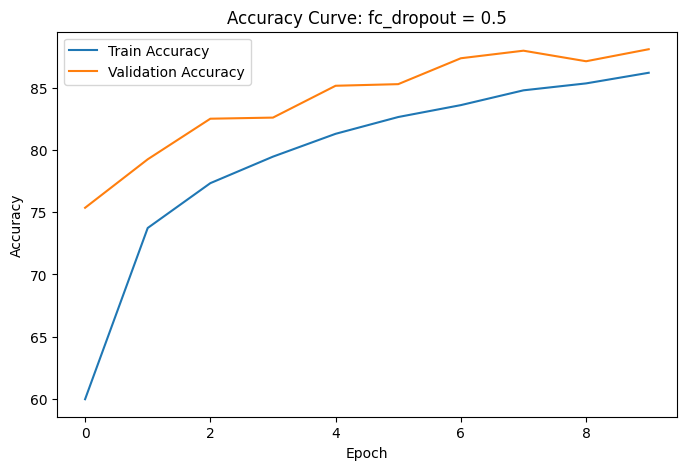

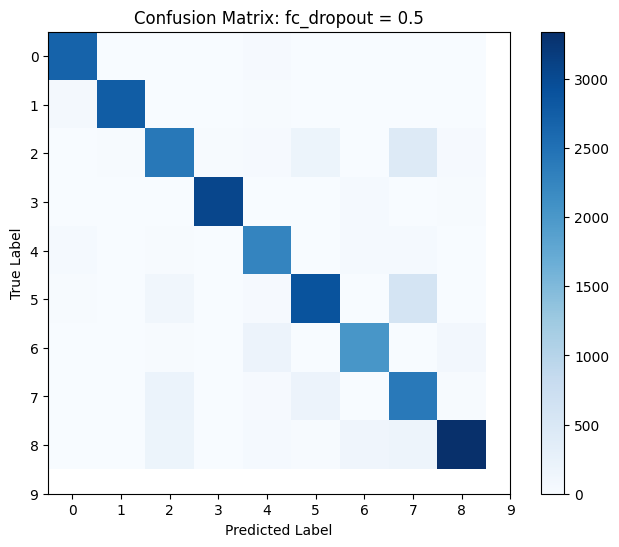

Classification Report:
              precision    recall  f1-score   support

           0     0.9391    0.9860    0.9620      2722
           1     0.9878    0.9627    0.9751      2870
           2     0.8158    0.7711    0.7928      3119
           3     0.9899    0.9757    0.9828      3124
           4     0.8572    0.9244    0.8895      2435
           5     0.8775    0.7927    0.8329      3642
           6     0.8903    0.8599    0.8748      2349
           7     0.6596    0.8412    0.7394      2840
           8     0.9516    0.8568    0.9017      3898

    accuracy                         0.8810     26999
   macro avg     0.8854    0.8856    0.8835     26999
weighted avg     0.8884    0.8810    0.8826     26999



In [ ]:
from itertools import product

fixed_params = {
    'conv_kernel_size': 3,
    'conv_dropout': 0.2,
    'activation_fn': 'relu',
    'batch_size': 64,
    'optimizer_type': 'adam',
    'num_conv_layers': 2,
    'fc_hidden_units': 128,
    'pool_kernel_size': 2,
    'pool_stride': 2,
    'fc_dropout': 0.3,
    'num_epochs': 10
}

fc_dropout = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
criterion = nn.CrossEntropyLoss()

for val in fc_dropout:
    print(f"\n--- Testing fc_dropout = {val} ---")

    current_params = fixed_params.copy()
    current_params['fc_dropout'] = val
    batch_size = current_params['batch_size']

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    try:
        model = PathMNIST_CNN(
            conv_kernel_size=current_params['conv_kernel_size'],
            conv_dropout=current_params['conv_dropout'],
            activation_fn=current_params['activation_fn'],
            num_conv_layers=current_params['num_conv_layers'],
            fc_hidden_units=current_params['fc_hidden_units'],
            pool_kernel_size=current_params['pool_kernel_size'],
            pool_stride=current_params['pool_stride'],
            fc_dropout=current_params['fc_dropout']
        ).to(device)
    except Exception as e:
        print(f"[SKIPPED] Hata oluştu: {e} → fc_dropout = {val}")
        continue

    if current_params['optimizer_type'] == 'adam':
        optimizer = optim.Adam(model.parameters())
    elif current_params['optimizer_type'] == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    else:
        optimizer = optim.RMSprop(model.parameters())

    train_losses, val_losses, val_accuracies, train_accuracies, preds, labels = train_and_validate(
        model, train_loader, val_loader, optimizer, criterion, epochs=current_params['num_epochs'])

    print(f"Train Accuracy: {train_accuracies[-1]:.2f}%")
    print(f"Validation Accuracy: {val_accuracies[-1]:.2f}%")

    # Plot Loss
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Loss Curve: fc_dropout = {val}')
    plt.legend()
    plt.show()

    # Plot Accuracy
    plt.figure(figsize=(8, 5))
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy Curve: fc_dropout = {val}')
    plt.legend()
    plt.show()

    # Confusion Matrix
    cm = confusion_matrix(labels, preds.argmax(dim=1))
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix: fc_dropout = {val}")
    plt.colorbar()
    tick_marks = np.arange(10)
    plt.xticks(tick_marks, tick_marks)
    plt.yticks(tick_marks, tick_marks)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    # Classification Report
    print("Classification Report:")
    print(classification_report(labels, preds.argmax(dim=1), digits=4))



--- Testing num_epochs = 5 ---
Train Accuracy: 85.02%
Validation Accuracy: 86.10%


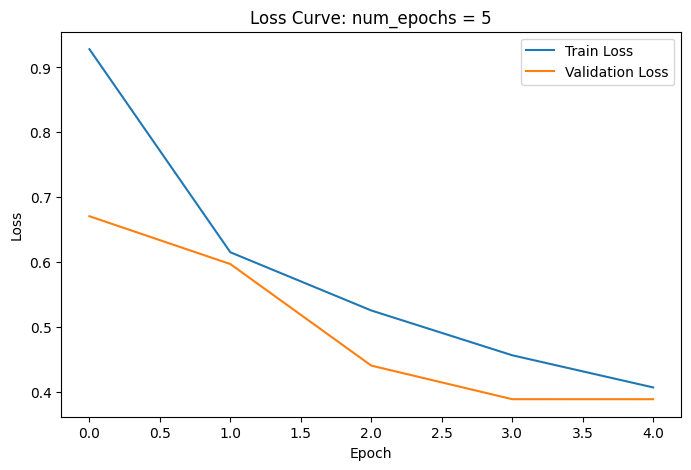

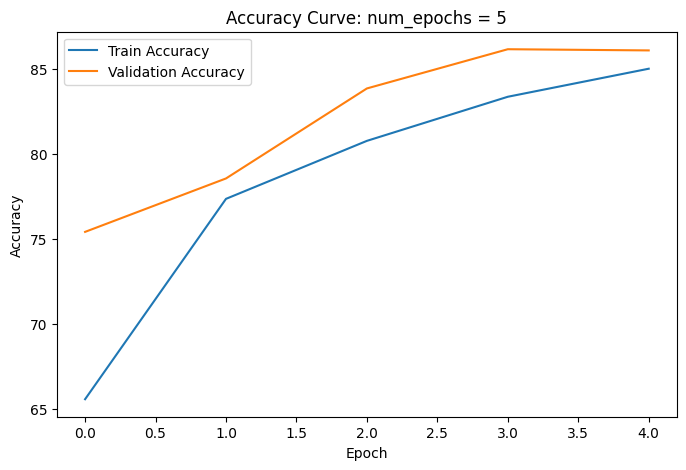

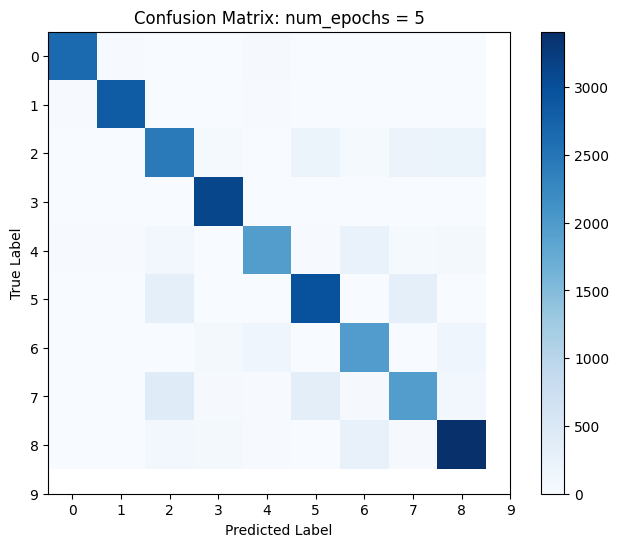

Classification Report:
              precision    recall  f1-score   support

           0     0.9804    0.9728    0.9766      2722
           1     0.9789    0.9843    0.9816      2870
           2     0.7276    0.7785    0.7522      3119
           3     0.9319    0.9939    0.9619      3124
           4     0.8916    0.8004    0.8435      2435
           5     0.8428    0.8169    0.8296      3642
           6     0.7638    0.8357    0.7981      2349
           7     0.7657    0.6849    0.7230      2840
           8     0.8703    0.8746    0.8724      3898

    accuracy                         0.8610     26999
   macro avg     0.8614    0.8602    0.8599     26999
weighted avg     0.8615    0.8610    0.8604     26999


--- Testing num_epochs = 10 ---
Train Accuracy: 90.43%
Validation Accuracy: 90.38%


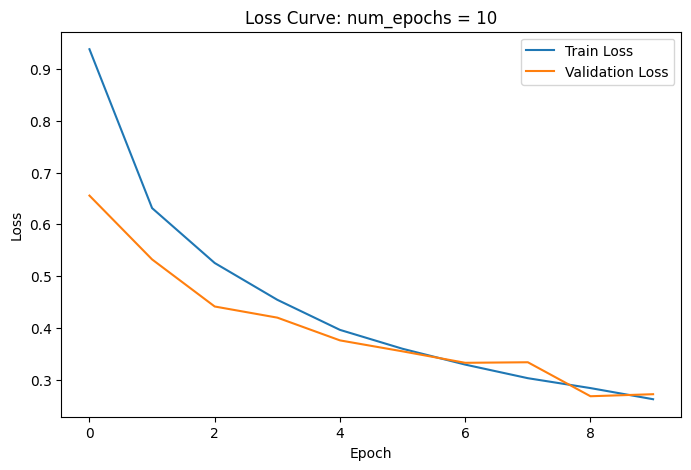

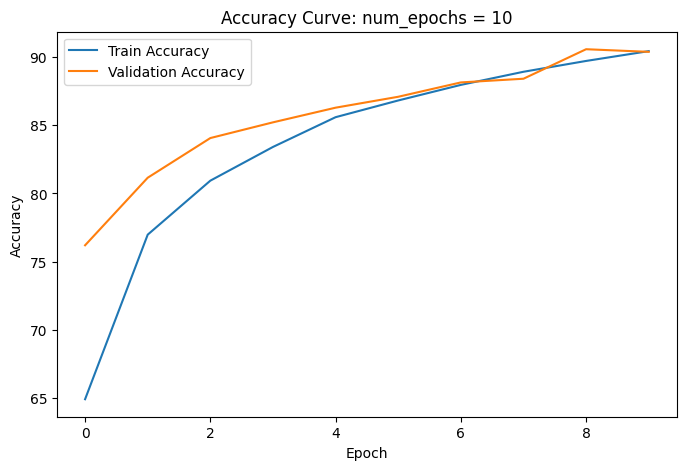

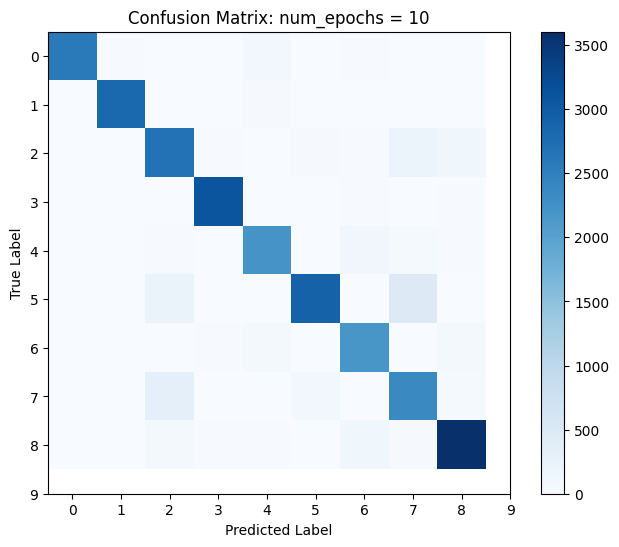

Classification Report:
              precision    recall  f1-score   support

           0     0.9885    0.9453    0.9664      2722
           1     0.9801    0.9798    0.9800      2870
           2     0.8077    0.8605    0.8333      3119
           3     0.9781    0.9878    0.9830      3124
           4     0.8902    0.9023    0.8962      2435
           5     0.9513    0.7996    0.8689      3642
           6     0.8650    0.9251    0.8941      2349
           7     0.7588    0.8310    0.7933      2840
           8     0.9246    0.9246    0.9246      3898

    accuracy                         0.9038     26999
   macro avg     0.9049    0.9062    0.9044     26999
weighted avg     0.9075    0.9038    0.9043     26999


--- Testing num_epochs = 15 ---
Train Accuracy: 92.47%
Validation Accuracy: 91.14%


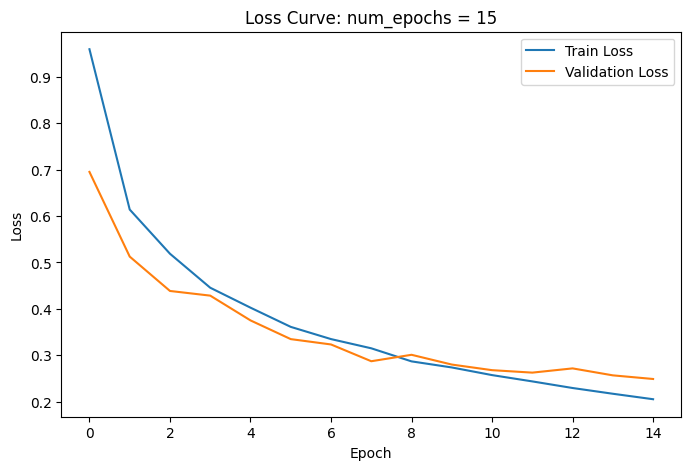

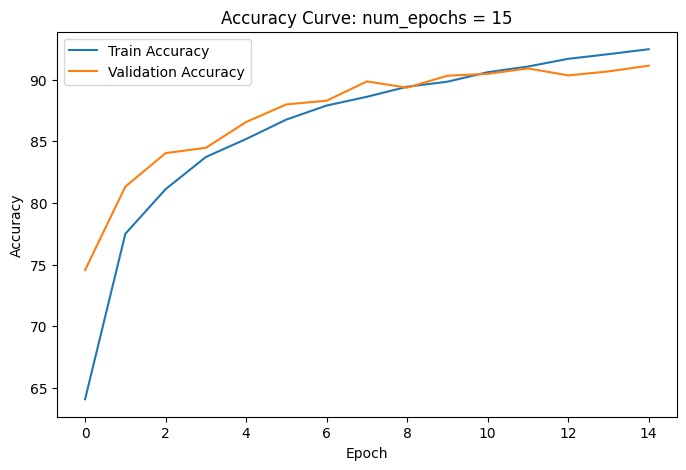

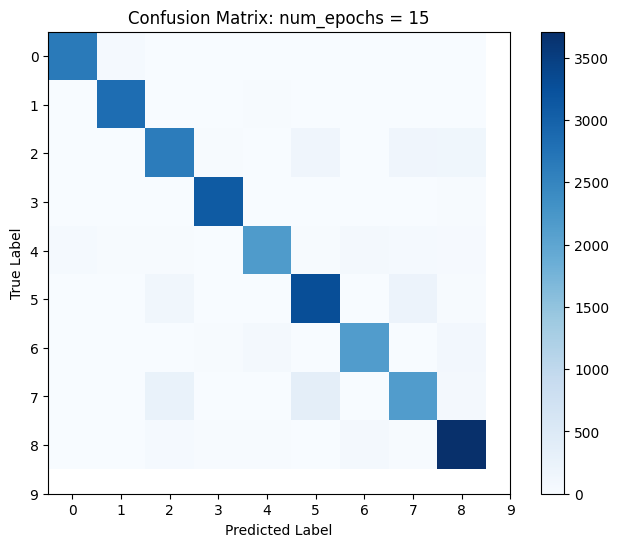

Classification Report:
              precision    recall  f1-score   support

           0     0.9727    0.9695    0.9711      2722
           1     0.9675    0.9864    0.9769      2870
           2     0.8465    0.8397    0.8431      3119
           3     0.9813    0.9904    0.9858      3124
           4     0.9300    0.8895    0.9093      2435
           5     0.8605    0.8992    0.8794      3642
           6     0.9270    0.9080    0.9174      2349
           7     0.8279    0.7539    0.7892      2840
           8     0.9064    0.9513    0.9283      3898

    accuracy                         0.9114     26999
   macro avg     0.9133    0.9098    0.9112     26999
weighted avg     0.9108    0.9114    0.9107     26999


--- Testing num_epochs = 20 ---
Train Accuracy: 94.37%
Validation Accuracy: 92.00%


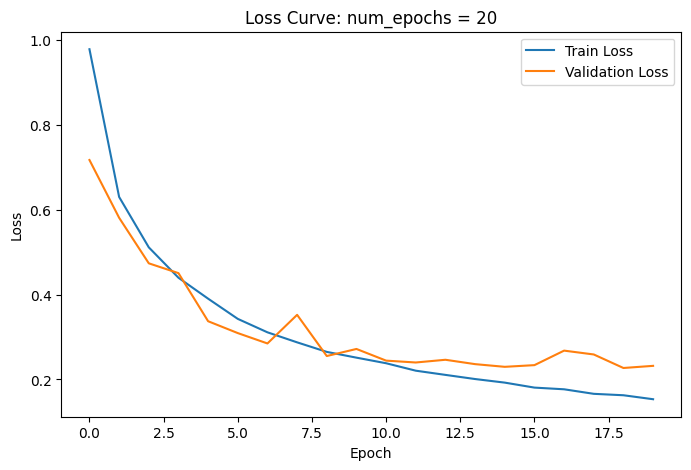

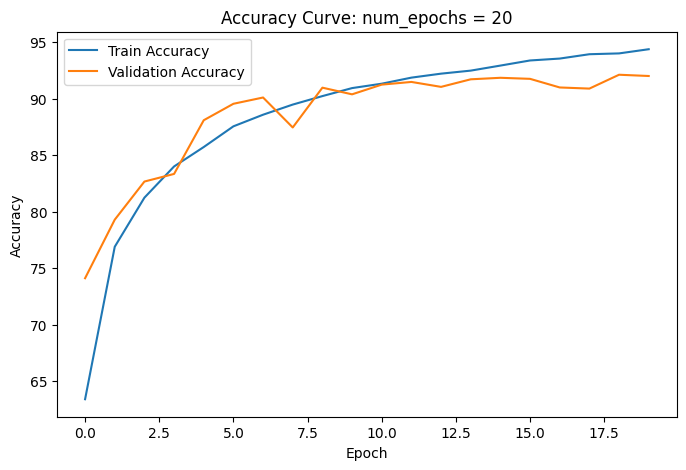

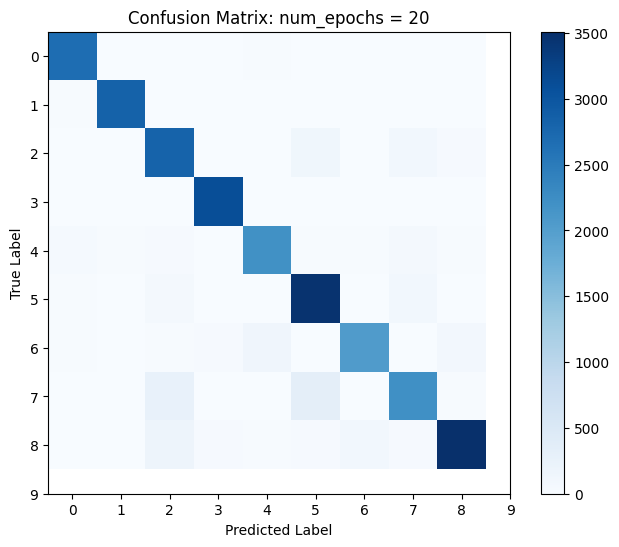

Classification Report:
              precision    recall  f1-score   support

           0     0.9634    0.9860    0.9746      2722
           1     0.9892    0.9857    0.9874      2870
           2     0.8329    0.9029    0.8665      3119
           3     0.9746    0.9952    0.9848      3124
           4     0.9078    0.9014    0.9046      2435
           5     0.8666    0.9489    0.9059      3642
           6     0.9355    0.8650    0.8989      2349
           7     0.8749    0.7782    0.8237      2840
           8     0.9541    0.9002    0.9263      3898

    accuracy                         0.9200     26999
   macro avg     0.9221    0.9182    0.9192     26999
weighted avg     0.9212    0.9200    0.9196     26999


--- Testing num_epochs = 25 ---
Train Accuracy: 94.81%
Validation Accuracy: 93.23%


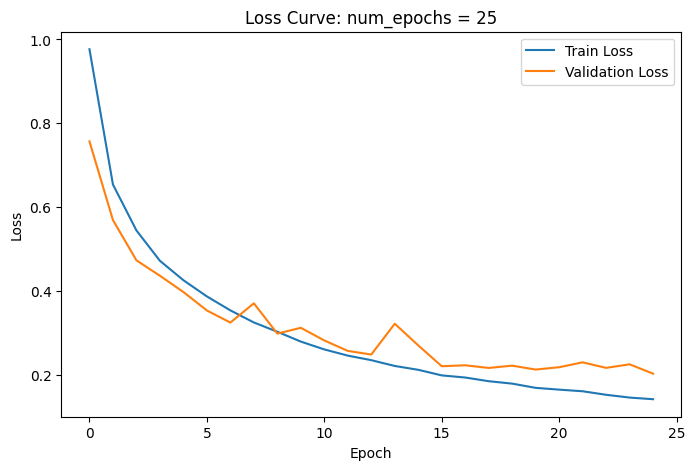

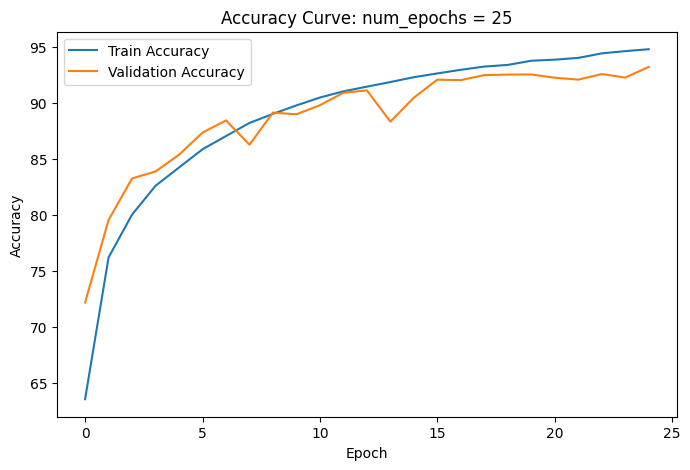

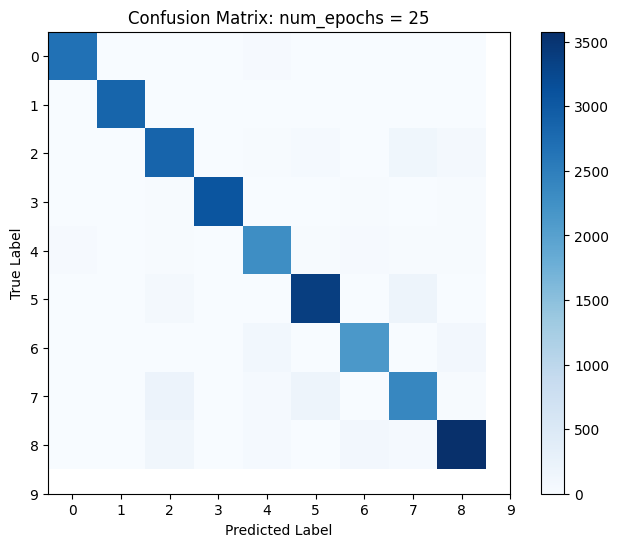

Classification Report:
              precision    recall  f1-score   support

           0     0.9798    0.9824    0.9811      2722
           1     0.9937    0.9902    0.9920      2870
           2     0.8662    0.9150    0.8899      3119
           3     0.9945    0.9798    0.9871      3124
           4     0.8885    0.9359    0.9116      2435
           5     0.9298    0.9270    0.9284      3642
           6     0.9219    0.9051    0.9134      2349
           7     0.8623    0.8380    0.8500      2840
           8     0.9478    0.9179    0.9326      3898

    accuracy                         0.9323     26999
   macro avg     0.9316    0.9324    0.9318     26999
weighted avg     0.9329    0.9323    0.9324     26999


--- Testing num_epochs = 30 ---
Train Accuracy: 95.79%
Validation Accuracy: 93.21%


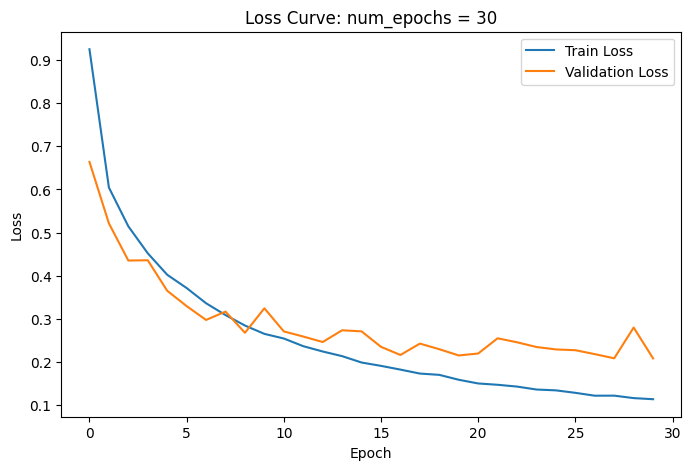

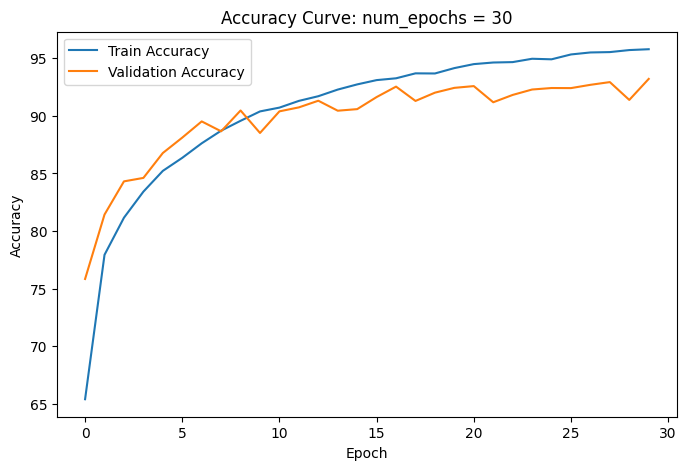

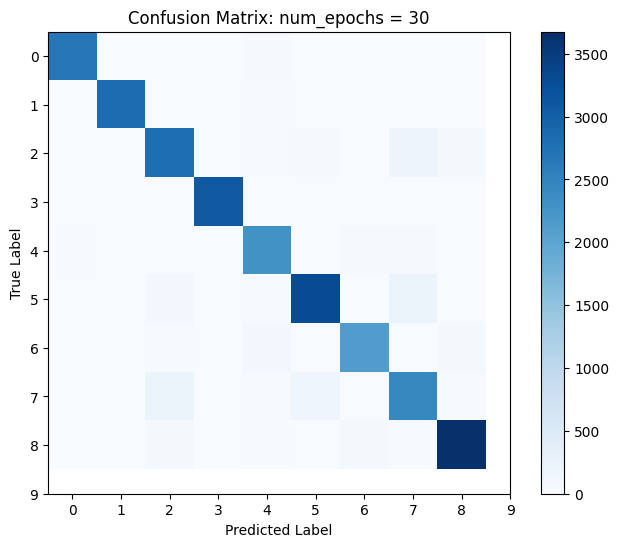

Classification Report:
              precision    recall  f1-score   support

           0     0.9856    0.9787    0.9821      2722
           1     0.9909    0.9847    0.9878      2870
           2     0.8696    0.8939    0.8816      3119
           3     0.9901    0.9923    0.9912      3124
           4     0.8982    0.9380    0.9176      2435
           5     0.9358    0.9003    0.9177      3642
           6     0.9278    0.9029    0.9152      2349
           7     0.8362    0.8556    0.8458      2840
           8     0.9501    0.9428    0.9464      3898

    accuracy                         0.9321     26999
   macro avg     0.9316    0.9321    0.9317     26999
weighted avg     0.9328    0.9321    0.9323     26999



In [ ]:
from itertools import product

fixed_params = {
    'conv_kernel_size': 3,
    'conv_dropout': 0.2,
    'activation_fn': 'relu',
    'batch_size': 64,
    'optimizer_type': 'adam',
    'num_conv_layers': 2,
    'fc_hidden_units': 128,
    'pool_kernel_size': 2,
    'pool_stride': 2,
    'fc_dropout': 0,
    'num_epochs': 10
}

num_epochs = [5, 10, 15, 20, 25, 30]
criterion = nn.CrossEntropyLoss()

for val in num_epochs:
    print(f"\n--- Testing num_epochs = {val} ---")

    current_params = fixed_params.copy()
    current_params['num_epochs'] = val
    batch_size = current_params['batch_size']

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    try:
        model = PathMNIST_CNN(
            conv_kernel_size=current_params['conv_kernel_size'],
            conv_dropout=current_params['conv_dropout'],
            activation_fn=current_params['activation_fn'],
            num_conv_layers=current_params['num_conv_layers'],
            fc_hidden_units=current_params['fc_hidden_units'],
            pool_kernel_size=current_params['pool_kernel_size'],
            pool_stride=current_params['pool_stride'],
            fc_dropout=current_params['fc_dropout']
        ).to(device)
    except Exception as e:
        print(f"[SKIPPED] Hata oluştu: {e} → num_epochs = {val}")
        continue

    if current_params['optimizer_type'] == 'adam':
        optimizer = optim.Adam(model.parameters())
    elif current_params['optimizer_type'] == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    else:
        optimizer = optim.RMSprop(model.parameters())

    train_losses, val_losses, val_accuracies, train_accuracies, preds, labels = train_and_validate(
        model, train_loader, val_loader, optimizer, criterion, epochs=current_params['num_epochs'])

    print(f"Train Accuracy: {train_accuracies[-1]:.2f}%")
    print(f"Validation Accuracy: {val_accuracies[-1]:.2f}%")

    # Plot Loss
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Loss Curve: num_epochs = {val}')
    plt.legend()
    plt.show()

    # Plot Accuracy
    plt.figure(figsize=(8, 5))
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy Curve: num_epochs = {val}')
    plt.legend()
    plt.show()

    # Confusion Matrix
    cm = confusion_matrix(labels, preds.argmax(dim=1))
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix: num_epochs = {val}")
    plt.colorbar()
    tick_marks = np.arange(10)
    plt.xticks(tick_marks, tick_marks)
    plt.yticks(tick_marks, tick_marks)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    # Classification Report
    print("Classification Report:")
    print(classification_report(labels, preds.argmax(dim=1), digits=4))


In [1]:

params = {
    'conv_kernel_size': 3,
    'conv_dropout': 0.2,
    'activation_fn': 'relu',
    'batch_size': 64,
    'optimizer_type': 'adam',
    'num_conv_layers': 2,
    'fc_hidden_units': 128,
    'pool_kernel_size': 2,
    'pool_stride': 2,
    'fc_dropout': 0,
    'num_epochs': 25,
    'num_classes': 9
}


train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=params['batch_size'], shuffle=False)

# build model
model = PathMNIST_CNN(
    conv_kernel_size=params['conv_kernel_size'],
    conv_dropout=params['conv_dropout'],
    activation_fn=params['activation_fn'],
    num_conv_layers=params['num_conv_layers'],
    fc_hidden_units=params['fc_hidden_units'],
    pool_kernel_size=params['pool_kernel_size'],
    pool_stride=params['pool_stride'],
    fc_dropout=params['fc_dropout'],
    num_classes=params['num_classes']
).to(device)

# loss function and optimizer
criterion = nn.CrossEntropyLoss()

if params['optimizer_type'] == 'adam':
    optimizer = optim.Adam(model.parameters())
elif params['optimizer_type'] == 'sgd':
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
else:
    optimizer = optim.RMSprop(model.parameters())

# train and validation
train_losses, val_losses, val_accuracies, train_accuracies, preds, labels = train_and_validate(
    model, train_loader, val_loader, optimizer, criterion, epochs=params['num_epochs']
)

print(f"Train Accuracy: {train_accuracies[-1]:.2f}%")
print(f"Validation Accuracy: {val_accuracies[-1]:.2f}%")

# saving model
torch.save(model.state_dict(), "model_guncel.pth")

# Loss graph
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Loss Curve: conv_kernel_size = {params["conv_kernel_size"]}')
plt.legend()
plt.show()

# Accuracy graph
plt.figure(figsize=(8, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'Accuracy Curve: conv_kernel_size = {params["conv_kernel_size"]}')
plt.legend()
plt.show()

# Confusion matrix
cm = confusion_matrix(labels, preds.argmax(dim=1))
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix: conv_kernel_size = {params['conv_kernel_size']}")
plt.colorbar()
tick_marks = np.arange(params['num_classes'])
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Classification report
print("Classification Report:")
print(classification_report(labels, preds.argmax(dim=1), digits=4))


NameError: name 'DataLoader' is not defined

In [37]:
torch.save(model.state_dict(), "model_guncel.pth")


<ipython-input-38-2650afafd0c9>:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model_guncel.pth"))



Test Loss: 0.4909
Test Accuracy: 0.8535

Classification Report (Test Set):
              precision    recall  f1-score   support

           0     0.9535    0.9798    0.9665      1338
           1     0.9549    0.9740    0.9643       847
           2     0.4750    0.8112    0.5991       339
           3     0.8489    0.9748    0.9075       634
           4     0.9440    0.9275    0.9357      1035
           5     0.8111    0.4932    0.6134       592
           6     0.8518    0.7989    0.8245       741
           7     0.5560    0.3064    0.3951       421
           8     0.8466    0.9132    0.8787      1233

    accuracy                         0.8535      7180
   macro avg     0.8046    0.7977    0.7872      7180
weighted avg     0.8565    0.8535    0.8469      7180



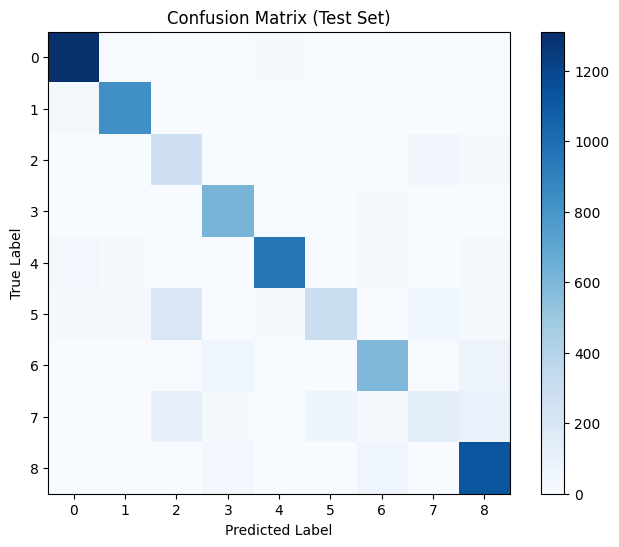

In [38]:
# @title
# Hyperparameters should be same
params = {
    'conv_kernel_size': 3,
    'conv_dropout': 0.4,
    'activation_fn': 'relu',
    'num_conv_layers': 2,
    'fc_hidden_units': 128,
    'pool_kernel_size': 3,
    'pool_stride': 2,
    'fc_dropout': 0.1,
    'num_classes': 9,
    'batch_size': 64
}

# Test loader
test_loader = DataLoader(test_dataset, batch_size=params['batch_size'], shuffle=False)

# buil model again
model = PathMNIST_CNN(
    conv_kernel_size=params['conv_kernel_size'],
    conv_dropout=params['conv_dropout'],
    activation_fn=params['activation_fn'],
    num_conv_layers=params['num_conv_layers'],
    fc_hidden_units=params['fc_hidden_units'],
    pool_kernel_size=params['pool_kernel_size'],
    pool_stride=params['pool_stride'],
    fc_dropout=params['fc_dropout'],
    num_classes=params['num_classes']
).to(device)

model.load_state_dict(torch.load("model_guncel.pth"))
model.eval()


criterion = nn.CrossEntropyLoss()

test_loss = 0.0
correct = 0
total = 0
all_preds = []
all_targets = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        targets = targets.squeeze(1)
        loss = criterion(outputs, targets)
        test_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

test_loss /= len(test_loader)
test_accuracy = correct / total

print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Confusion Matrix
cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Test Set)")
plt.colorbar()
tick_marks = np.arange(params['num_classes'])
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Classification Report
print("\nClassification Report (Test Set):")
print(classification_report(all_targets, all_preds, digits=4))
